# Cleaning Data

At this stage, it is important to clean the 100x100data. 

Several issues were highlighted throughout the process.

### # of Finishers
As part of the analysis, DUV and ITRA finishers time were downloaded to verify runner's status and, if lucky, finishing time. 

When comparing the scraped 100x100 data to DUV and ITRA, it came to light that sometimes, runners are marked as finished on 100x100trail, although they did not get a finishers status on ITRA or DUV. THis required cleaning. 

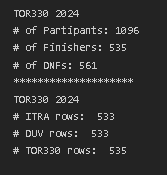

Furthermore, sometimes runners were given a status of not finished. THis was easily fixed by checking their timestamp at finish line (Courmayer). However, in that case, it was made sure that there was a timestamp for them between road Stages

### Life bases / Refugees

Several cleaning methods were deployed to clean this column. There were 'RITIRIO' in some values, so this needed to be stripped and kept in a different column 

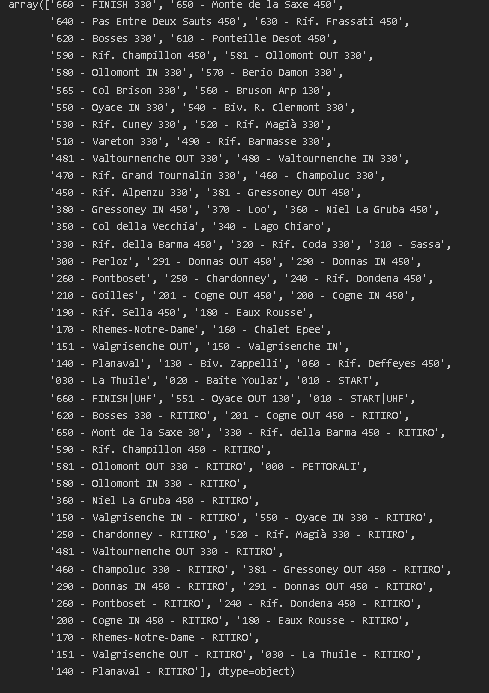


### 'Time' column
'Time' Column is one the most important columns in this process and needs to be meticulously cleaned for errors and inconsitencies!

The timesstamps had '+02:00' which was not necessary once inspected. 
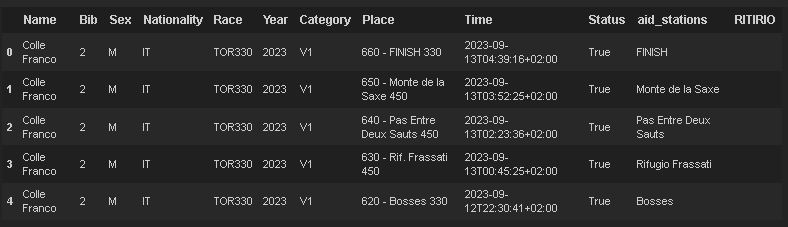


### Starting Time
Starting Times were also inaccurate. The starting time was set random times (who knows why?) but the times were changed to reflect wave start times!
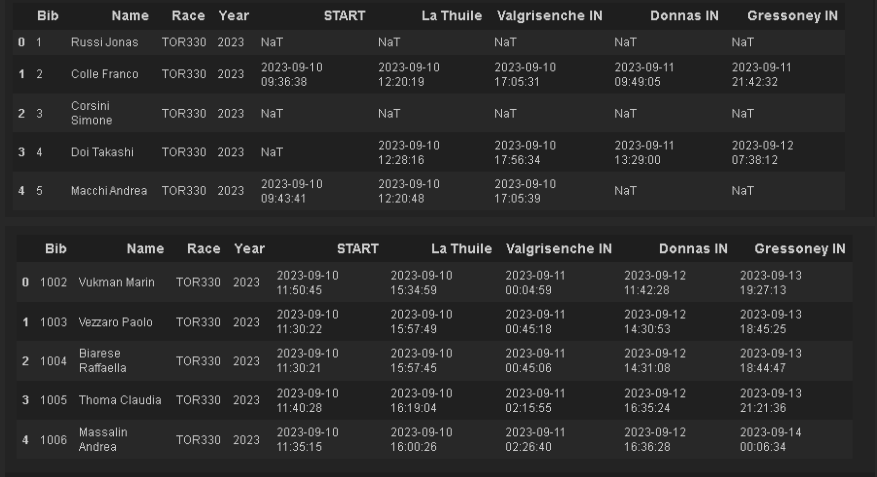

To deal with the Start Time, issue, DUV data was used to detect the start date for each year

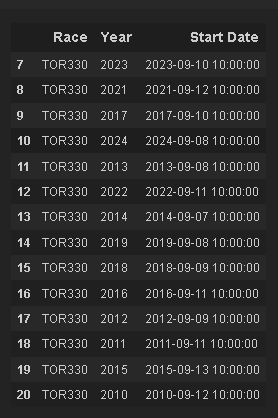

In [1]:
import re
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

# Start the timer
start_time = time.time()

In [2]:
# # Set pandas options to display all columns and rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows

In [3]:
# def saving_tableau_df(df, name):
#     # Specify the file path
#     file_path = f'{race} Data/5. Clean Data for Data Visualisation/{race}_{name}.xlsx'

#     # Check if the file exists
#     if os.path.exists(file_path):
#         # Read the existing file into a DataFrame
#         existing_data = pd.read_excel(file_path)

#         # Reset the index to ensure no duplicate indices
#         existing_data.reset_index(drop=True, inplace=True)
#         df.reset_index(drop=True, inplace=True)
        
#         for num_column in ['Bib', 'Year']:
#             df[num_column] = df[num_column].astype('int')
#             df[num_column] = df[num_column].astype('str')

#         # Find rows in TOR450_dem that are not in the existing_data
#         new_rows = df[~df.apply(tuple, axis=1).isin(existing_data.apply(tuple, axis=1))]

#         if not new_rows.empty:
#             # Concatenate the new rows to the existing data, resetting the index afterward
#             updated_data = pd.concat([existing_data, new_rows], ignore_index=True)

#             # Save the updated data back to the file
#             updated_data.to_excel(file_path, index=False)
#             print("New rows added to the file.")
#         else:
#             print("No new rows to add. File remains unchanged.")
#     else:
#         # If the file doesn't exist, save the DataFrame as a new file
#         df.to_excel(file_path, index=False)
#         print(f"File created at {file_path}.")

In [4]:

def saving_tableau_df(df, name):
    for num_column in ['Bib', 'Year']:
            df[num_column] = df[num_column].astype('int')
            df[num_column] = df[num_column].astype('str')
    file_path = f'{race} Data/5. Clean Data for Data Visualisation/{race}_{name}.xlsx'
    df.to_excel(file_path, index=False)

In [5]:
def create_lifebase_checkpoint_and_aid_station_sub_df(df, column_list, column, dem_list, category_order):
    sub_df= df[column_list]

    # Pivot the data using melt
    melt_sub_df = sub_df.melt(id_vars= dem_list, 
                         var_name=column, 
                         value_name=f"Timestamp")

    # Set 'Finish Category' as a categorical column with the defined order
    melt_sub_df[column] = pd.Categorical(
        melt_sub_df[column],
        categories = category_order,
        ordered=True
    )
    
    melt_sub_df[column] = melt_sub_df[column].str.replace('Start Date','Start')

    return melt_sub_df

In [6]:
def fixing_negative_duration(df):
    # to replace all negative values with Nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Timestamp'] = pd.NaT
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Running Total Duration'] = np.nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Running Total Duration_seconds'] = np.nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Duration_seconds'] = np.nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Duration'] = np.nan


In [7]:
def calculating_banked_time(df, df_cut_offs_df, column):
    
    # Merge the datsets back together
    df = df.merge(
        df_cut_offs_df[[column, f'Running Total {column} Duration']], 
        right_on=[column],
        left_on=[column],
        how='left'
    )

    df['Banking Time'] = df[f'Running Total {column} Duration'] - df['Running Total Duration']
    df[f'Banking Time_seconds'] = pd.to_timedelta( df[f"Banking Time"], errors='coerce').dt.total_seconds()
    print(df[['Bib', column,\
              f'Running Total {column} Duration',\
              'Running Total Duration', 'Banking Time']][df['Bib'] == '1440'].head(5).transpose())
    return df


In [8]:
    
def place_into_stage(df, column):

    stages =[ Stage1, Stage2, Stage3, Stage4, Stage4_diversion ]
    stages_str =[ 'Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 4 Diversion']
    for stage,  stage_str in zip(stages, stages_str):
        df.loc[df[column].isin(stage), 'Stage'] = f'{stage_str}'

    lifebase_time_spent = ['Cogne OUT','Donnas OUT','Gressoney OUT']

    for lifebase in lifebase_time_spent:
        lifebase_split = lifebase.split(' OUT')[0] 
        df.loc[df[column] == lifebase, 'Stage'] = f'Time Spent in {lifebase_split}'
    
    df['Stage'] = df['Stage'].fillna('Stage?')
        
    return df


In [9]:
lifebase_category_order = ['START',
            'Cogne IN', 'Cogne OUT', 
            'Donnas IN', 'Donnas OUT', 
            'Gressoney IN', 'Gressoney OUT', 
                           'FINISH' ]



In [10]:
checkpoint_category_order = [ 'START',
                        'Cogne IN', 'Cogne OUT',
                        'Donnas IN', 'Donnas OUT',
                        'Gressoney IN', 'Gressoney OUT', 
                        'Rifugio Champillon', 
                             'FINISH']

In [11]:
aid_station_category_order = ['START',  
    'Rifugio Maison Vieille', 'Rifugio Elisabetta', 'Rifugio Deffeyes',
    'Rifugio degli Angeli', 'Rifugio Bezzi', 'Rifugio Benevolo', 
    'Rifugio Savoia', 'Rifugio Vittorio Emanuele II', 'Rifugio Chabod', 'Rifugio Sella', 
'Cogne IN', 'Cogne OUT',
    'Rifugio Grauson', 'Rifugio Miserin', 'Rifugio Dondena', 'Dortoir Retempio', 'Dortoir Crest', 'Rifugio Bonze', 
'Donnas IN', 'Donnas OUT',
    'Perloz','Sassa',  'Rifugio Coda', 'Rifugio della Barma',
 'Lago Chiaro', 'Col della Vecchia', 'Niel La Gruba','Loo',
'Gressoney IN', 'Gressoney OUT',
    'Rifugio Sitten', 'Rifugio Ferraro', 'Rifugio Guide di Frachey', 'Rifugio Duca degli Abruzzi',
    'Rifugio Perucca Vuillermoz', 'Rifugio Prarayer', 'Rifugio Crête Sèche',
    'Rifugio Champillon', 'Ponteille Desot', 'Hotel Italia', 'Rifugio Frassati',
    'Pas Entre Deux Sauts', 'Monte de la Saxe','Parco Bollino',
    'FINISH']


In [12]:
weather_contigency_route  = ['START',  'Rifugio Maison Vieille', 'Rifugio Elisabetta', 'Rifugio Deffeyes',
 'Rifugio degli Angeli', 'Rifugio Bezzi', 'Rifugio Benevolo', 'Rifugio Savoia',
 'Rifugio Vittorio Emanuele II', 'Rifugio Chabod', 'Rifugio Sella', 'Cogne IN',
 'Cogne OUT', 'Rifugio Grauson','Rifugio Dondena', 'Rifugio Miserin',  'Dortoir Crest','Dortoir Retempio',
 'Rifugio Bonze', 'Donnas IN', 'Donnas OUT', 'Perloz', 'Sassa',  'Rifugio Coda', 'Rifugio della Barma',
 'Lago Chiaro', 'Col della Vecchia', 'Niel La Gruba','Loo', 'Gressoney IN', 'Gressoney OUT', 'Rifugio Sitten','Rifugio Ferraro',
 'Rifugio Guide di Frachey', 'Hotel Stambecco', 'Rifugio Perucca Vuillermoz',
 'Rifugio Prarayer', 'Rifugio Crête Sèche', 'Oyace', 'Oyace OUT', 'Bruson Arp',
 'Col Brison', 'Berio Damon', 'Ollomont IN', 'Ollomont OUT', 'Rifugio Champillon',
 'Ponteille Desot', 'Hotel Italia', 'Rifugio Frassati', 'Pas Entre Deux Sauts', 
 'Monte de la Saxe', 'Parco Bollino','FINISH']

In [13]:
Stage1 = [ 'START', 'Rifugio Maison Vieille', 'Rifugio Elisabetta',
 'Rifugio Deffeyes', 'Rifugio degli Angeli', 'Rifugio Bezzi',
 'Rifugio Benevolo', 'Rifugio Savoia', 'Rifugio Vittorio Emanuele II',
 'Rifugio Chabod', 'Rifugio Sella', 'Cogne IN']

Stage2 = [ 'Cogne OUT', 'Rifugio Grauson', 'Rifugio Dondena', 'Rifugio Miserin', 'Dortoir Crest',
 'Dortoir Retempio', 'Rifugio Bonze', 'Donnas IN']

Stage3 = [ 'Donnas OUT', 'Perloz','Sassa',  'Rifugio Coda', 'Rifugio della Barma',
 'Lago Chiaro', 'Col della Vecchia', 'Niel La Gruba',
 'Loo', 'Gressoney IN']

Stage4 =  ['Gressoney OUT', 'Rifugio Sitten', 'Rifugio Ferraro','Rifugio Guide di Frachey',
 'Rifugio Duca degli Abruzzi', 'Hotel Stambecco', 'Rifugio Perucca Vuillermoz',
 'Rifugio Prarayer', 'Rifugio Crête Sèche',
 'Rifugio Champillon', 'Ponteille Desot',
 'Hotel Italia', 'Rifugio Frassati',
 'Pas Entre Deux Sauts', 'Monte de la Saxe', 'Parco Bollino', 'FINISH'] 

Stage4_diversion =  [  'Oyace',  'Oyace OUT',
 'Bruson Arp', 'Col Brison',
 'Berio Damon', 'Ollomont IN',
 'Ollomont OUT']

DNF_areas =  [  'Champoluc', 'Valtourenche OUT', 'Bosses']

stages =[ Stage1, Stage2, Stage3, Stage4, Stage4_diversion, DNF_areas]
stages_str =[ 'Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 4 Diversion', 'DNFed on TOR330 route' ]

## Looping through scraped data from 100X100trail

In [14]:
# races = ['TOR450']
race = 'TOR450'
years = [ 
    '2021',
    '2022',
    '2023', 
    '2024'
        ]

TORX_df = {}


for year in years:
    df = pd.read_excel(f'{race} Data/1. 100x100trail/{race}_{year}.xlsx',
                             dtype={'Start Date': 'string',
                                    'Year': 'string'})
    print(f'{race}_{year} {df.shape}')
    # Store the DataFrame in the dictionary with a key like 'TOR450_2021'
    TORX_df[f'{race}_{year}'] = df
    print('*'*50)

TOR450_2021 (1496, 10)
**************************************************
TOR450_2022 (3672, 10)
**************************************************
TOR450_2023 (5410, 10)
**************************************************
TOR450_2024 (4585, 10)
**************************************************


In [15]:
TORX_df_concat = pd.concat(TORX_df)

In [16]:
# TOR450 = TORX_df_concat[TORX_df_concat['Year'] == year]
TOR450 = TORX_df_concat.copy()
TOR450.reset_index(drop = True, inplace =  True )

In [17]:
def count_year_status(df, column):
    sub_df = df[['Name', 'Bib', 'Sex', 'Nationality', 'Race', 'Year', 'Category',column]].drop_duplicates(keep = 'first')
    year_status_count = sub_df.groupby(['Year', column])[column].count().to_frame('count').reset_index()

    year_status_count = year_status_count.pivot_table(
            index=column,
            columns='Year',  
            values='count',
            aggfunc='first'  # Ensures only the first match is kept in case of duplicates
        ).reset_index()
    print(year_status_count)
count_year_status(TOR450, 'Status')

Year  Status  2021    2022    2023    2024  
0      False      25     103      97     117
1       True      31      46      90      68


### DUV and ITRA data


#### # of Finishers
As part of the analysis, DUV and ITRA finishers time were downloaded to verify runner's status and, if lucky, finishing time. 

When comparing the scraped 100x100 data to DUV and ITRA, it came to light that sometimes, runners are marked as finished on 100x100trail, although they did not get a finishers status on ITRA or DUV. THis required cleaning. 

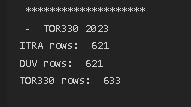


In [18]:
TORX_duv_df = pd.read_excel(f'{race} data/5. Clean Data for Data Visualisation/{race}_duv.xlsx',
                                     dtype={'Year': 'string'})

TORX_itra_no_DNF = pd.read_excel(f'{race} Data/5. Clean Data for Data Visualisation/{race}_itra_no_DNF.xlsx',
                                     dtype={'Year': 'string'})

DUV_330 = pd.read_excel(f'TOR330 data/5. Clean Data for Data Visualisation/TOR330_duv.xlsx',
                                     dtype={'Year': 'string'})



In [19]:
def find_out_the_rows_difference_between_datasets(df):
    for year in years :
        if len(df['Name'][(df['Year'] == year)]) != 0:

            print(race, year)
#             print('# ITRA rows: ', TORX_itra_no_DNF[(TORX_itra_no_DNF['Year'] == year) &
#                               (TORX_itra_no_DNF['Race'] == race)].shape[0])
            print('# DUV rows: ',TORX_duv_df[(TORX_duv_df['Year'] == year) &
                              (TORX_duv_df['Race'] == race)].shape[0])

            print('# TOR450 rows: ', len(df['Name'][(df['Year'] == year) &
                                             (df['Race'] == race) &
                                             (df['Status'] == True)].unique()))
            print('\n', '*'*20)

#             if year == '2022':
#                 print(' - ','TOR450','2022')
#                 print(TORX_itra_no_DNF[(TORX_itra_no_DNF['Race'] == 'TOR450') &
#                       (TORX_itra_no_DNF['Year'] == '2022')].groupby(['Status'])['Status'].count())
#                 print('\n', '*'*20)
        else: 
            pass

In [20]:
count_year_status(TOR450, 'Status')
find_out_the_rows_difference_between_datasets(TOR450)
# counting_groupby_dataset(TOR450,  'Status')

Year  Status  2021    2022    2023    2024  
0      False      25     103      97     117
1       True      31      46      90      68
TOR450 2021
# DUV rows:  31
# TOR450 rows:  31

 ********************
TOR450 2022
# DUV rows:  46
# TOR450 rows:  46

 ********************
TOR450 2023
# DUV rows:  85
# TOR450 rows:  90

 ********************
TOR450 2024
# DUV rows:  68
# TOR450 rows:  68

 ********************


In [21]:
DUV_450 = TORX_duv_df.copy()
DUV_450.head()

Name DUV_ationality Sex        DOB  Performance  \
0              Raichon Sebastien            FRA   M 1972-01-01     4.770150   
1  Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01     4.868287   
2                   Kienzl Peter            ITA   M 1975-01-01     5.041435   
3  Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01     5.090058   
4              Raichon Sebastien            FRA   M 1972-01-01     5.164792   

   Performance_Seconds    Race  Year  
0             412141.0  TOR450  2023  
1             420620.0  TOR450  2023  
2             435580.0  TOR450  2023  
3             439781.0  TOR450  2024  
4             446238.0  TOR450  2022

In [22]:
TOR450_dem = TOR450[['Name', 'Bib', 'Sex', 'Nationality', 'Race', 'Year', 'Category','Status']].drop_duplicates(keep = 'first').reset_index(drop = True)

In [23]:
TOR450_dem.groupby('Year')['Year'].count()

Year
2021     56
2022    149
2023    187
2024    185
Name: Year, dtype: int64

In [24]:
for df in [DUV_330, DUV_450]:
    # # # Convert integer seconds to timedelta
    df['Performance'] = pd.to_timedelta(df['Performance_Seconds'], unit='s')
    
    # Convert to timedelta and get total hours (handling NaT)
    df['Performance_hours'] = pd.to_timedelta(
        df['Performance'], errors='coerce'
    ).dt.total_seconds() / 3600  # Convert seconds to hours

### Cleaning Place column

In [25]:
TOR450['Place'].unique()

array(['660 - FINISH - UHF', '650 - Mont de la Saxe 130|133.7|12388',
       '640 - Pas Entre Deux Sauts 330|335.6|30486',
       '630 - Rif. Frassati 130|118.9|11422',
       '600 - Hotel Italia - GSB|417|35131',
       '590 - Rif. Champillon 330|303.5|27681',
       '440 - Rif. Crête Sèche|374|31562',
       '430 - Rif. Prarayer|359|30170',
       '420 - Rif. Perucca Vuillermoz|352|29814',
       '410 - Rif. Duca degli Abruzzi|336|28541',
       '400 - Rif. Ferraro|314|26622', '390 - Rif. Sitten|301|25584',
       '381 - Gressoney 330 OUT|213.4|18300',
       '380 - Gressoney 330 IN|213.4|18300', '370 - Loo|206|18063',
       '360 - Niel - La Gruba 330|199.7|17166',
       '330 - Rif. della Balm 450a|255|21628',
       '320 - Rif. Coda 330|174.5|15024',
       '291 - Donnas 330 OUT|156.3|12242',
       '290 - Donnas 330 IN|156.3|12242', '280 - Rif. Bonze|217|17432',
       '270 - Dortoir Crest|206|15659',
       '240 - Rif. Dondena 330|132.9|11303',
       '230 - Rif. Miserin|180|139

In [26]:
# 030 - La Thuile - RITIRO
TOR450['aid_stations'] = TOR450['Place'].str.split(r'^\d+ - ').str.get(-1)
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Rif. della Balm 450a','Rif. della Barma')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace(r'\d+', '', regex=True)
TOR450['aid_stations'] = TOR450['aid_stations'].str.split('|').str.get(0)
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Rif.', 'Rifugio')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Biv.','Bivacco')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Niel - ','Niel ')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Oyace IN','Oyace')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('  ',' ')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Mont de la Saxe','Monte de la Saxe')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Rifugio della Barmasse', 'Rifugio Barmasse')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Promoud','Bivacco Zappelli')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('FINISH - UHF','FINISH')
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('START - MANUAL','START')
TOR450['aid_stations'] = TOR450['aid_stations'].str.strip()
TOR450['RITIRIO'] = np.where(
    TOR450['aid_stations'].str.contains('RITIRO', na=False), 
    TOR450['aid_stations'],  '')
# TOR450['RITIRIO] =TOR450['RITIRIO].str.replace('- RITIRO', '')
TOR450['aid_stations'] = TOR450['aid_stations'].str.split(' - RITIRO').str.get(0)
TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Hotel Italia - GSB', 'Hotel Italia')


TOR450 = TOR450[~(TOR450['aid_stations'] == '') ]
TOR450 = TOR450[~(TOR450['aid_stations'] == 'PETTORALI') ]
print(', '.join(list(TOR450['aid_stations'].unique())))


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\3913618606.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Rif. della Balm 450a','Rif. della Barma')
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\3913618606.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Rif.', 'Rifugio')
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\3913618606.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR450['aid_stations'] = TOR450['aid_stations'].str.replace('Biv.','Bivacco')


FINISH, Monte de la Saxe, Pas Entre Deux Sauts, Rifugio Frassati, Hotel Italia, Rifugio Champillon, Rifugio Crête Sèche, Rifugio Prarayer, Rifugio Perucca Vuillermoz, Rifugio Duca degli Abruzzi, Rifugio Ferraro, Rifugio Sitten, Gressoney OUT, Gressoney IN, Loo, Niel La Gruba, Rifugio della Barma, Rifugio Coda, Donnas OUT, Donnas IN, Rifugio Bonze, Dortoir Crest, Rifugio Dondena, Rifugio Miserin, Rifugio Grauson, Cogne OUT, Cogne IN, Rifugio Sella, Rifugio Chabod, Rifugio Vittorio Emanuele II, Rifugio Savoia, Rifugio Benevolo, Rifugio Bezzi, Rifugio degli Angeli, Rifugio Elisabetta, Rifugio Maison Vieille, Lago Chiaro, Sassa, START, Perloz, Ponteille Desot, Oyace, Rifugio Guide di Frachey, Col della Vecchia, Dortoir Retempio, Rifugio Deffeyes, Bosses, Chardonney, Hotel Stambecco, Parco Bollino, Col Brison, Bruson Arp, Oyace OUT, Champoluc, Berio Damon, Ollomont OUT, Ollomont IN, Valtournenche OUT


In [27]:
# copy the column to make a new column
for i in list(TOR450['RITIRIO'].unique()):
    print(i)


START - RITIRO
Donnas IN - RITIRO
Champoluc - RITIRO
Gressoney OUT - RITIRO
Rifugio della Barma - RITIRO
Donnas OUT - RITIRO
Cogne OUT - RITIRO
Rifugio Champillon - RITIRO
Ollomont OUT - RITIRO
Valtournenche OUT - RITIRO
Col della Vecchia - RITIRO
Perloz - RITIRO
Chardonney - RITIRO
Cogne IN - RITIRO
Rifugio Savoia - RITIRO


In [28]:
# copy the column to make a new column
all_aid_station_list = list(TOR450['aid_stations'].unique())
all_aid_station_list 

['FINISH',
 'Monte de la Saxe',
 'Pas Entre Deux Sauts',
 'Rifugio Frassati',
 'Hotel Italia',
 'Rifugio Champillon',
 'Rifugio Crête Sèche',
 'Rifugio Prarayer',
 'Rifugio Perucca Vuillermoz',
 'Rifugio Duca degli Abruzzi',
 'Rifugio Ferraro',
 'Rifugio Sitten',
 'Gressoney OUT',
 'Gressoney IN',
 'Loo',
 'Niel La Gruba',
 'Rifugio della Barma',
 'Rifugio Coda',
 'Donnas OUT',
 'Donnas IN',
 'Rifugio Bonze',
 'Dortoir Crest',
 'Rifugio Dondena',
 'Rifugio Miserin',
 'Rifugio Grauson',
 'Cogne OUT',
 'Cogne IN',
 'Rifugio Sella',
 'Rifugio Chabod',
 'Rifugio Vittorio Emanuele II',
 'Rifugio Savoia',
 'Rifugio Benevolo',
 'Rifugio Bezzi',
 'Rifugio degli Angeli',
 'Rifugio Elisabetta',
 'Rifugio Maison Vieille',
 'Lago Chiaro',
 'Sassa',
 'START',
 'Perloz',
 'Ponteille Desot',
 'Oyace',
 'Rifugio Guide di Frachey',
 'Col della Vecchia',
 'Dortoir Retempio',
 'Rifugio Deffeyes',
 'Bosses',
 'Chardonney',
 'Hotel Stambecco',
 'Parco Bollino',
 'Col Brison',
 'Bruson Arp',
 'Oyace OUT',
 

### Cleaning Time column

Column '2024-09-11T07:08:32+02:00' needs to be fixed into '2024-09-11 07:08:32' and turned into the datetime

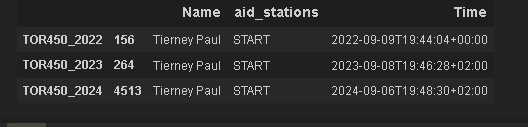

In [29]:
# 2024-09-11T07:08:32+02:00

# Split the 'Time' column to remove the timezone offset
TOR450['Timestamp'] = TOR450['Time'].str.split('+').str[0]


# # Add the 2-hour offset using timedelta
# # NO NEED!!!
# TOR450['Timestamp'] = TOR450['Timestamp'] + pd.to_timedelta('02:00:00')

# Preview the DataFrame
TOR450.head()

Name   Bib Sex Nationality    Race  Year Category  \
0  Papi Luca  4001   M          FR  TOR450  2021       V1   
1  Papi Luca  4001   M          FR  TOR450  2021       V1   
2  Papi Luca  4001   M          FR  TOR450  2021       V1   
3  Papi Luca  4001   M          FR  TOR450  2021       V1   
4  Papi Luca  4001   M          FR  TOR450  2021       V1   

                                        Place                       Time  \
0                          660 - FINISH - UHF  2021-09-16T14:18:00+00:00   
1       650 - Mont de la Saxe 130|133.7|12388  2021-09-16T13:26:33+00:00   
2  640 - Pas Entre Deux Sauts 330|335.6|30486  2021-09-16T11:39:05+00:00   
3         630 - Rif. Frassati 130|118.9|11422  2021-09-16T09:36:17+00:00   
4          600 - Hotel Italia - GSB|417|35131  2021-09-16T06:36:00+00:00   

   Status          aid_stations RITIRIO            Timestamp  
0    True                FINISH          2021-09-16T14:18:00  
1    True      Monte de la Saxe          2021-09-16T13:26:33  
2    True  Pas Entre Deux Sauts          2021-09-16T11:39:05  
3    True      Rifugio Frassati          2021-09-16T09:36:17  
4    True          Hotel Italia          2021-09-16T06:36:00

In [30]:
TOR450[['Name', 'aid_stations', 'Time']][(TOR450['aid_stations'] == 'START') &
              (TOR450['Name'] == 'Tierney Paul')]

Name aid_stations                       Time
1652   Tierney Paul        START  2022-09-09T19:44:04+00:00
5432   Tierney Paul        START  2023-09-08T19:46:28+02:00
15091  Tierney Paul        START  2024-09-06T19:48:30+02:00

In [31]:
bib_df = TOR450[['Name', 'aid_stations', 'Time']][(TOR450['Year'] == '2022') &
              (TOR450['Name'] == 'Tierney Paul')].sort_values(by = 'Time', ascending = True).reset_index(drop = True)


aid_stations_bib_df_list = list(bib_df['aid_stations'].unique())

aid_stations_bib_df_list

['START',
 'Rifugio Maison Vieille',
 'Rifugio Elisabetta',
 'Rifugio Deffeyes',
 'Rifugio degli Angeli',
 'Rifugio Bezzi',
 'Rifugio Benevolo',
 'Rifugio Savoia',
 'Rifugio Vittorio Emanuele II',
 'Rifugio Chabod',
 'Rifugio Sella',
 'Cogne IN',
 'Cogne OUT',
 'Rifugio Grauson',
 'Rifugio Dondena',
 'Dortoir Retempio',
 'Rifugio Bonze',
 'Donnas IN',
 'Donnas OUT',
 'Rifugio Coda',
 'Rifugio della Barma',
 'Lago Chiaro',
 'Col della Vecchia',
 'Niel La Gruba',
 'Loo',
 'Gressoney IN',
 'Gressoney OUT',
 'Rifugio Sitten',
 'Rifugio Guide di Frachey',
 'Rifugio Duca degli Abruzzi',
 'Rifugio Perucca Vuillermoz',
 'Rifugio Prarayer',
 'Rifugio Crête Sèche',
 'Rifugio Champillon',
 'Ponteille Desot',
 'Hotel Italia',
 'Rifugio Frassati',
 'Pas Entre Deux Sauts',
 'Monte de la Saxe',
 'FINISH']

### PIVOTING THE DATASET

In [32]:
# Pivot the data so that each participant has its own column

pivoted_TOR450 = TOR450.copy()

pivoted_TOR450['Time'] = pd.to_datetime(pivoted_TOR450['Timestamp'])

pivoted_TOR450 = pivoted_TOR450[['Name','Bib', 'Sex', 
           'Nationality', 'Category', 'Race','Year', 'Status' ,'aid_stations',  'Timestamp']]

pivoted_TOR450 = pivoted_TOR450.pivot_table(
    index=['Name','Bib', 'Sex', 
           'Nationality', 'Category', 'Race','Year', 'Status' , #'RITIRIO'
          ],
    columns='aid_stations',  
    values= 'Timestamp',
    aggfunc='first'  # Ensures only the first match is kept in case of duplicates
).reset_index()

# pivoted_TOR450 = pivoted_TOR450.sort_values(by = 'Bib', ascending = True)
pivoted_TOR450.head()

aid_stations          Name   Bib Sex Nationality Category    Race  Year  \
0                Adam Eric  4052   M          AT       V1  TOR450  2022   
1              Adet Benoit  4141   M          FR      SEN  TOR450  2024   
2             Ador Thierry  4005   M          FR       V2  TOR450  2022   
3             Ador Thierry  4077   M          FR       V2  TOR450  2023   
4             Ador Thierry  4162   M          FR       V2  TOR450  2024   

aid_stations  Status Berio Damon Bosses  ...     Rifugio Prarayer  \
0               True         NaN    NaN  ...                  NaN   
1               True         NaN    NaN  ...  2024-09-12T20:37:26   
2              False         NaN    NaN  ...                  NaN   
3              False         NaN    NaN  ...                  NaN   
4               True         NaN    NaN  ...  2024-09-12T03:41:16   

aid_stations       Rifugio Savoia        Rifugio Sella       Rifugio Sitten  \
0             2022-09-11T06:42:06  2022-09-11T19:54:33  2022-09-14T16:45:04   
1             2024-09-08T04:48:25  2024-09-08T17:57:04  2024-09-11T17:51:42   
2             2022-09-11T00:52:37  2022-09-11T15:28:33                  NaN   
3             2023-09-09T23:48:49  2023-09-10T11:02:58                  NaN   
4             2024-09-08T03:07:04  2024-09-08T14:42:15  2024-09-11T04:17:34   

aid_stations Rifugio Vittorio Emanuele II Rifugio degli Angeli  \
0                     2022-09-11T11:05:53  2022-09-10T12:51:58   
1                     2024-09-08T09:07:46  2024-09-07T13:31:44   
2                     2022-09-11T04:53:32  2022-09-10T11:46:06   
3                     2023-09-10T03:19:33  2023-09-09T10:41:24   
4                     2024-09-08T07:49:19  2024-09-07T12:47:41   

aid_stations  Rifugio della Barma                START Sassa Valtournenche OUT  
0             2022-09-13T21:06:44  2022-09-09T19:37:18   NaN               NaN  
1             2024-09-10T18:43:09  2024-09-06T19:40:19   NaN               NaN  
2                             NaN  2022-09-09T19:43:59   NaN               NaN  
3             2023-09-12T04:46:07  2023-09-08T19:30:40   NaN               NaN  
4             2024-09-10T10:06:27  2024-09-06T19:41:44   NaN               NaN  

[5 rows x 66 columns]

### Anomalies in 2023!

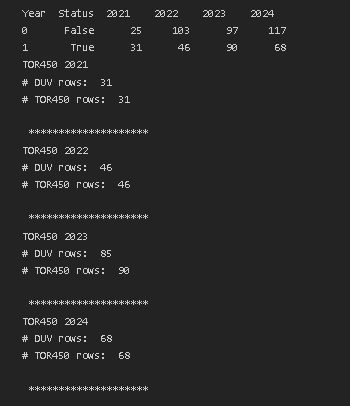

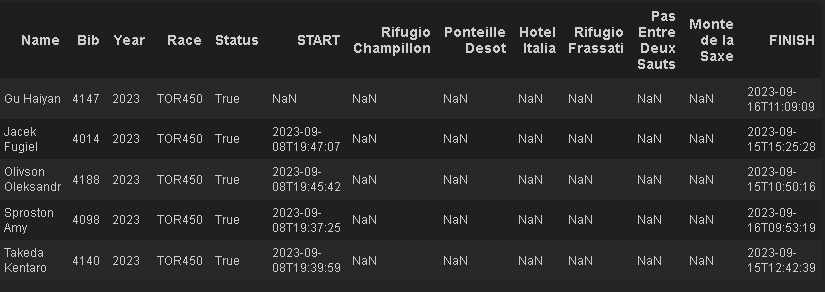

In [33]:
# Looking for runners who have FINISHED< BUT have missing values for all last 3 checkpoints!
anomalies_df = pivoted_TOR450[(pivoted_TOR450['Status'] == True) &
               (pivoted_TOR450['Bosses'].isna()) &                
               (pivoted_TOR450['Rifugio Frassati'].isna()) & 
               (pivoted_TOR450['Pas Entre Deux Sauts'].isna()) &
               (pivoted_TOR450['Monte de la Saxe'].isna())]

anomalies_df[[ 'Name', 'Bib', 'Year', 'Race', 'Status',  'START',
    	 'Rifugio Champillon',
 'Ponteille Desot',
 'Hotel Italia',
 'Rifugio Frassati',
 'Pas Entre Deux Sauts',
 'Monte de la Saxe',
 'FINISH']].reset_index(drop = True)

### Conclusion: Easily visible that there are several other places that have missing values 

aid_stations               Name   Bib  Year    Race  Status  \
0                     Gu Haiyan  4147  2023  TOR450    True   
1                  Jacek Fugiel  4014  2023  TOR450    True   
2             Olivson Oleksandr  4188  2023  TOR450    True   
3                  Sproston Amy  4098  2023  TOR450    True   
4                Takeda Kentaro  4140  2023  TOR450    True   

aid_stations                START Rifugio Champillon Ponteille Desot  \
0                             NaN                NaN             NaN   
1             2023-09-08T19:47:07                NaN             NaN   
2             2023-09-08T19:45:42                NaN             NaN   
3             2023-09-08T19:37:25                NaN             NaN   
4             2023-09-08T19:39:59                NaN             NaN   

aid_stations Hotel Italia Rifugio Frassati Pas Entre Deux Sauts  \
0                     NaN              NaN                  NaN   
1                     NaN              NaN                  NaN   
2                     NaN              NaN                  NaN   
3                     NaN              NaN                  NaN   
4                     NaN              NaN                  NaN   

aid_stations Monte de la Saxe               FINISH  
0                         NaN  2023-09-16T11:09:09  
1                         NaN  2023-09-15T15:25:28  
2                         NaN  2023-09-15T10:50:16  
3                         NaN  2023-09-16T09:53:19  
4                         NaN  2023-09-15T12:42:39

In [34]:
# # EXECUTING SOLUTION
for name in anomalies_df['Name'].unique():  
#     Fixing the code with .loc[] for proper assignment
    pivoted_TOR450.loc[(pivoted_TOR450['Name'] == name) & (pivoted_TOR450['Year'] == '2023'), 'FINISH'] = pd.NaT
    pivoted_TOR450.loc[(pivoted_TOR450['Name'] == name) & (pivoted_TOR450['Year'] == '2023'), 'Status'] = False
    
#     Fixing the code with .loc[] for proper assignment
    TOR450_dem.loc[(TOR450_dem['Name'] == name) & (TOR450_dem['Year'] == '2023'), 'Status'] = False
    
        # Fixing the code with .loc[] for proper assignment
    TOR450.loc[(TOR450['Name'] == name) & (TOR450['Year'] == '2023') &
               (TOR450['aid_stations'] == 'FINISH') 
               , 'Timestamp'] = pd.NaT
    
    TOR450.loc[TOR450['Name'] == name, :] = TOR450[(TOR450['Name'] == name) & (TOR450['aid_stations'] != 'FINISH')]

    TOR450.loc[(TOR450['Name'] == name) & (TOR450['Year'] == '2023'), 'Status'] = False

In [35]:
TOR450_dem[TOR450_dem['Name'].isin(list(anomalies_df['Name'].unique()))]

Name   Bib Sex Nationality    Race  Year Category  Status
15   Olivson Oleksandr  4026   M          UA  TOR450  2021       V2    True
140     Takeda Kentaro  4138   M          JP  TOR450  2022       V1   False
220  Olivson Oleksandr  4188   M          UA  TOR450  2023       V2   False
223     Takeda Kentaro  4140   M          JP  TOR450  2023       V1   False
230       Jacek Fugiel  4014   M          PL  TOR450  2023       V3   False
273       Sproston Amy  4098   F          US  TOR450  2023       V1   False
280          Gu Haiyan  4147   F          CN  TOR450  2023       V1   False
508          Gu Haiyan  4090   F          CN  TOR450  2024       V1   False
521     Takeda Kentaro  4074   M          JP  TOR450  2024       V1   False
544       Sproston Amy  4025   F          US  TOR450  2024       V2   False

In [36]:
# making sure the FINISH rows is dropped!!!
pivoted_TOR450[
      (pivoted_TOR450['Name'] == 'Sproston Amy')]

aid_stations          Name   Bib Sex Nationality Category    Race  Year  \
499           Sproston Amy  4025   F          US       V2  TOR450  2024   
500           Sproston Amy  4098   F          US       V1  TOR450  2023   

aid_stations  Status Berio Damon Bosses  ... Rifugio Prarayer  \
499            False         NaN    NaN  ...              NaN   
500            False         NaN    NaN  ...              NaN   

aid_stations       Rifugio Savoia        Rifugio Sella       Rifugio Sitten  \
499                           NaN                  NaN                  NaN   
500           2023-09-09T23:15:16  2023-09-10T11:41:01  2023-09-13T09:49:16   

aid_stations Rifugio Vittorio Emanuele II Rifugio degli Angeli  \
499                                   NaN  2024-09-07T11:50:05   
500                   2023-09-10T03:53:11  2023-09-09T10:02:08   

aid_stations  Rifugio della Barma                START Sassa Valtournenche OUT  
499                           NaN  2024-09-06T19:45:59   NaN               NaN  
500           2023-09-12T14:28:31  2023-09-08T19:37:25   NaN               NaN  

[2 rows x 66 columns]

### Aid stations that are NOT on the list...
The thinking is that runner who DNFed would drop down lower to another TOR350 aid station that would safely mark them off the course!

In 2023 and 2024, part of the course was determined as unsafe and weather contigency routes were put in place. 

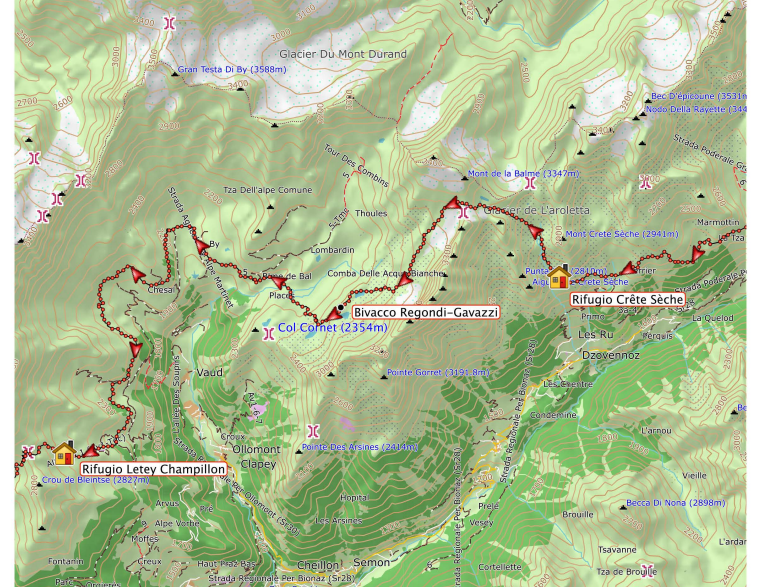


The runners at the front of the pack followed the pre-determined route (like Paul Tierney in 2023) while others ran the contigency route.

This makes analysis more difficult because the use of category order can not be applied and more reliance is put on the timestamp. However, as seen with TOR330, this is not always accurate. However, this is the last reserve. 


In [37]:
TOR450[['Name',
        'aid_stations',
        'Time', 
        'Year', 'Status']][(TOR450['aid_stations'].str.contains('Oyace')) &
                           (TOR450['Status'] == True) 
                          ].reset_index(drop =  True)

Name aid_stations                       Time  Year Status
0           Kuchimi Taro        Oyace  2023-09-14T06:03:39+02:00  2023   True
1            Pasta Dario    Oyace OUT  2023-09-14T09:55:50+02:00  2023   True
2            Pasta Dario        Oyace  2023-09-14T09:27:18+02:00  2023   True
3            Puit Javier    Oyace OUT  2023-09-14T13:32:21+02:00  2023   True
4            Puit Javier        Oyace  2023-09-14T12:42:06+02:00  2023   True
..                   ...          ...                        ...   ...    ...
179          Raso Andrea        Oyace  2024-09-13T03:52:26+02:00  2024   True
180         Milani Diego        Oyace  2024-09-13T03:52:22+02:00  2024   True
181         Duranti Luca        Oyace  2024-09-12T23:51:48+02:00  2024   True
182  Giacchetta Stephane        Oyace  2024-09-13T03:05:06+02:00  2024   True
183       Shao Sebastien        Oyace  2024-09-13T03:42:51+02:00  2024   True

[184 rows x 5 columns]

In [38]:
TOR450[['Name',
        'aid_stations', 
        'Time',
        'Year', 'Status']][(TOR450['aid_stations'].str.contains('Ollomont')) &
                           (TOR450['Status'] == True)] .reset_index(drop = True)

Name  aid_stations                       Time  Year Status
0  Flavelle Erika  Ollomont OUT  2024-09-13T07:13:06+02:00  2024   True
1  Flavelle Erika   Ollomont IN  2024-09-13T05:35:51+02:00  2024   True

### Weather Conditions 2023

In [39]:
TOR450[['Name',
        'aid_stations', 
        'Timestamp',
        'Year', 'Status']][(TOR450['Name'].str.contains('Tierney Paul'))&
                           (TOR450['Year'].str.contains('2023'))
                          ].sort_values(by = 'Timestamp', ascending  = True)

Name                  aid_stations            Timestamp  Year  \
5432  Tierney Paul                         START  2023-09-08T19:46:28  2023   
5431  Tierney Paul        Rifugio Maison Vieille  2023-09-08T21:00:08  2023   
5430  Tierney Paul            Rifugio Elisabetta  2023-09-08T22:39:53  2023   
5429  Tierney Paul              Rifugio Deffeyes  2023-09-09T03:01:42  2023   
5428  Tierney Paul          Rifugio degli Angeli  2023-09-09T09:20:18  2023   
5427  Tierney Paul                 Rifugio Bezzi  2023-09-09T13:46:21  2023   
5426  Tierney Paul              Rifugio Benevolo  2023-09-09T17:41:56  2023   
5425  Tierney Paul                Rifugio Savoia  2023-09-09T21:01:18  2023   
5424  Tierney Paul  Rifugio Vittorio Emanuele II  2023-09-10T00:27:29  2023   
5423  Tierney Paul                Rifugio Chabod  2023-09-10T03:33:44  2023   
5422  Tierney Paul                 Rifugio Sella  2023-09-10T08:51:30  2023   
5421  Tierney Paul                     Cogne OUT  2023-09-10T13:03:53  2023   
5420  Tierney Paul               Rifugio Grauson  2023-09-10T15:13:05  2023   
5419  Tierney Paul               Rifugio Miserin  2023-09-10T18:26:00  2023   
5418  Tierney Paul              Dortoir Retempio  2023-09-11T02:07:04  2023   
5417  Tierney Paul                 Rifugio Bonze  2023-09-11T06:43:05  2023   
5416  Tierney Paul                     Donnas IN  2023-09-11T09:22:33  2023   
5415  Tierney Paul                    Donnas OUT  2023-09-11T10:09:28  2023   
5414  Tierney Paul                  Rifugio Coda  2023-09-11T16:23:58  2023   
5413  Tierney Paul           Rifugio della Barma  2023-09-11T19:21:48  2023   
5412  Tierney Paul                   Lago Chiaro  2023-09-11T21:30:29  2023   
5411  Tierney Paul                 Niel La Gruba  2023-09-12T01:01:41  2023   
5410  Tierney Paul                           Loo  2023-09-12T05:11:37  2023   
5409  Tierney Paul                  Gressoney IN  2023-09-12T06:43:33  2023   
5408  Tierney Paul                 Gressoney OUT  2023-09-12T08:32:19  2023   
5407  Tierney Paul                Rifugio Sitten  2023-09-12T11:25:40  2023   
5406  Tierney Paul      Rifugio Guide di Frachey  2023-09-12T15:30:27  2023   
5405  Tierney Paul               Hotel Stambecco  2023-09-12T21:00:09  2023   
5404  Tierney Paul    Rifugio Perucca Vuillermoz  2023-09-13T04:38:56  2023   
5403  Tierney Paul              Rifugio Prarayer  2023-09-13T08:37:49  2023   
5402  Tierney Paul           Rifugio Crête Sèche  2023-09-13T13:15:07  2023   
5401  Tierney Paul            Rifugio Champillon  2023-09-13T20:19:44  2023   
5400  Tierney Paul               Ponteille Desot  2023-09-13T23:43:13  2023   
5399  Tierney Paul                  Hotel Italia  2023-09-14T03:17:06  2023   
5398  Tierney Paul              Rifugio Frassati  2023-09-14T07:12:07  2023   
5397  Tierney Paul          Pas Entre Deux Sauts  2023-09-14T09:10:27  2023   
5396  Tierney Paul              Monte de la Saxe  2023-09-14T10:40:26  2023   
5395  Tierney Paul                 Parco Bollino  2023-09-14T11:19:14  2023   
5394  Tierney Paul                        FINISH  2023-09-14T11:22:00  2023   

     Status  
5432   True  
5431   True  
5430   True  
5429   True  
5428   True  
5427   True  
5426   True  
5425   True  
5424   True  
5423   True  
5422   True  
5421   True  
5420   True  
5419   True  
5418   True  
5417   True  
5416   True  
5415   True  
5414   True  
5413   True  
5412   True  
5411   True  
5410   True  
5409   True  
5408   True  
5407   True  
5406   True  
5405   True  
5404   True  
5403   True  
5402   True  
5401   True  
5400   True  
5399   True  
5398   True  
5397   True  
5396   True  
5395   True  
5394   True

In [40]:
TOR450[['Name',
        'aid_stations', 
        'Timestamp',
        'Year', 'Status']][(TOR450['Name'].str.contains('Kuchimi Taro'))&
                           (TOR450['Year'].str.contains('2023'))
                          ].sort_values(by = 'Timestamp', ascending  = True)

Name                  aid_stations            Timestamp  Year  \
5593  Kuchimi Taro                         START  2023-09-08T19:44:33  2023   
5592  Kuchimi Taro        Rifugio Maison Vieille  2023-09-08T21:03:48  2023   
5591  Kuchimi Taro            Rifugio Elisabetta  2023-09-08T22:46:24  2023   
5590  Kuchimi Taro              Rifugio Deffeyes  2023-09-09T03:30:57  2023   
5589  Kuchimi Taro          Rifugio degli Angeli  2023-09-09T10:06:07  2023   
5588  Kuchimi Taro                 Rifugio Bezzi  2023-09-09T14:22:54  2023   
5587  Kuchimi Taro              Rifugio Benevolo  2023-09-09T17:33:07  2023   
5586  Kuchimi Taro                Rifugio Savoia  2023-09-09T20:47:49  2023   
5585  Kuchimi Taro  Rifugio Vittorio Emanuele II  2023-09-10T02:35:57  2023   
5584  Kuchimi Taro                Rifugio Chabod  2023-09-10T04:27:22  2023   
5583  Kuchimi Taro                 Rifugio Sella  2023-09-10T09:51:53  2023   
5582  Kuchimi Taro                     Cogne OUT  2023-09-10T13:49:24  2023   
5581  Kuchimi Taro               Rifugio Grauson  2023-09-10T16:30:16  2023   
5580  Kuchimi Taro               Rifugio Miserin  2023-09-10T20:29:46  2023   
5579  Kuchimi Taro              Dortoir Retempio  2023-09-11T10:02:47  2023   
5578  Kuchimi Taro                 Rifugio Bonze  2023-09-11T14:08:05  2023   
5577  Kuchimi Taro                     Donnas IN  2023-09-11T16:31:03  2023   
5576  Kuchimi Taro                    Donnas OUT  2023-09-11T21:10:37  2023   
5575  Kuchimi Taro                  Rifugio Coda  2023-09-12T04:51:35  2023   
5574  Kuchimi Taro           Rifugio della Barma  2023-09-12T07:44:03  2023   
5573  Kuchimi Taro                   Lago Chiaro  2023-09-12T09:29:24  2023   
5572  Kuchimi Taro                 Niel La Gruba  2023-09-12T12:40:07  2023   
5571  Kuchimi Taro                           Loo  2023-09-12T16:11:44  2023   
5570  Kuchimi Taro                 Gressoney OUT  2023-09-12T22:03:41  2023   
5569  Kuchimi Taro                Rifugio Sitten  2023-09-13T01:22:43  2023   
5568  Kuchimi Taro      Rifugio Guide di Frachey  2023-09-13T07:04:50  2023   
5567  Kuchimi Taro               Hotel Stambecco  2023-09-13T12:24:44  2023   
5566  Kuchimi Taro    Rifugio Perucca Vuillermoz  2023-09-13T19:03:41  2023   
5565  Kuchimi Taro              Rifugio Prarayer  2023-09-13T21:55:13  2023   
5564  Kuchimi Taro                         Oyace  2023-09-14T06:03:39  2023   
5563  Kuchimi Taro                    Bruson Arp  2023-09-14T09:01:02  2023   
5562  Kuchimi Taro                    Col Brison  2023-09-14T09:43:31  2023   
5561  Kuchimi Taro            Rifugio Champillon  2023-09-14T14:32:04  2023   
5560  Kuchimi Taro               Ponteille Desot  2023-09-14T16:51:22  2023   
5559  Kuchimi Taro                  Hotel Italia  2023-09-14T23:43:25  2023   
5558  Kuchimi Taro              Rifugio Frassati  2023-09-15T03:12:24  2023   
5557  Kuchimi Taro          Pas Entre Deux Sauts  2023-09-15T05:39:24  2023   
5556  Kuchimi Taro              Monte de la Saxe  2023-09-15T07:34:15  2023   
5555  Kuchimi Taro                 Parco Bollino  2023-09-15T08:12:39  2023   
5554  Kuchimi Taro                        FINISH  2023-09-15T08:15:27  2023   

     Status  
5593   True  
5592   True  
5591   True  
5590   True  
5589   True  
5588   True  
5587   True  
5586   True  
5585   True  
5584   True  
5583   True  
5582   True  
5581   True  
5580   True  
5579   True  
5578   True  
5577   True  
5576   True  
5575   True  
5574   True  
5573   True  
5572   True  
5571   True  
5570   True  
5569   True  
5568   True  
5567   True  
5566   True  
5565   True  
5564   True  
5563   True  
5562   True  
5561   True  
5560   True  
5559   True  
5558   True  
5557   True  
5556   True  
5555   True  
5554   True

### Weather Conditions 2024

In [41]:
TOR450[['Name',
        'aid_stations', 
        'Timestamp',
        'Year', 'Status']][(TOR450['Name'].str.contains('Pettinato Filippo'))&
                           (TOR450['Year'].str.contains('2024'))
                          ].sort_values(by = 'Timestamp', ascending  = True)

Name                  aid_stations            Timestamp  \
12828  Pettinato Filippo                         START  2024-09-06T19:49:26   
12827  Pettinato Filippo        Rifugio Maison Vieille  2024-09-06T21:15:35   
12826  Pettinato Filippo            Rifugio Elisabetta  2024-09-06T23:19:29   
12825  Pettinato Filippo              Rifugio Deffeyes  2024-09-07T06:03:13   
12824  Pettinato Filippo          Rifugio degli Angeli  2024-09-07T13:52:38   
12823  Pettinato Filippo                 Rifugio Bezzi  2024-09-07T19:27:25   
12822  Pettinato Filippo                Rifugio Savoia  2024-09-08T04:22:43   
12821  Pettinato Filippo  Rifugio Vittorio Emanuele II  2024-09-08T09:43:19   
12820  Pettinato Filippo                Rifugio Chabod  2024-09-08T11:48:51   
12819  Pettinato Filippo                 Rifugio Sella  2024-09-08T18:33:34   
12818  Pettinato Filippo                      Cogne IN  2024-09-08T22:50:07   
12817  Pettinato Filippo                     Cogne OUT  2024-09-09T01:49:04   
12816  Pettinato Filippo               Rifugio Grauson  2024-09-09T04:55:55   
12815  Pettinato Filippo               Rifugio Miserin  2024-09-09T11:01:26   
12814  Pettinato Filippo              Dortoir Retempio  2024-09-09T21:49:08   
12813  Pettinato Filippo                 Rifugio Bonze  2024-09-10T03:58:14   
12812  Pettinato Filippo                     Donnas IN  2024-09-10T08:37:04   
12811  Pettinato Filippo                  Rifugio Coda  2024-09-10T18:39:32   
12810  Pettinato Filippo                 Niel La Gruba  2024-09-11T06:59:54   
12809  Pettinato Filippo                           Loo  2024-09-11T12:08:52   
12808  Pettinato Filippo                  Gressoney IN  2024-09-11T13:42:34   
12807  Pettinato Filippo                 Gressoney OUT  2024-09-11T15:21:35   
12806  Pettinato Filippo                Rifugio Sitten  2024-09-11T18:58:24   
12805  Pettinato Filippo      Rifugio Guide di Frachey  2024-09-12T01:47:57   
12804  Pettinato Filippo               Hotel Stambecco  2024-09-12T09:14:33   
12803  Pettinato Filippo    Rifugio Perucca Vuillermoz  2024-09-12T19:32:07   
12802  Pettinato Filippo              Rifugio Prarayer  2024-09-12T20:38:28   
12801  Pettinato Filippo                         Oyace  2024-09-13T03:52:37   
12800  Pettinato Filippo                    Bruson Arp  2024-09-13T07:13:58   
12799  Pettinato Filippo                    Col Brison  2024-09-13T08:05:37   
12798  Pettinato Filippo                  Hotel Italia  2024-09-13T22:47:44   
12797  Pettinato Filippo              Rifugio Frassati  2024-09-14T05:36:46   
12796  Pettinato Filippo          Pas Entre Deux Sauts  2024-09-14T10:22:38   
12795  Pettinato Filippo              Monte de la Saxe  2024-09-14T12:27:16   
12794  Pettinato Filippo                        FINISH  2024-09-14T13:43:59   

       Year Status  
12828  2024   True  
12827  2024   True  
12826  2024   True  
12825  2024   True  
12824  2024   True  
12823  2024   True  
12822  2024   True  
12821  2024   True  
12820  2024   True  
12819  2024   True  
12818  2024   True  
12817  2024   True  
12816  2024   True  
12815  2024   True  
12814  2024   True  
12813  2024   True  
12812  2024   True  
12811  2024   True  
12810  2024   True  
12809  2024   True  
12808  2024   True  
12807  2024   True  
12806  2024   True  
12805  2024   True  
12804  2024   True  
12803  2024   True  
12802  2024   True  
12801  2024   True  
12800  2024   True  
12799  2024   True  
12798  2024   True  
12797  2024   True  
12796  2024   True  
12795  2024   True  
12794  2024   True

In [42]:
# has OLLOMONT!!!
TOR450[['Name',
        'aid_stations', 
        'Timestamp',
        'Year', 'Status']][(TOR450['Name'].str.contains('Flavelle Erika'))&
                           (TOR450['Year'].str.contains('2024'))
                          ].sort_values(by = 'Timestamp', ascending  = True)

Name                  aid_stations            Timestamp  \
12060  Flavelle Erika                         START  2024-09-06T19:50:05   
12059  Flavelle Erika        Rifugio Maison Vieille  2024-09-06T21:13:02   
12058  Flavelle Erika            Rifugio Elisabetta  2024-09-06T23:08:19   
12057  Flavelle Erika              Rifugio Deffeyes  2024-09-07T05:10:26   
12056  Flavelle Erika          Rifugio degli Angeli  2024-09-07T12:31:48   
12055  Flavelle Erika                 Rifugio Bezzi  2024-09-07T17:36:07   
12054  Flavelle Erika              Rifugio Benevolo  2024-09-07T21:06:33   
12053  Flavelle Erika                Rifugio Savoia  2024-09-08T00:51:23   
12052  Flavelle Erika  Rifugio Vittorio Emanuele II  2024-09-08T06:38:39   
12051  Flavelle Erika                Rifugio Chabod  2024-09-08T08:39:25   
12050  Flavelle Erika                 Rifugio Sella  2024-09-08T14:58:48   
12049  Flavelle Erika                      Cogne IN  2024-09-08T17:59:15   
12048  Flavelle Erika                     Cogne OUT  2024-09-08T19:27:25   
12047  Flavelle Erika               Rifugio Grauson  2024-09-08T21:53:44   
12046  Flavelle Erika               Rifugio Miserin  2024-09-09T03:14:05   
12045  Flavelle Erika              Dortoir Retempio  2024-09-09T12:27:07   
12044  Flavelle Erika                 Rifugio Bonze  2024-09-09T16:49:02   
12043  Flavelle Erika                     Donnas IN  2024-09-09T19:26:50   
12042  Flavelle Erika                    Donnas OUT  2024-09-09T22:06:19   
12041  Flavelle Erika                  Rifugio Coda  2024-09-10T06:35:49   
12040  Flavelle Erika           Rifugio della Barma  2024-09-10T09:43:32   
12039  Flavelle Erika                 Niel La Gruba  2024-09-10T16:54:51   
12038  Flavelle Erika                           Loo  2024-09-10T20:21:42   
12037  Flavelle Erika                  Gressoney IN  2024-09-10T22:17:35   
12036  Flavelle Erika                 Gressoney OUT  2024-09-11T03:07:41   
12035  Flavelle Erika                Rifugio Sitten  2024-09-11T07:34:00   
12034  Flavelle Erika      Rifugio Guide di Frachey  2024-09-11T14:12:14   
12033  Flavelle Erika               Hotel Stambecco  2024-09-11T21:06:29   
12032  Flavelle Erika    Rifugio Perucca Vuillermoz  2024-09-12T09:03:41   
12031  Flavelle Erika              Rifugio Prarayer  2024-09-12T12:33:49   
12030  Flavelle Erika           Rifugio Crête Sèche  2024-09-12T18:23:02   
12029  Flavelle Erika                         Oyace  2024-09-12T23:29:59   
12028  Flavelle Erika                    Bruson Arp  2024-09-13T02:25:55   
12027  Flavelle Erika                    Col Brison  2024-09-13T03:18:17   
12026  Flavelle Erika                   Berio Damon  2024-09-13T04:53:10   
12025  Flavelle Erika                   Ollomont IN  2024-09-13T05:35:51   
12024  Flavelle Erika                  Ollomont OUT  2024-09-13T07:13:06   
12023  Flavelle Erika            Rifugio Champillon  2024-09-13T09:40:10   
12022  Flavelle Erika               Ponteille Desot  2024-09-13T13:49:13   
12021  Flavelle Erika                  Hotel Italia  2024-09-13T18:05:03   
12020  Flavelle Erika              Rifugio Frassati  2024-09-13T23:45:09   
12019  Flavelle Erika          Pas Entre Deux Sauts  2024-09-14T03:56:50   
12018  Flavelle Erika              Monte de la Saxe  2024-09-14T06:38:01   
12017  Flavelle Erika                        FINISH  2024-09-14T08:15:06   

       Year Status  
12060  2024   True  
12059  2024   True  
12058  2024   True  
12057  2024   True  
12056  2024   True  
12055  2024   True  
12054  2024   True  
12053  2024   True  
12052  2024   True  
12051  2024   True  
12050  2024   True  
12049  2024   True  
12048  2024   True  
12047  2024   True  
12046  2024   True  
12045  2024   True  
12044  2024   True  
12043  2024   True  
12042  2024   True  
12041  2024   True  
12040  2024   True  
12039  2024   True  
12038  2024   True  
12037  2024   True  
12036  2024   True  
12035  2024   True  
12034  2024   True  
12033  2

In [43]:
# has OLLOMONT!!!
erika_df = TOR450[['Name',
        'aid_stations', 
        'Timestamp',
        'Year', 'Status']][(TOR450['Name'].str.contains('Flavelle Erika'))&
                           (TOR450['Year'].str.contains('2024'))
                          ].sort_values(by = 'Timestamp', ascending  = True)


list(erika_df['aid_stations'].unique())
# Used to create weather_contigency_route order

['START',
 'Rifugio Maison Vieille',
 'Rifugio Elisabetta',
 'Rifugio Deffeyes',
 'Rifugio degli Angeli',
 'Rifugio Bezzi',
 'Rifugio Benevolo',
 'Rifugio Savoia',
 'Rifugio Vittorio Emanuele II',
 'Rifugio Chabod',
 'Rifugio Sella',
 'Cogne IN',
 'Cogne OUT',
 'Rifugio Grauson',
 'Rifugio Miserin',
 'Dortoir Retempio',
 'Rifugio Bonze',
 'Donnas IN',
 'Donnas OUT',
 'Rifugio Coda',
 'Rifugio della Barma',
 'Niel La Gruba',
 'Loo',
 'Gressoney IN',
 'Gressoney OUT',
 'Rifugio Sitten',
 'Rifugio Guide di Frachey',
 'Hotel Stambecco',
 'Rifugio Perucca Vuillermoz',
 'Rifugio Prarayer',
 'Rifugio Crête Sèche',
 'Oyace',
 'Bruson Arp',
 'Col Brison',
 'Berio Damon',
 'Ollomont IN',
 'Ollomont OUT',
 'Rifugio Champillon',
 'Ponteille Desot',
 'Hotel Italia',
 'Rifugio Frassati',
 'Pas Entre Deux Sauts',
 'Monte de la Saxe',
 'FINISH']

### Other places anomalies 
US runner Amy Sproston probably decided to call it a day in Rifugio Sitten, but decided to run down to Champoluc, and then got a timestamp in Courmayeur (to make sure she is safely in Courmayeur - cleaning is always easier than trying to find a missing runner).
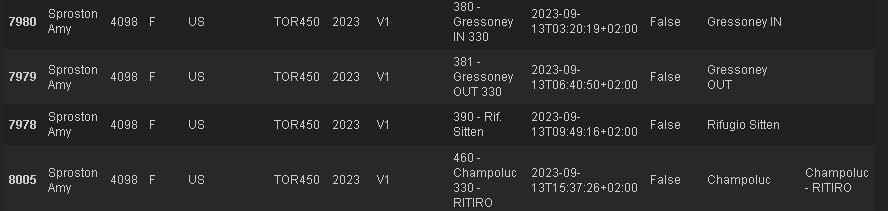

Other places that are not on the course that people DNFed at:
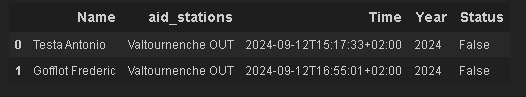


In [44]:
TOR450[(TOR450['Name'] == 'Sproston Amy') & (TOR450['Year'] == '2024')].sort_values(by = 'Timestamp', ascending  = True)

Name     Bib Sex Nationality    Race  Year Category  \
15045  Sproston Amy  4025.0   F          US  TOR450  2024       V2   
15044  Sproston Amy  4025.0   F          US  TOR450  2024       V2   
15043  Sproston Amy  4025.0   F          US  TOR450  2024       V2   
15042  Sproston Amy  4025.0   F          US  TOR450  2024       V2   
15041  Sproston Amy  4025.0   F          US  TOR450  2024       V2   

                           Place                       Time Status  \
15045                010 - START  2024-09-06T19:45:59+02:00  False   
15044  040 - Rif. Maison Vieille  2024-09-06T21:03:59+02:00  False   
15043      050 - Rif. Elisabetta  2024-09-06T22:42:53+02:00  False   
15042    060 - Rif. Deffeyes 450  2024-09-07T04:09:02+02:00  False   
15041    070 - Rif. degli Angeli  2024-09-07T11:50:05+02:00  False   

                 aid_stations RITIRIO            Timestamp  
15045                   START          2024-09-06T19:45:59  
15044  Rifugio Maison Vieille          2024-09-06T21:03:59  
15043      Rifugio Elisabetta          2024-09-06T22:42:53  
15042        Rifugio Deffeyes          2024-09-07T04:09:02  
15041    Rifugio degli Angeli          2024-09-07T11:50:05

In [45]:
TOR450[(TOR450['Name'] == 'Sproston Amy') & (TOR450['Year'] == '2024')].sort_values(by = 'Timestamp', ascending  = True)

Name     Bib Sex Nationality    Race  Year Category  \
15045  Sproston Amy  4025.0   F          US  TOR450  2024       V2   
15044  Sproston Amy  4025.0   F          US  TOR450  2024       V2   
15043  Sproston Amy  4025.0   F          US  TOR450  2024       V2   
15042  Sproston Amy  4025.0   F          US  TOR450  2024       V2   
15041  Sproston Amy  4025.0   F          US  TOR450  2024       V2   

                           Place                       Time Status  \
15045                010 - START  2024-09-06T19:45:59+02:00  False   
15044  040 - Rif. Maison Vieille  2024-09-06T21:03:59+02:00  False   
15043      050 - Rif. Elisabetta  2024-09-06T22:42:53+02:00  False   
15042    060 - Rif. Deffeyes 450  2024-09-07T04:09:02+02:00  False   
15041    070 - Rif. degli Angeli  2024-09-07T11:50:05+02:00  False   

                 aid_stations RITIRIO            Timestamp  
15045                   START          2024-09-06T19:45:59  
15044  Rifugio Maison Vieille          2024-09-06T21:03:59  
15043      Rifugio Elisabetta          2024-09-06T22:42:53  
15042        Rifugio Deffeyes          2024-09-07T04:09:02  
15041    Rifugio degli Angeli          2024-09-07T11:50:05

In [46]:
TOR450[['Name',
        'aid_stations', 
        'Time',
        'Year', 'Status']][(TOR450['aid_stations'].str.contains('Valtournenche', na = False)) ].reset_index(drop = True)

Name       aid_stations                       Time  Year Status
0     Testa Antonio  Valtournenche OUT  2024-09-12T15:17:33+02:00  2024  False
1  Gofflot Frederic  Valtournenche OUT  2024-09-12T16:55:01+02:00  2024  False

In [47]:
TOR450[(TOR450['Name'] == 'Testa Antonio') & 
       (TOR450['Year'] == '2024')].sort_values(by = 'Timestamp', ascending  = True)

Name     Bib Sex Nationality    Race  Year Category  \
13865  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13864  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13863  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13862  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13861  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13860  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13859  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13858  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13857  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13856  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13855  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13854  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13853  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13852  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13851  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13850  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13849  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13848  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13847  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13846  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13845  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13844  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13843  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13842  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13841  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13840  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13839  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   
13867  Testa Antonio  4172.0   M          IT  TOR450  2024       V2   

                                      Place                       Time Status  \
13865                           010 - START  2024-09-06T19:45:05+02:00  False   
13864             040 - Rif. Maison Vieille  2024-09-06T21:13:05+02:00  False   
13863                 050 - Rif. Elisabetta  2024-09-06T23:14:28+02:00  False   
13862               060 - Rif. Deffeyes 450  2024-09-07T06:11:10+02:00  False   
13861               070 - Rif. degli Angeli  2024-09-07T14:41:10+02:00  False   
13860                      080 - Rif. Bezzi  2024-09-07T20:37:53+02:00  False   
13859                     100 - Rif. Savoia  2024-09-08T06:57:04+02:00  False   
13858       110 - Rif. Vittorio Emanuele II  2024-09-08T11:05:46+02:00  False   
13857                     120 - Rif. Chabod  2024-09-08T13:36:59+02:00  False   
13856                  190 - Rif. Sella 450  2024-09-08T20:06:02+02:00  False   
13855                    200 - Cogne IN 450  2024-09-09T00:54:39+02:00  False   
13854                   201 - Cogne OUT 450  2024-09-09T02:47:53+02:00  False   
13853                    220 - Rif. Grauson  2024-09-09T06:00:49+02:00  False   
13852                    230 - Rif. Miserin  2024-09-09T10:50:11+02:00  False   
13851                270 - Dortoir Retempio  2024-09-09T20:50:26+02:00  False   
13850                      280 - Rif. Bonze  2024-09-10T02:29:41+02:00  False   
13849                   290 - Donnas IN 450  2024-09-10T06:23:38+02:00  False   
13848                  291 - Donnas OUT 450  2024-09-10T08:40:48+02:00  False   
13847                   320 - Rif. Coda 330  2024-09-10T16:27:16+02:00  False   
13846            330 - Rif. della Barma 450  2024-09-10T20:51:14+02:00  False   
13845               360 - Niel La Gruba 450  2024-09-11T08:09:07+02:00  False   
13844                             370 - Loo  2024-09-11T12:25:24+02:00  False   
13843                380 - Gressoney IN 450  2024-09-11T13:58:59+02:00  False   
13842       

In [48]:
TOR450[(TOR450['Name'] == 'Gofflot Frederic') & 
       (TOR450['Year'] == '2024')].sort_values(by = 'Timestamp', ascending  = True)

Name     Bib Sex Nationality    Race  Year Category  \
13894  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13893  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13892  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13891  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13890  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13889  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13888  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13887  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13886  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13885  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13884  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13883  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13882  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13881  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13880  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13879  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13878  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13877  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13876  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13875  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13874  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13873  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13872  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13871  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13870  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13869  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13868  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   
13896  Gofflot Frederic  4047.0   M          BE  TOR450  2024       V2   

                                      Place                       Time Status  \
13894                           010 - START  2024-09-06T19:38:39+02:00  False   
13893             040 - Rif. Maison Vieille  2024-09-06T21:14:43+02:00  False   
13892                 050 - Rif. Elisabetta  2024-09-06T23:17:31+02:00  False   
13891               060 - Rif. Deffeyes 450  2024-09-07T06:05:31+02:00  False   
13890               070 - Rif. degli Angeli  2024-09-07T14:19:13+02:00  False   
13889                      080 - Rif. Bezzi  2024-09-07T20:26:42+02:00  False   
13888                     100 - Rif. Savoia  2024-09-08T08:16:25+02:00  False   
13887       110 - Rif. Vittorio Emanuele II  2024-09-08T12:37:45+02:00  False   
13886                     120 - Rif. Chabod  2024-09-08T15:01:38+02:00  False   
13885                  190 - Rif. Sella 450  2024-09-08T22:02:38+02:00  False   
13884                    200 - Cogne IN 450  2024-09-09T04:09:25+02:00  False   
13883                   201 - Cogne OUT 450  2024-09-09T06:03:51+02:00  False   
13882                    220 - Rif. Grauson  2024-09-09T08:35:28+02:00  False   
13881                    230 - Rif. Miserin  2024-09-09T12:41:45+02:00  False   
13880                270 - Dortoir Retempio  2024-09-09T22:17:03+02:00  False   
13879                      280 - Rif. Bonze  2024-09-10T04:39:09+02:00  False   
13878                   290 - Donnas IN 450  2024-09-10T07:57:45+02:00  False   
13877                  291 - Donnas OUT 450  2024-09-10T09:30:12+02:00  False   
13876                   320 - Rif. Coda 330  2024-09-10T17:45:52+02:00  False   
13875            330 - Rif. della Barma 450  2024-09-10T21:23:56+02:00  False   
13874               360 - Niel La Gruba 450  2024-09-11T07:45:37+02:00  False   
13873                             370 - Loo  2024-09-11T11:10:21+02:00  False   
13872    

### Start Line Issues

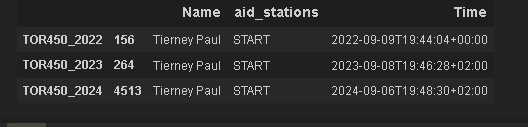

START times are all over the place and this is a MAJOR issue! 
It is important because if the start is not cleaned, it will affet the race finishing time and all the durations in between. 

### Especially 2021!!!
Some runners in 2021 had no starting times!

#### SOLUTION
1) Made a new TIME column from DUV dates

2) added start times based on the wave (based on the bib)


In [49]:
# Look at this runner who had no starting times!
TOR450[(TOR450['Name'] == 'Papi Luca') &
       (TOR450['Year'] == '2021')].sort_values(by = 'Timestamp', ascending = True)

Name     Bib Sex Nationality    Race  Year Category  \
7   Papi Luca  4001.0   M          FR  TOR450  2021       V1   
35  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
34  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
33  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
32  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
31  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
30  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
29  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
28  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
27  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
26  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
25  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
24  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
23  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
22  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
21  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
20  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
19  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
18  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
17  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
16  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
15  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
14  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
13  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
12  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
11  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
10  Papi Luca  4001.0   M          FR  TOR450  2021       V1   
9   Papi Luca  4001.0   M          FR  TOR450  2021       V1   
8   Papi Luca  4001.0   M          FR  TOR450  2021       V1   
6   Papi Luca  4001.0   M          FR  TOR450  2021       V1   
5   Papi Luca  4001.0   M          FR  TOR450  2021       V1   
4   Papi Luca  4001.0   M          FR  TOR450  2021       V1   
3   Papi Luca  4001.0   M          FR  TOR450  2021       V1   
2   Papi Luca  4001.0   M          FR  TOR450  2021       V1   
1   Papi Luca  4001.0   M          FR  TOR450  2021       V1   
0   Papi Luca  4001.0   M          FR  TOR450  2021       V1   

                                         Place                       Time  \
7                430 - Rif. Prarayer|359|30170  2018-06-27T01:39:21+00:00   
35           040 - Rif. Maison Vieille|5.7|866  2021-09-10T21:02:52+00:00   
34             050 - Rif. Elisabetta|15.6|1579  2021-09-10T22:47:40+00:00   
33             070 - Rif. degli Angeli|66|5976  2021-09-11T10:25:34+00:00   
32                    080 - Rif. Bezzi|87|7046  2021-09-11T14:58:41+00:00   
31                 090 - Rif. Benevolo|98|7964  2021-09-11T17:53:42+00:00   
30                  100 - Rif. Savoia|108|8882  2021-09-11T20:28:53+00:00   
29    110 - Rif. Vittorio Emanuele II|121|9767  2021-09-11T23:54:38+00:00   
28                 120 - Rif. Chabod|127|10111  2021-09-12T02:01:19+00:00   
27              190 - Rif. Sella 450|142|11543  2021-09-12T08:02:26+00:00   
26               200 - Cogne 330 IN|110.5|9616  2021-09-12T12:26:30+00:00   
25              201 - Cogne 330 OUT|110.5|9616  2021-09-12T13:14:59+00:00   
24                220 - Rif. Grauson|168|12500  2021-09-12T15:32:43+00:00   
23                230 - Rif. Miserin|180|13955  2021-09-12T18:53:31+00:00   
22          240 - Rif. Dondena 330|132.9|11303  2021-09-12T19:38:46+00:00   
21               270 - Dortoir Crest|206|15659  2021-09-13T04:54:05+00:00   
20                  280 - Rif. Bonze|217|17432  2021-09-13T10:00:53+00:00   
19             290 - Donnas 330 IN|156.3|12242  2021-09-13T12:18:47+00:00   
18            291 - Donnas 330 OUT|156.3|12242  2021-09-13T13:04:56+00:00   
17             320 - Rif. Coda 330|174.5|15024  2021-09-13T19:08:30+00:00   
16        330 - Rif. de

In [50]:
TOR450.columns

Index(['Name', 'Bib', 'Sex', 'Nationality', 'Race', 'Year', 'Category',
       'Place', 'Time', 'Status', 'aid_stations', 'RITIRIO', 'Timestamp'],
      dtype='object')

In [51]:
pivoted_TOR450[['Year','Name', 'Status', 'START', 'FINISH']][pivoted_TOR450['Year'] == '2021']

aid_stations  Year                       Name  Status                START  \
10            2021       Alvarez Perez Miguel    True  2021-09-10T19:47:22   
11            2021              Anderson John   False                  NaN   
15            2021  Angel Andrade Julio Cesar   False                  NaN   
36            2021           Bedhet Guillaume    True                  NaN   
38            2021           Belin Christophe   False                  NaN   
56            2021    Bombenger Jean Francois    True                  NaN   
71            2021          Buche Jean Pascal   False  2021-09-10T19:39:53   
78            2021           Buzzolan Corrado   False                  NaN   
89            2021             Case Stephanie    True                  NaN   
109           2021           Claudiu Beletoiu    True                  NaN   
152           2021             Dufour Olivier   False                  NaN   
161           2021            Eric Jeanclaude   False                  NaN   
172           2021              Ferrari Fabio   False  2021-09-10T19:42:18   
181           2021         Fohrmeister Volker    True                  NaN   
192           2021        Gabioud Jules Henry    True                  NaN   
193           2021               Gaetani Elio   False  2021-09-10T19:42:28   
195           2021           Gallizia Michele   False                  NaN   
214           2021          Gonzalez Fernando    True                  NaN   
247           2021             Heideck Daniel    True                  NaN   
260           2021             Hjelmer Magnus    True                  NaN   
263           2021           Hjelmstrom Peter   False                  NaN   
265           2021             Holst Benjamin   False                  NaN   
274           2021            Iotti Sebastien   False                  NaN   
276           2021           Isernia Ruggiero    True                  NaN   
280           2021                 Jan Kriska   False                  NaN   
282           2021               Javega David    True                  NaN   
284           2021                Jose Urizar   False                  NaN   
303           2021             L Heureux Yvan   False                  NaN   
308           2021               Lauret Denis    True                  NaN   
323           2021       Macchiavello Giorgio    True                  NaN   
340           2021      Marzotto Ita Emanuela   False                  NaN   
341           2021            Matthieu Moreau    True                  NaN   
348           2021            Minoggio Sergio    True                  NaN   
360           2021                 Neale Matt    True  2021-09-10T19:35:29   
375           2021          Olivson Oleksandr    True                  NaN   
384           2021                  Papi Luca    True                  NaN   
397           2021             Petersen Heine   False                  NaN   
399           2021             Philippe Perez    True                  NaN   
406           2021              Plavan Marina    True                  NaN   
411           2021            Ponce Sebastien    True                  NaN   
422           2021             Puiati Stefano   False                  NaN   
441           2021             Raucy Emmanuel    True                  NaN   
443           2021             Renson Patrice   False                  NaN   
450           2021              Rinaldo Alfio   False                  NaN   
455           2021           Romboletti Oscar   False                  NaN   
469           2021         Sanguineti Charlie   False                  NaN   
478           2021             Sciebura Pawel    True                  NaN   
483           2021                Simao Diogo    True                  NaN   
501           2021            Stephane Poulin    True                  NaN   
502           2021            Sylvain Oeillet    True                  NaN   
506           2021    

In [52]:
file = f'TORX DUV dates/TORX_duv_dates_df.xlsx'
dates_duv_df = pd.read_excel(file)

# Drop the intermediate columns if they're no longer needed
dates_duv_df = dates_duv_df.drop(columns=['Day_of_Week Start_Date'])    

# making sure both columns are years!
pivoted_TOR450['Year'] = pivoted_TOR450['Year'].astype('str')
dates_duv_df['Year'] = dates_duv_df['Year'].astype('str')

# have I dropped any rows?
print( pivoted_TOR450.shape)

# Merging on two columns: 'Race' and 'Year'
pivoted_TOR450_dates = pd.merge( pivoted_TOR450, dates_duv_df, on=['Race', 'Year'], how='inner')

# have I dropped any rows?
print( pivoted_TOR450_dates.shape)

pivoted_TOR450_dates['Start Date'] = pd.to_datetime(pivoted_TOR450_dates['Start Date'])
pivoted_TOR450_dates['FINISH'] = pd.to_datetime(pivoted_TOR450_dates['FINISH'])

# Calculate Duration
pivoted_TOR450_dates['Duration'] = pivoted_TOR450_dates['FINISH'] - pivoted_TOR450_dates['Start Date'] 

# # Sort the DataFrame by the 'Duration' column
# pivoted_TOR330_dates = pivoted_TOR330_dates.sort_values(by='Duration')
pivoted_TOR450_dates.head()

(557, 66)
(557, 67)


Name   Bib Sex Nationality Category    Race  Year  \
0                  Adam Eric  4052   M          AT       V1  TOR450  2022   
1               Ador Thierry  4005   M          FR       V2  TOR450  2022   
2           Ageorges Fabrice  4025   M          FR       V1  TOR450  2022   
3              Anderson John  4072   M          US       V1  TOR450  2022   
4  Angel Andrade Julio Cesar  4137   M          MX       V2  TOR450  2022   

   Status Berio Damon               Bosses  ...        Rifugio Sella  \
0    True         NaN                  NaN  ...  2022-09-11T19:54:33   
1   False         NaN                  NaN  ...  2022-09-11T15:28:33   
2   False         NaN                  NaN  ...  2022-09-11T18:23:02   
3    True         NaN                  NaN  ...  2022-09-11T12:17:21   
4   False         NaN  2022-09-17T09:50:30  ...  2022-09-11T16:01:00   

        Rifugio Sitten Rifugio Vittorio Emanuele II Rifugio degli Angeli  \
0  2022-09-14T16:45:04          2022-09-11T11:05:53  2022-09-10T12:51:58   
1                  NaN          2022-09-11T04:53:32  2022-09-10T11:46:06   
2  2022-09-14T19:22:42          2022-09-11T09:15:54  2022-09-10T13:19:58   
3  2022-09-14T03:19:22          2022-09-11T02:13:48  2022-09-10T11:04:05   
4  2022-09-14T16:21:02          2022-09-11T07:08:40  2022-09-10T12:09:41   

   Rifugio della Barma                START Sassa Valtournenche OUT  \
0  2022-09-13T21:06:44  2022-09-09T19:37:18   NaN               NaN   
1                  NaN  2022-09-09T19:43:59   NaN               NaN   
2  2022-09-13T20:36:56  2022-09-09T19:43:20   NaN               NaN   
3  2022-09-13T11:06:55  2022-09-09T19:43:14   NaN               NaN   
4  2022-09-13T18:23:29  2022-09-09T19:49:30   NaN               NaN   

           Start Date        Duration  
0 2022-09-09 20:00:00 7 days 13:01:00  
1 2022-09-09 20:00:00             NaT  
2 2022-09-09 20:00:00             NaT  
3 2022-09-09 20:00:00 6 days 17:33:50  
4 2022-09-09 20:00:00             NaT  

[5 rows x 68 columns]

In [53]:
pivoted_TOR450_dates[['Name', 'Bib', 'Sex', 'Nationality', 'Category', 'Race', 'Year',
       'Status', 'Start Date', 'FINISH', 'Duration']][pivoted_TOR450_dates['Year'] == '2021']

Name   Bib Sex Nationality Category    Race  Year  \
501       Alvarez Perez Miguel  4050   M          ES       V2  TOR450  2021   
502              Anderson John  4009   M          US       V1  TOR450  2021   
503  Angel Andrade Julio Cesar  4044   M          MX       V2  TOR450  2021   
504           Bedhet Guillaume  4024   M          FR       V1  TOR450  2021   
505           Belin Christophe  4025   M          FR       V2  TOR450  2021   
506    Bombenger Jean Francois  4048   M          FR       V1  TOR450  2021   
507          Buche Jean Pascal  4030   M          BE       V1  TOR450  2021   
508           Buzzolan Corrado  4059   M          IT       V2  TOR450  2021   
509             Case Stephanie  4006   F          FR      SEN  TOR450  2021   
510           Claudiu Beletoiu  4027   M          RO      SEN  TOR450  2021   
511             Dufour Olivier  4036   M          MC       V1  TOR450  2021   
512            Eric Jeanclaude  4056   M          FR       V2  TOR450  2021   
513              Ferrari Fabio  4055   M          IT       V2  TOR450  2021   
514         Fohrmeister Volker  4064   M          DE      SEN  TOR450  2021   
515        Gabioud Jules Henry  4015   M          CH      SEN  TOR450  2021   
516               Gaetani Elio  4058   M          IT      SEN  TOR450  2021   
517           Gallizia Michele  4062   M          IT       V2  TOR450  2021   
518          Gonzalez Fernando  4011   M          ES       V1  TOR450  2021   
519             Heideck Daniel  4042   M          DE      SEN  TOR450  2021   
520             Hjelmer Magnus  4040   M          SE       V1  TOR450  2021   
521           Hjelmstrom Peter  4018   M          SE       V1  TOR450  2021   
522             Holst Benjamin  4052   M          DK       V2  TOR450  2021   
523            Iotti Sebastien  4023   M          FR       V1  TOR450  2021   
524           Isernia Ruggiero  4021   M          IT       V2  TOR450  2021   
525                 Jan Kriska  4029   M          US       V2  TOR450  2021   
526               Javega David  4037   M          ES      SEN  TOR450  2021   
527                Jose Urizar  4051   M          GT       V2  TOR450  2021   
528             L Heureux Yvan  4010   M          CA       V1  TOR450  2021   
529               Lauret Denis  4065   M          FR       V1  TOR450  2021   
530       Macchiavello Giorgio  4031   M          IT       V2  TOR450  2021   
531      Marzotto Ita Emanuela  4008   F          IT       V2  TOR450  2021   
532            Matthieu Moreau  4019   M          FR       V1  TOR450  2021   
533            Minoggio Sergio  4017   M          IT       V2  TOR450  2021   
534                 Neale Matt  4004   M          GB       V1  TOR450  2021   
535          Olivson Oleksandr  4026   M          UA       V2  TOR450  2021   
536                  Papi Luca  4001   M          FR       V1  TOR450  2021   
537             Petersen Heine  4005   M          NO       V2  TOR450  2021   
538             Philippe Perez  4043   M          FR       V2  TOR450  2021   
539              Plavan Marina  4003   F          IT       V3  TOR450  2021   
540            Ponce Sebastien  4046   M          FR       V1  TOR450  2021   
541             Puiati Stefano  4020   M          IT       V2  TOR450  2021   
542             Raucy Emmanuel  4035   M          BE       V1  TOR450  2021   
543             Renson Patrice  4057   M          BE       V1  TOR450  2021   
544              Rinaldo Alfio  4045   M          IT       V3  TOR450  2021   
545           Romboletti Oscar  4038   M          IT       V3  TOR450  2021   
546         Sanguineti Charlie  4060   M          IT       V1  TOR450  2021   
547             Sciebura Pawel  4032   M          PL       V1  TOR450  2021   
548                Simao Diogo  4063   M          PT       V1  TOR450  2021   
549            Stephane Poulin  4012   M          CA       V2  TOR450  2021   
550            Sylvain Oeillet  4028   M          FR       V1  TOR450  2021 


### Other time issues - Time travel - 3 years!!
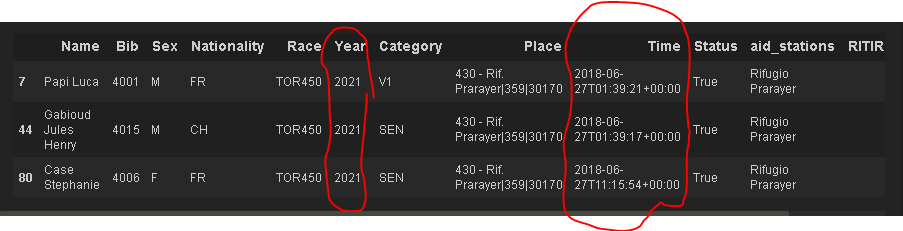

#### SOLUTION
1) change the timestamp to NAT

In [54]:
TOR450['Timestamp'] = pd.to_datetime(TOR450['Timestamp']) 

TOR450[(TOR450['aid_stations'] == 'Rifugio Prarayer') &
                       (TOR450['Timestamp'] <pd.to_datetime('2021-09-10 20:00:00'))]

Name     Bib Sex Nationality    Race  Year Category  \
7             Papi Luca  4001.0   M          FR  TOR450  2021       V1   
44  Gabioud Jules Henry  4015.0   M          CH  TOR450  2021      SEN   
80       Case Stephanie  4006.0   F          FR  TOR450  2021      SEN   

                            Place                       Time Status  \
7   430 - Rif. Prarayer|359|30170  2018-06-27T01:39:21+00:00   True   
44  430 - Rif. Prarayer|359|30170  2018-06-27T01:39:17+00:00   True   
80  430 - Rif. Prarayer|359|30170  2018-06-27T11:15:54+00:00   True   

        aid_stations RITIRIO           Timestamp  
7   Rifugio Prarayer         2018-06-27 01:39:21  
44  Rifugio Prarayer         2018-06-27 01:39:17  
80  Rifugio Prarayer         2018-06-27 11:15:54

In [55]:
TOR450.loc[(TOR450['aid_stations'] == 'Rifugio Prarayer') &
       (TOR450['Timestamp'] <pd.to_datetime('2021-09-10 20:00:00')), 'Timestamp'] = pd.NaT

## TOR450 DEM

In [56]:
TOR450_dem = pivoted_TOR450_dates[['Name', 'Bib', 'Sex', 'Nationality', 'Category', 'Race', 'Year',
       'Status', 'Duration']]


# Convert to timedelta and get total hours (handling NaT)
TOR450_dem['Duration_hours'] = pd.to_timedelta(
    TOR450_dem['Duration'], errors='coerce'
).dt.total_seconds() / 3600  # Convert seconds to hours

# Convert to timedelta and get total hours (handling NaT)
TOR450_dem['Duration_seconds'] = pd.to_timedelta(
    TOR450_dem['Duration'], errors='coerce'
).dt.total_seconds()



C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1843216237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dem['Duration_hours'] = pd.to_timedelta(
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1843216237.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dem['Duration_seconds'] = pd.to_timedelta(


### Examining Duration

In [57]:
TOR450_dem[~pd.isna(TOR450_dem['Duration']) &
           (TOR450_dem['Status'] == True)].reset_index(drop = True)

Name   Bib Sex Nationality Category    Race  Year  Status  \
0            Adam Eric  4052   M          AT       V1  TOR450  2022    True   
1        Anderson John  4072   M          US       V1  TOR450  2022    True   
2     Anthonioz Pierre  4014   M          FR       V1  TOR450  2022    True   
3        Arbel Yannick  4135   M          CH       V1  TOR450  2022    True   
4       Barmasse Piero  4016   M          IT       V2  TOR450  2022    True   
..                 ...   ...  ..         ...      ...     ...   ...     ...   
225    Sylvain Oeillet  4028   M          FR       V1  TOR450  2021    True   
226  Teuscher Christof  4014   M          US       V1  TOR450  2021    True   
227  Traina Christophe  4034   M          BE       V1  TOR450  2021    True   
228   Tribolo Philippe  4039   M          FR       V1  TOR450  2021    True   
229   Vincent Wendling  4047   M          FR       V2  TOR450  2021    True   

           Duration  Duration_hours  Duration_seconds  
0   7 days 13:01:00      181.016667          651660.0  
1   6 days 17:33:50      161.563889          581630.0  
2   7 days 13:14:15      181.237500          652455.0  
3   7 days 15:16:05      183.268056          659765.0  
4   6 days 19:40:51      163.680833          589251.0  
..              ...             ...               ...  
225 7 days 15:05:51      183.097500          659151.0  
226 7 days 15:01:05      183.018056          658865.0  
227 7 days 17:00:24      185.006667          666024.0  
228 7 days 16:24:31      184.408611          663871.0  
229 7 days 18:50:41      186.844722          672641.0  

[230 rows x 11 columns]

C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\3255039443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dem['Duration'] = pd.to_timedelta(TOR450_dem['Duration'])


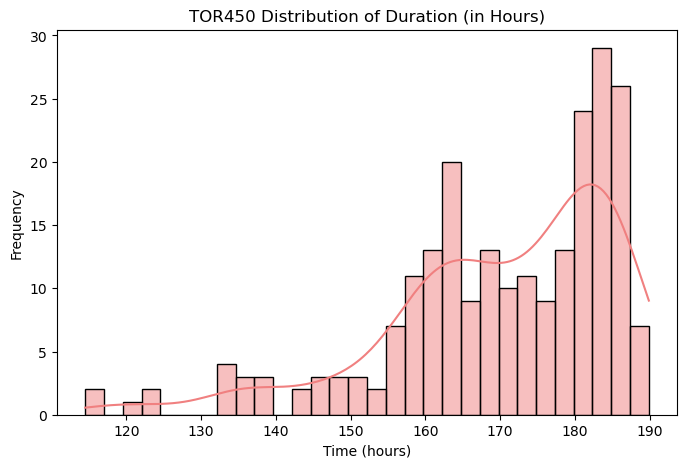

In [58]:
TOR450_dem['Duration'] = pd.to_timedelta(TOR450_dem['Duration'])

# Drop NaN values for histogram visualization
data_to_plot = TOR450_dem['Duration_hours'].dropna()
#     print(data_to_plot.head())
# print(data_to_plot['Name'].count())
# print(round(data_to_plot['Duration_hours'].min(), 2),' ', data_to_plot['Duration'].min())
# print(round(data_to_plot['Duration_hours'].max(), 2),' ', data_to_plot['Duration'].max())


# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(data_to_plot, kde=True, bins=30, color="lightcoral")
plt.ticklabel_format(style='plain', axis='x')
plt.title(f"TOR450 Distribution of Duration (in Hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Frequency")
plt.show()


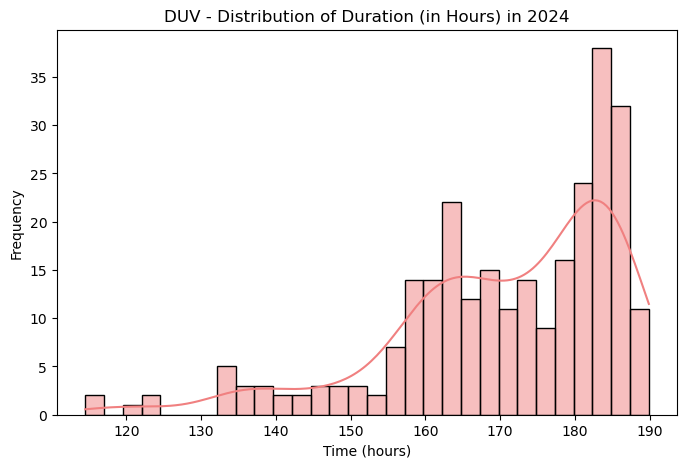

In [59]:
# Convert to timedelta and get total hours (handling NaT)
DUV_450['Duration_hours'] = pd.to_timedelta(
    DUV_450['Performance'], errors='coerce'
).dt.total_seconds() / 3600  # Convert seconds to hours


# Drop NaN values for histogram visualization
data_to_plot = DUV_450['Duration_hours'].dropna()
# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(data_to_plot, kde=True, bins=30, color="lightcoral")
plt.ticklabel_format(style='plain', axis='x')
plt.title(f"DUV - Distribution of Duration (in Hours) in {year}")
plt.xlabel("Time (hours)")
plt.ylabel("Frequency")
plt.show()
    

### Fixing the Start Date in long database 

Some runners didnt have 2021 START Date row in the LONG database so I had to add that row in and then pop it back into the full database

In [60]:
TORX_list = [ ]
TOR450 = TOR450[TOR450['aid_stations'] != 'START']
for year in years:
    
    TOR450_year_starters = TOR450[['Name', 'Bib', 'Sex', 
                                   'Nationality', 'Category',
                                   'Race', 'Year','Status']][TOR450['Year'] == year].drop_duplicates(keep = 'first')
    TOR450_year_starters['aid_stations'] = 'START'

    DUV_start_date = dates_duv_df['Start Date'][(dates_duv_df['Year'] == year) &
                (dates_duv_df['Race'] == 'TOR450')].values[0]
    print(year)
    print(DUV_start_date)

    TOR450_year_starters['Timestamp'] = DUV_start_date
    TORX_list.append(TOR450_year_starters)
    
TOR450_year_starters = pd.concat(TORX_list)

# Concatenate along columns (axis=1)
TOR450= pd.concat([TOR450, TOR450_year_starters])

# Look at this runner who had no starting times!
TOR450[(TOR450['Bib'] == '4063') &
       (TOR450['Year'] == '2021')].sort_values(by = 'Timestamp', ascending = True)


2021
2021-09-10T20:00:00.000000000
2022
2022-09-09T20:00:00.000000000
2023
2023-09-08T20:00:00.000000000
2024
2024-09-06T20:00:00.000000000


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\2980863821.py:21: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  TOR450= pd.concat([TOR450, TOR450_year_starters])


Empty DataFrame
Columns: [Name, Bib, Sex, Nationality, Race, Year, Category, Place, Time, Status, aid_stations, RITIRIO, Timestamp]
Index: []

In [61]:

# TOR450_fixed_start_date = [ ]
# for n, (year, unique_bib) in enumerate(
#     [(y, b) for y in ['2021', '2022', '2023', '2024'] 
#      for b in TOR450.query("Year == @y")['Bib'].unique()],
#     start=1):
    
#     bib_df = TOR450.query("Year == @year and Bib == @unique_bib")
    
#     DUV_start_date = dates_duv_df['Start Date'][(dates_duv_df['Year'] == year) &
#             (dates_duv_df['Race'] == 'TOR450')].values[0]
    
#     bib_df.loc[bib_df['aid_stations'] == 'START', 'Timestamp'] =DUV_start_date
#     TOR450_fixed_start_date.append(bib_df)
# TOR450_fixed_start_date = pd.concat(TOR450_fixed_start_date)
# TOR450_fixed_start_date.reset_index(drop = True, inplace = True)

In [62]:
TOR450[(TOR450['Name'] == 'Tierney Paul') &
                       (TOR450['aid_stations'] == 'START')]

Name     Bib Sex Nationality    Race  Year Category Place Time  \
1613   Tierney Paul  4063.0   M          IE  TOR450  2022      SEN   NaN  NaN   
5394   Tierney Paul  4163.0   M          IE  TOR450  2023       V1   NaN  NaN   
15088  Tierney Paul  4104.0   M          IE  TOR450  2024       V1   NaN  NaN   

      Status aid_stations RITIRIO           Timestamp  
1613    True        START     NaN 2022-09-09 20:00:00  
5394    True        START     NaN 2023-09-08 20:00:00  
15088  False        START     NaN 2024-09-06 20:00:00

In [63]:
TOR450['Timestamp'] = pd.to_datetime(TOR450['Timestamp'])

### RITIRIO

Although every attempt was tried to include RITIRIO column in the dataset, it came to light that some people were twice marked retired. 

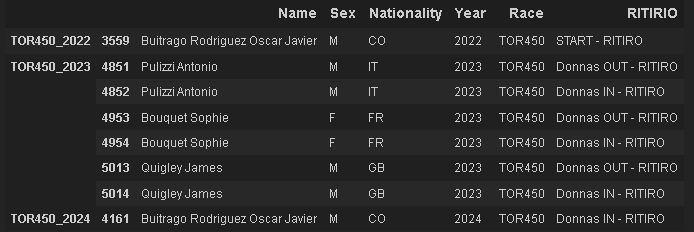

#### Solution
Do nothing?

In [64]:
ritirio_df = TOR450[~(pd.isna(TOR450['RITIRIO'])) &
                    ~(TOR450['RITIRIO'] == '') 
                   ]
# ritirio_df = ritirio_df[['Bib', 'RITIRIO']]
ritirio_df

Name     Bib Sex Nationality    Race  Year  \
6160                Jacek Fugiel  4014.0   M          PL  TOR450  2023   
8005                Sproston Amy  4098.0   F          US  TOR450  2023   
9610             Guasina Giorgio  4013.0   M          IT  TOR450  2023   
9638               Burgin Freddy  4015.0   M          CH  TOR450  2023   
9664      Argelich Torra Enrique  4011.0   M          ES  TOR450  2023   
9744               De Biase Anna  4096.0   F          IT  TOR450  2023   
9772              Taguchi Minori  4139.0   M          JP  TOR450  2023   
9944             Incerti Thierry  4060.0   M          FR  TOR450  2023   
9963          Braccialini Matteo  4128.0   M          IT  TOR450  2023   
9981         Michelotti Giuseppe  4052.0   M          IT  TOR450  2023   
10019            Pulizzi Antonio  4171.0   M          IT  TOR450  2023   
10020            Pulizzi Antonio  4171.0   M          IT  TOR450  2023   
10040             Grenno Raphael  4101.0   M          CH  TOR450  2023   
10061       Do Nascimento Franck  4124.0   M          FR  TOR450  2023   
10082          Maistri Francesco  4064.0   M          IT  TOR450  2023   
10121             Bouquet Sophie  4049.0   F          FR  TOR450  2023   
10122             Bouquet Sophie  4049.0   F          FR  TOR450  2023   
10143             Shao Sebastien  4105.0   M          FR  TOR450  2023   
10181              Quigley James  4125.0   M          GB  TOR450  2023   
10182              Quigley James  4125.0   M          GB  TOR450  2023   
10195                Santos Nuno  4089.0   M          PT  TOR450  2023   
10253           Trabucchi Pietro  4018.0   M          IT  TOR450  2023   
10313             Haylett Philip  4111.0   M          GB  TOR450  2023   
10404         Fohrmeister Volker  4174.0   M          DE  TOR450  2023   
10418     Barbieri Ranieri Brook  4087.0   M          IT  TOR450  2023   
10431        Landresse Christian  4047.0   M          LU  TOR450  2023   
13282              Dossena Paolo  4110.0   M          IT  TOR450  2024   
13387               Hopwood Paul  4137.0   M          AU  TOR450  2024   
13421              Gaffuri Paolo  4160.0   M          IT  TOR450  2024   
13454            Distort Corrado  4151.0   M          IT  TOR450  2024   
13489               Negri Mattia  4063.0   M          IT  TOR450  2024   
13524               Mrtinez Jose  4130.0   M          ES  TOR450  2024   
13867              Testa Antonio  4172.0   M          IT  TOR450  2024   
13896           Gofflot Frederic  4047.0   M          BE  TOR450  2024   
14404           Souchon Frederic  4165.0   M          FR  TOR450  2024   
14426               Obreza Marko  4064.0   M          SI  TOR450  2024   
14569             Herrero Albert  4033.0   M          ES  TOR450  2024   
14617                Blanc Abele  4122.0   M          IT  TOR450  2024   
14636           Alexandru Florin  4057.0   M          RO  TOR450  2024   
14651            Martin Bertrand  4116.0   M          NO  TOR450  2024   
14705          Colls Avila Oscar  4068.0   M          ES  TOR450  2024   
14722         Castellain Edouard  4046.0   M          FR  TOR450  2024   
14739            Buitrago Javier  4117.0   M          CO  TOR450  2024   
14821       Jouneau Pierre Henri  4170.0   M          FR  TOR450  2024   
14838           Hjelmstrom Peter  4006.0   M          SE  TOR450  2024   
14895  Da Costa Veloso Alexandre  4148.0   M          AD  TOR450  2024   
14908            Despretz Thomas  4044.0   M          FR  TOR450  2024   
14916       Cestino Saez Enrique  4109.0   M          ES  TOR450  2024   
14929             Puiati Stefano  4075.0   M          IT  TOR450  2024   
14942               Domnin Erard  4132.0   M          FR  TOR450  2024   
14948          Fernandez Sylvain  4149.0   M          FR  TOR450  2024   
14960            Forzani Adriano  4034.0   M          IT  TOR450  2024   
14998               Frederic Gil  4094.0   M          FR  TOR450  2024   

      Category                 

In [65]:
# Get a list of duplicate names
duplicate_list = ritirio_df['Name'][ritirio_df['Name'].duplicated()].unique()

# Filter the DataFrame to only rows where 'Name' is in the duplicate list
duplicates_in_dataframe = ritirio_df[ritirio_df['Name'].isin(duplicate_list)]

# Display or process the result
duplicates_in_dataframe[['Name', 'Sex', 'Nationality', 'Year', 'Race', 'RITIRIO' ]]


Name Sex Nationality  Year    Race              RITIRIO
10019  Pulizzi Antonio   M          IT  2023  TOR450  Donnas OUT - RITIRO
10020  Pulizzi Antonio   M          IT  2023  TOR450   Donnas IN - RITIRO
10121   Bouquet Sophie   F          FR  2023  TOR450  Donnas OUT - RITIRO
10122   Bouquet Sophie   F          FR  2023  TOR450   Donnas IN - RITIRO
10181    Quigley James   M          GB  2023  TOR450  Donnas OUT - RITIRO
10182    Quigley James   M          GB  2023  TOR450   Donnas IN - RITIRO

In [66]:
ritirio_df['Name'].nunique()

50

In [67]:
count_year_status(TOR450, 'Status')

Year  Status  2021    2022    2023    2024  
0      False      25      85      88     101
1       True      31      46      85      68


In [68]:
# # Merge the datsets back after pivoting
# pivoted_TOR450 = pivoted_TOR450.merge(
#     ritirio_df[['Bib', 'RITIRIO']].drop_duplicates(),  # Ensure no duplicates in 'Bib' and 'RITIRIO'
#     on='Bib',
#     how='left'
# )

### FINISHER'S Missing Timestamps
From time to time, timestamps are missing, even for finishers. Here is the missing values count for all finishers. 

THis is could be for several issues:
1) Participant's Fatigue - they forget to ask to be scanned

2) Volunteer's Fatigue - they forget to scan participants /  they thought they had already scanned the runer

3) Technology Failure - something goes wrong... ?

This is just a screenshot, more can be seen below!

### What is the last place that DNFers reached?
#### Issues with Last location Detected
Some people who too far of a distance between last lifebase /  refuge / checkpoint for it to be an accurate representation of their last location.

2021
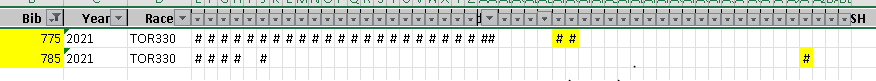

2023
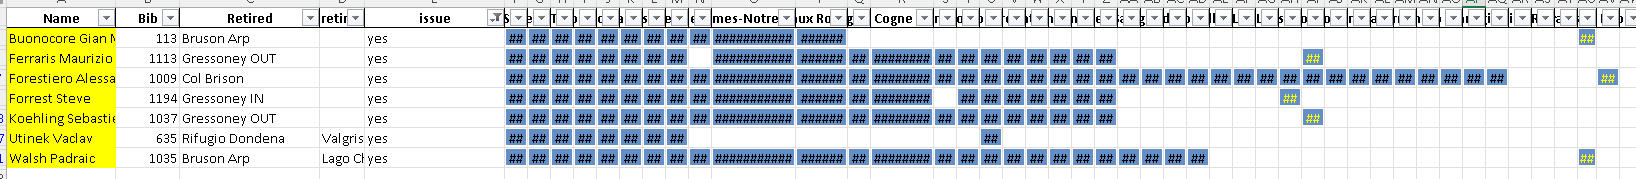

2024

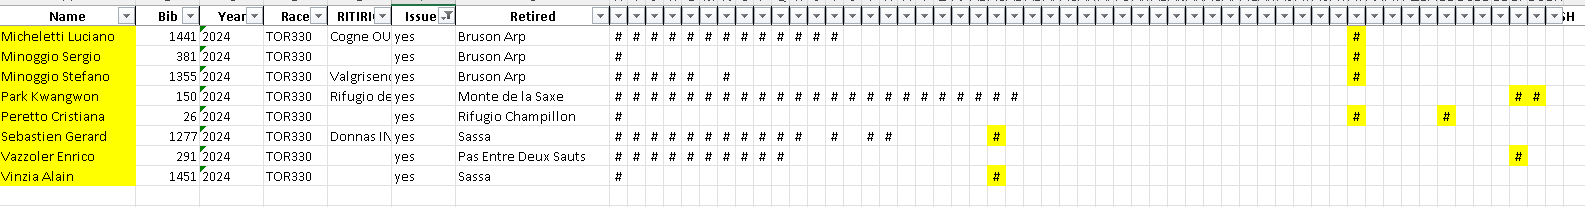

##### Solution
Create a loop that would clean those timestamps.

In [69]:
TORX_list_bib_df = []

TOR450['Status1'] =  TOR450['Status'].astype('str')
TOR450 = TOR450.rename(columns={"Timestamp": "Timestamp"}) 
TOR450 = TOR450.rename(columns={"aid_stations": "Aid Station"}) 
# 
for year in years:
    year_TOR450 = TOR450[TOR450['Year'] == year]
    for unique_bib in year_TOR450['Bib'].unique():
        bib_df = year_TOR450[year_TOR450['Bib'] == unique_bib]
        bib_df = bib_df.sort_values(by='Timestamp', ascending = True).reset_index(drop = True)

        # Check if runner has DNF status
        if bib_df.loc[0, 'Status1'] == 'False':
            n = 0  # Reset counter for missing timestamps

            for idx, row in bib_df.iterrows():
                if pd.isna(row['Timestamp']):
                    n += 1
                    if n > 5 and idx + 1 < len(bib_df):  # Ensure index is in bounds
                        bib_df.at[idx + 1, 'Timestamp'] = pd.NaT
                else:
                    n = 0  # Reset counter if a timestamp appears again

            # Find the last valid aid station with a timestamp
            last_valid_indices = bib_df[bib_df['Timestamp'].notna()].groupby('Bib').tail(1)

            if not last_valid_indices.empty:
                last_aid_station = last_valid_indices['Aid Station'].values[0]
                print(f"Bib {unique_bib}: Retired at {last_aid_station}")

                # Assign the retired location to the entire bib_df
                bib_df['Retired'] = last_aid_station
            else:
                print(f"Warning: No valid aid station found for Bib {unique_bib}")

        else:
            print(f"Bib {unique_bib}: Finished the race")

        # Append processed data
        TORX_list_bib_df.append(bib_df)

# Concatenate all processed bib dataframes
melt_TOR450 = pd.concat(TORX_list_bib_df, ignore_index=True)

melt_TOR450['Bib'] = melt_TOR450['Bib'].astype('int')
melt_TOR450['Bib'] = melt_TOR450['Bib'].astype('str')
melt_TOR450['PK'] = melt_TOR450['Race'].astype(str) + '_' + melt_TOR450['Year'].astype(str) + '_'+ melt_TOR450['Bib'].astype(str)



Bib 4001.0: Finished the race
Bib 4015.0: Finished the race
Bib 4006.0: Finished the race
Bib 4027.0: Finished the race
Bib 4011.0: Finished the race
Bib 4048.0: Finished the race
Bib 4017.0: Finished the race
Bib 4050.0: Finished the race
Bib 4065.0: Finished the race
Bib 4037.0: Finished the race
Bib 4003.0: Finished the race
Bib 4032.0: Finished the race
Bib 4064.0: Finished the race
Bib 4004.0: Finished the race
Bib 4043.0: Finished the race
Bib 4026.0: Finished the race
Bib 4024.0: Finished the race
Bib 4019.0: Finished the race
Bib 4042.0: Finished the race
Bib 4014.0: Finished the race
Bib 4028.0: Finished the race
Bib 4012.0: Finished the race
Bib 4063.0: Finished the race
Bib 4040.0: Finished the race
Bib 4039.0: Finished the race
Bib 4031.0: Finished the race
Bib 4034.0: Finished the race
Bib 4035.0: Finished the race
Bib 4021.0: Finished the race
Bib 4046.0: Finished the race
Bib 4047.0: Finished the race
Bib 4061.0: Retired at Rifugio Champillon
Bib 4030.0: Retired at Oyace

Bib 4095.0: Finished the race
Bib 4074.0: Finished the race
Bib 4145.0: Finished the race
Bib 4121.0: Finished the race
Bib 4116.0: Finished the race
Bib 4079.0: Finished the race
Bib 4045.0: Finished the race
Bib 4061.0: Finished the race
Bib 4132.0: Finished the race
Bib 4098.0: Retired at Champoluc
Bib 4164.0: Finished the race
Bib 4166.0: Finished the race
Bib 4104.0: Finished the race
Bib 4057.0: Finished the race
Bib 4084.0: Finished the race
Bib 4181.0: Finished the race
Bib 4147.0: Retired at Oyace OUT
Bib 4178.0: Finished the race
Bib 4050.0: Finished the race
Bib 4179.0: Finished the race
Bib 4070.0: Finished the race
Bib 4134.0: Finished the race
Bib 4118.0: Finished the race
Bib 4075.0: Finished the race
Bib 4078.0: Finished the race
Bib 4097.0: Finished the race
Bib 4035.0: Finished the race
Bib 4010.0: Finished the race
Bib 4038.0: Finished the race
Bib 4042.0: Finished the race
Bib 4100.0: Finished the race
Bib 4006.0: Retired at Parco Bollino
Bib 4093.0: Retired at Rifu

Bib 4002.0: Retired at Rifugio Bonze
Bib 4074.0: Retired at Dortoir Retempio
Bib 4170.0: Retired at Chardonney
Bib 4006.0: Retired at Chardonney
Bib 4016.0: Retired at Rifugio Miserin
Bib 4001.0: Retired at Rifugio Miserin
Bib 4069.0: Retired at Rifugio Grauson
Bib 4148.0: Retired at Cogne OUT
Bib 4044.0: Retired at Cogne OUT
Bib 4109.0: Retired at Cogne OUT
Bib 4075.0: Retired at Cogne OUT
Bib 4132.0: Retired at Cogne IN
Bib 4149.0: Retired at Cogne IN
Bib 4034.0: Retired at Cogne IN
Bib 4029.0: Retired at Cogne IN
Bib 4031.0: Retired at Rifugio Chabod
Bib 4062.0: Retired at Rifugio Savoia
Bib 4094.0: Retired at Rifugio Savoia
Bib 4085.0: Retired at Rifugio Savoia
Bib 4012.0: Retired at Rifugio Bezzi
Bib 4079.0: Retired at Rifugio Bezzi
Bib 4099.0: Retired at Rifugio Bezzi
Bib 4017.0: Retired at Rifugio Bezzi
Bib 4112.0: Retired at Rifugio Bezzi
Bib 4025.0: Retired at Rifugio degli Angeli
Bib 4147.0: Retired at Rifugio degli Angeli
Bib 4066.0: Retired at Rifugio degli Angeli
Bib 4089.

In [70]:
melt_TOR450.groupby(['Retired'])

In [71]:
melt_TOR450[(melt_TOR450['Name'] == 'Tierney Paul') &
           (melt_TOR450['Year'] == '2024')]

Name   Bib Sex Nationality    Race  Year Category  \
14723  Tierney Paul  4104   M          IE  TOR450  2024       V1   
14724  Tierney Paul  4104   M          IE  TOR450  2024       V1   
14725  Tierney Paul  4104   M          IE  TOR450  2024       V1   
14726  Tierney Paul  4104   M          IE  TOR450  2024       V1   

                           Place                       Time Status  \
14723                        NaN                        NaN  False   
14724  040 - Rif. Maison Vieille  2024-09-06T21:00:21+02:00  False   
14725      050 - Rif. Elisabetta  2024-09-06T22:32:53+02:00  False   
14726    060 - Rif. Deffeyes 450  2024-09-07T03:31:19+02:00  False   

                  Aid Station RITIRIO           Timestamp Status1  \
14723                   START     NaN 2024-09-06 20:00:00   False   
14724  Rifugio Maison Vieille         2024-09-06 21:00:21   False   
14725      Rifugio Elisabetta         2024-09-06 22:32:53   False   
14726        Rifugio Deffeyes         2024-09-07 03:31:19   False   

                Retired                PK  
14723  Rifugio Deffeyes  TOR450_2024_4104  
14724  Rifugio Deffeyes  TOR450_2024_4104  
14725  Rifugio Deffeyes  TOR450_2024_4104  
14726  Rifugio Deffeyes  TOR450_2024_4104

###  Unpredictable Weather of 2022 
In 2022, due to the weather,  the race directors decided to stop the race at Bosses and Refuge Frassati.  

In [72]:

for year in years:
    if year == '2022':
        
        for retired_location in melt_TOR450['Retired'].unique():
            if pd.isna(retired_location):
                # Update 'Status1' for year 2022
                melt_TOR450.loc[
                    melt_TOR450['Year'] == year, 'Status1'
                ] = melt_TOR450.loc[
                    melt_TOR450['Year'] == year, 'Status1'
                ].str.replace('True', 'Finished at Courmayeur')
                
            elif retired_location == 'Rifugio Frassati' or retired_location == 'Bosses'\
                or retired_location == 'Hotel Italia':
                # For finishers at Rifugio Frassati
                melt_TOR450.loc[
                    (melt_TOR450['Year'] == year) & (melt_TOR450['Retired'] == retired_location), 'Status1'
                ] = melt_TOR450.loc[
                    (melt_TOR450['Year'] == year) & (melt_TOR450['Retired'] == retired_location), 'Status1'
                ].str.replace('False', f'Finished at {retired_location}')

                melt_TOR450.loc[
                    (melt_TOR450['Year'] == year) & (melt_TOR450['Retired'] == retired_location), 'Retired'
                ] = np.nan
                
            else:
                # Allother DNFs
                melt_TOR450.loc[
                    (melt_TOR450['Year'] == year)
                    & ~(melt_TOR450['Retired'].isin(['Bosses', 'Rifugio Frassati'])), 'Status1'
                ] = melt_TOR450.loc[
                    (melt_TOR450['Year'] == year)
                    & ~(melt_TOR450['Retired'].isin(['Bosses', 'Rifugio Frassati'])), 'Status1'
                ].str.replace('False', 'DNF')

    else:
        
        print(year)
        # Update 'Status1' for years other than 2022
        melt_TOR450.loc[melt_TOR450['Year'] == year, 'Status1'] = (
            melt_TOR450.loc[melt_TOR450['Year'] == year, 'Status1']
            .str.replace('True', 'Finished at Courmayeur')
            .str.replace('False', 'DNF')
        )
        print(melt_TOR450['Status1'].unique())

2021
['Finished at Courmayeur' 'DNF' 'True' 'False']
2023
['Finished at Courmayeur' 'DNF' 'Finished at Bosses' 'True' 'False']
2024
['Finished at Courmayeur' 'DNF' 'Finished at Bosses']


In [73]:
count_year_status(melt_TOR450, 'Status1')

Year                 Status1  2021     2022     2023     2024   
0                        DNF     25.0     76.0     88.0    101.0
1         Finished at Bosses      NaN      9.0      NaN      NaN
2     Finished at Courmayeur     31.0     46.0     85.0     68.0


### Where did the DNFs occur?

In [74]:
for stage,  stage_str in zip(stages, stages_str):
    print(stage_str, stage)
    melt_TOR450.loc[melt_TOR450['Retired'].isin(stage), 'Retired_Stage'] = f'{stage_str}'
        
melt_TOR450.loc[melt_TOR450['Retired'] == 'START', 'Retired_Stage'] = 'DNS'

Stage 1 ['START', 'Rifugio Maison Vieille', 'Rifugio Elisabetta', 'Rifugio Deffeyes', 'Rifugio degli Angeli', 'Rifugio Bezzi', 'Rifugio Benevolo', 'Rifugio Savoia', 'Rifugio Vittorio Emanuele II', 'Rifugio Chabod', 'Rifugio Sella', 'Cogne IN']
Stage 2 ['Cogne OUT', 'Rifugio Grauson', 'Rifugio Dondena', 'Rifugio Miserin', 'Dortoir Crest', 'Dortoir Retempio', 'Rifugio Bonze', 'Donnas IN']
Stage 3 ['Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda', 'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia', 'Niel La Gruba', 'Loo', 'Gressoney IN']
Stage 4 ['Gressoney OUT', 'Rifugio Sitten', 'Rifugio Ferraro', 'Rifugio Guide di Frachey', 'Rifugio Duca degli Abruzzi', 'Hotel Stambecco', 'Rifugio Perucca Vuillermoz', 'Rifugio Prarayer', 'Rifugio Crête Sèche', 'Rifugio Champillon', 'Ponteille Desot', 'Hotel Italia', 'Rifugio Frassati', 'Pas Entre Deux Sauts', 'Monte de la Saxe', 'Parco Bollino', 'FINISH']
Stage 4 Diversion ['Oyace', 'Oyace OUT', 'Bruson Arp', 'Col Brison', 'Berio Damon', 'Ollomon

In [75]:
melt_TOR450['Retired'] = melt_TOR450['Retired'].str.replace(' IN', '')
melt_TOR450['Retired'] = melt_TOR450['Retired'].str.replace(' OUT', '')

## Diversion?

In [76]:
TORX_list = []
for year in years:
    n = 0
    year_df = melt_TOR450[melt_TOR450['Year'] == year]
    print('*'*50, '\n', year)
    for unique_bib in year_df['Bib'].unique(): 
        # Filter the dataframe for the current unique_bib
        bib_df = year_df[year_df['Bib'] == unique_bib].reset_index(drop = True)
        bib_df = bib_df.sort_values(by = 'Timestamp', ascending =  True)
        bib_df_aid_station_list = list(bib_df['Aid Station'].unique())
        n = n+1


        for route in Stage4_diversion:
            if any(checkpoint in bib_df_aid_station_list for checkpoint in Stage4_diversion):
                print(f'{n}, stage4 diversion: {route}')
                bib_df['Diversion'] = 'Stage 4 Weather Contingency Route'


                
        # Append the processed DataFrame to the list
        TORX_list.append(bib_df)
                
if TORX_list:
    melt_TOR450 = pd.concat(TORX_list, ignore_index=True)
    print("Combined DataFrame created.")
else:
    melt_TOR450 = pd.DataFrame()
    print("No DataFrames were processed.")

print(melt_TOR450.columns)
melt_TOR450['Diversion'] = melt_TOR450['Diversion'].fillna('As Planned Route')

************************************************** 
 2021
33, stage4 diversion: Oyace
33, stage4 diversion: Oyace OUT
33, stage4 diversion: Bruson Arp
33, stage4 diversion: Col Brison
33, stage4 diversion: Berio Damon
33, stage4 diversion: Ollomont IN
33, stage4 diversion: Ollomont OUT
************************************************** 
 2022
************************************************** 
 2023
8, stage4 diversion: Oyace
8, stage4 diversion: Oyace OUT
8, stage4 diversion: Bruson Arp
8, stage4 diversion: Col Brison
8, stage4 diversion: Berio Damon
8, stage4 diversion: Ollomont IN
8, stage4 diversion: Ollomont OUT
9, stage4 diversion: Oyace
9, stage4 diversion: Oyace OUT
9, stage4 diversion: Bruson Arp
9, stage4 diversion: Col Brison
9, stage4 diversion: Berio Damon
9, stage4 diversion: Ollomont IN
9, stage4 diversion: Ollomont OUT
10, stage4 diversion: Oyace
10, stage4 diversion: Oyace OUT
10, stage4 diversion: Bruson Arp
10, stage4 diversion: Col Brison
10, stage4 diversion: Berio

46, stage4 diversion: Oyace
46, stage4 diversion: Oyace OUT
46, stage4 diversion: Bruson Arp
46, stage4 diversion: Col Brison
46, stage4 diversion: Berio Damon
46, stage4 diversion: Ollomont IN
46, stage4 diversion: Ollomont OUT
47, stage4 diversion: Oyace
47, stage4 diversion: Oyace OUT
47, stage4 diversion: Bruson Arp
47, stage4 diversion: Col Brison
47, stage4 diversion: Berio Damon
47, stage4 diversion: Ollomont IN
47, stage4 diversion: Ollomont OUT
48, stage4 diversion: Oyace
48, stage4 diversion: Oyace OUT
48, stage4 diversion: Bruson Arp
48, stage4 diversion: Col Brison
48, stage4 diversion: Berio Damon
48, stage4 diversion: Ollomont IN
48, stage4 diversion: Ollomont OUT
49, stage4 diversion: Oyace
49, stage4 diversion: Oyace OUT
49, stage4 diversion: Bruson Arp
49, stage4 diversion: Col Brison
49, stage4 diversion: Berio Damon
49, stage4 diversion: Ollomont IN
49, stage4 diversion: Ollomont OUT
50, stage4 diversion: Oyace
50, stage4 diversion: Oyace OUT
50, stage4 diversion: Br

92, stage4 diversion: Oyace
92, stage4 diversion: Oyace OUT
92, stage4 diversion: Bruson Arp
92, stage4 diversion: Col Brison
92, stage4 diversion: Berio Damon
92, stage4 diversion: Ollomont IN
92, stage4 diversion: Ollomont OUT
93, stage4 diversion: Oyace
93, stage4 diversion: Oyace OUT
93, stage4 diversion: Bruson Arp
93, stage4 diversion: Col Brison
93, stage4 diversion: Berio Damon
93, stage4 diversion: Ollomont IN
93, stage4 diversion: Ollomont OUT
94, stage4 diversion: Oyace
94, stage4 diversion: Oyace OUT
94, stage4 diversion: Bruson Arp
94, stage4 diversion: Col Brison
94, stage4 diversion: Berio Damon
94, stage4 diversion: Ollomont IN
94, stage4 diversion: Ollomont OUT
************************************************** 
 2024
27, stage4 diversion: Oyace
27, stage4 diversion: Oyace OUT
27, stage4 diversion: Bruson Arp
27, stage4 diversion: Col Brison
27, stage4 diversion: Berio Damon
27, stage4 diversion: Ollomont IN
27, stage4 diversion: Ollomont OUT
28, stage4 diversion: Oyac

61, stage4 diversion: Oyace
61, stage4 diversion: Oyace OUT
61, stage4 diversion: Bruson Arp
61, stage4 diversion: Col Brison
61, stage4 diversion: Berio Damon
61, stage4 diversion: Ollomont IN
61, stage4 diversion: Ollomont OUT
62, stage4 diversion: Oyace
62, stage4 diversion: Oyace OUT
62, stage4 diversion: Bruson Arp
62, stage4 diversion: Col Brison
62, stage4 diversion: Berio Damon
62, stage4 diversion: Ollomont IN
62, stage4 diversion: Ollomont OUT
63, stage4 diversion: Oyace
63, stage4 diversion: Oyace OUT
63, stage4 diversion: Bruson Arp
63, stage4 diversion: Col Brison
63, stage4 diversion: Berio Damon
63, stage4 diversion: Ollomont IN
63, stage4 diversion: Ollomont OUT
64, stage4 diversion: Oyace
64, stage4 diversion: Oyace OUT
64, stage4 diversion: Bruson Arp
64, stage4 diversion: Col Brison
64, stage4 diversion: Berio Damon
64, stage4 diversion: Ollomont IN
64, stage4 diversion: Ollomont OUT
65, stage4 diversion: Oyace
65, stage4 diversion: Oyace OUT
65, stage4 diversion: Br

In [77]:
melt_TOR450[(melt_TOR450['Name'] =='Flavelle Erika')]

Name   Bib Sex Nationality    Race  Year Category  \
11775  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11776  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11777  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11778  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11779  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11780  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11781  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11782  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11783  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11784  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11785  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11786  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11787  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11788  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11789  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11790  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11791  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11792  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11793  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11794  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11795  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11796  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11797  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11798  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11799  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11800  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11801  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11802  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11803  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11804  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11805  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11806  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11807  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11808  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11809  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11810  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11811  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11812  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11813  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11814  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11815  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11816  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11817  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11818  Flavelle Erika  4045   F          CA  TOR450  2024       V1   

                                 Place                       Time Status  \
11775                              NaN                        NaN   True   
11776        040 - Rif. Maison Vieille  2024-09-06T21:13:02+02:00   True   
11777            050 - Rif. Elisabetta  2024-09-06T23:08:19+02:00   True   
11778          060 - Rif. Deffeyes 450  2024-09-07T05:10:26+02:00   True   
11779          070 - Rif. degli Angeli  2024-09-07T12:31:48+02:00   True   
11780                 080 - Rif. Bezzi  2024-09-07T17:36:07+02:00   True   
11781              090 - Rif. Benevolo  2024-09-07T21:06:33+02:00   True   
11782                100 - Rif. Savoia  2024-09-08T00:51:23+02:00   True   
11783  110 - Rif. Vittorio Emanuele II  2024-09-08T06:38:39+02:00   True   
11784                120 - Rif. Chabod  2024-09-08T08:39:25+02:00   True   
11785             190 - Rif. S

### Sub-Finish Category

I labelled the Finisher's Sub-130 Finish times
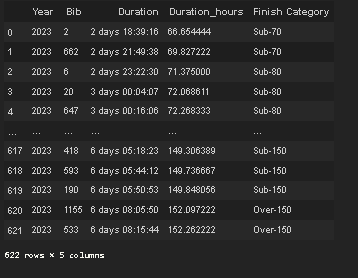

In [78]:
# Convert to timedelta and get total hours (handling NaT)
TOR450_dem['Duration_hours'] = pd.to_timedelta(
    TOR450_dem['Duration'], errors='coerce').dt.total_seconds() / 3600  # Convert seconds to hours


# Create a new column 'Finish Category'
def categorize_duration(hours):
    if pd.isna(hours):
        return 'DNF'  # Handle NaT values
    elif hours < 120:
        return 'Sub-120'
    elif hours <= 190:
        return f'Sub-{int(hours // 10) * 10 + 10}'  # Round to nearest 10 up to 150
    else:
        return 'Over-150'
    
# Apply categorization with proper indexing
if year == '2022':
    mask = TOR450_dem['Status1'].str.contains('Courmayeur', na=False)
    TOR450_dem.loc[mask, 'Finish Category'] = TOR450_dem.loc[mask, 'Duration_hours'].apply(categorize_duration)
else:
    TOR450_dem['Finish Category'] = TOR450_dem['Duration_hours'].apply(categorize_duration)


# Define the desired order of categories
finish_category_order = [
     'Sub-120', 'Sub-130', 'Sub-140', 'Sub-150', 
    'Sub-160', 'Sub-170', 'Sub-180', 'Sub-190', 
    'Over-190', 'DNF'
]

# Set 'Finish Category' as a categorical column with the defined order
TOR450_dem['Finish Category'] = pd.Categorical(
    TOR450_dem['Finish Category'],
    categories = finish_category_order,
    ordered = True
)


TOR450_dem['Bib'] = TOR450_dem['Bib'].astype('int')
TOR450_dem['Bib'] = TOR450_dem['Bib'].astype('str')
TOR450_dem['PK'] = TOR450_dem['Race'].astype(str) + '_' + melt_TOR450['Year'].astype(str) + '_'+ melt_TOR450['Bib'].astype(str) 



# Display the DataFrame
# TOR450_dem[['Year','Bib', 'Duration', 'Duration_hours', 'Finish Category']]
# TOR450_dem.groupby(['Year', 'Finish Category'])['Finish Category'].count()
count_year_status(TOR450_dem, 'Finish Category')

Year Finish Category  2021  2022  2023  2024
0            Sub-120     0     0     2     0
1            Sub-130     0     1     1     1
2            Sub-140     2     3     4     1
3            Sub-150     0     4     3     1
4            Sub-160     3     3     6    13
5            Sub-170     7    14    24    10
6            Sub-180     6    11    14    11
7            Sub-190    13    10    31    31
8           Over-190     0     0     0     0
9                DNF    25    97    88   117


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\2215122373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dem['Duration_hours'] = pd.to_timedelta(
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\2215122373.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOR450_dem['Finish Category'] = TOR450_dem['Duration_hours'].apply(categorize_duration)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\2215122373.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

# Demographic data

In [79]:
TOR450_more_info = melt_TOR450[['PK', 'Race', 'Year', 'Bib', 'Name', 'Sex', 'Nationality','Category',
       'Status1', 'Retired', 'Retired_Stage', 'Diversion']].drop_duplicates(keep='first')

# Merge the datsets back together
TOR450_dem = TOR450_dem.merge(
    TOR450_more_info[['PK', 'Name', 'Bib', 'Sex', 'Nationality',
                     'Race', 'Year', 'Category',
                     'Status1', 'Retired', 'Retired_Stage', 'Diversion']], 
    on=['PK', 'Name', 'Bib', 'Sex', 'Nationality',
        'Race', 'Year', 'Category'],
    how='left'
)


TOR450_dem = TOR450_dem.reset_index(drop = True)

TOR450_dem[TOR450_dem['Name'] == 'Tierney Paul']

Name   Bib Sex Nationality Category    Race  Year  Status  \
134  Tierney Paul  4063   M          IE      SEN  TOR450  2022    True   
315  Tierney Paul  4104   M          IE       V1  TOR450  2024   False   
488  Tierney Paul  4163   M          IE       V1  TOR450  2023    True   

           Duration  Duration_hours  Duration_seconds Finish Category  \
134 5 days 16:23:20      136.388889          491000.0         Sub-140   
315             NaT             NaN               NaN             DNF   
488 5 days 15:22:00      135.366667          487320.0         Sub-140   

                   PK Status1 Retired Retired_Stage Diversion  
134  TOR450_2021_4027     NaN     NaN           NaN       NaN  
315  TOR450_2021_4065     NaN     NaN           NaN       NaN  
488  TOR450_2021_4004     NaN     NaN           NaN       NaN

In [80]:
TOR450_dem.groupby('Retired')['Retired'].count()

Series([], Name: Retired, dtype: int64)

In [81]:
TOR450_dem.groupby('Retired_Stage')['Retired_Stage'].count()

Series([], Name: Retired_Stage, dtype: int64)

In [82]:
TOR450_dem.groupby([ 'Retired_Stage', 'Retired'])['Retired'].count()

Series([], Name: Retired, dtype: int64)

In [83]:
melt_TOR450['Retired'] = melt_TOR450['Retired'].fillna('')
melt_TOR450['Retired_Stage'] = melt_TOR450['Retired_Stage'].fillna('')


In [84]:
melt_TOR450 [(melt_TOR450 ['Name'].str.contains('Erika')) &
                   (melt_TOR450 ['Year'] == '2024')
                  ]

Name   Bib Sex Nationality    Race  Year Category  \
11775  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11776  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11777  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11778  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11779  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11780  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11781  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11782  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11783  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11784  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11785  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11786  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11787  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11788  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11789  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11790  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11791  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11792  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11793  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11794  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11795  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11796  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11797  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11798  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11799  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11800  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11801  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11802  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11803  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11804  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11805  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11806  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11807  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11808  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11809  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11810  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11811  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11812  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11813  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11814  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11815  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11816  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11817  Flavelle Erika  4045   F          CA  TOR450  2024       V1   
11818  Flavelle Erika  4045   F          CA  TOR450  2024       V1   

                                 Place                       Time Status  \
11775                              NaN                        NaN   True   
11776        040 - Rif. Maison Vieille  2024-09-06T21:13:02+02:00   True   
11777            050 - Rif. Elisabetta  2024-09-06T23:08:19+02:00   True   
11778          060 - Rif. Deffeyes 450  2024-09-07T05:10:26+02:00   True   
11779          070 - Rif. degli Angeli  2024-09-07T12:31:48+02:00   True   
11780                 080 - Rif. Bezzi  2024-09-07T17:36:07+02:00   True   
11781              090 - Rif. Benevolo  2024-09-07T21:06:33+02:00   True   
11782                100 - Rif. Savoia  2024-09-08T00:51:23+02:00   True   
11783  110 - Rif. Vittorio Emanuele II  2024-09-08T06:38:39+02:00   True   
11784                120 - Rif. Chabod  2024-09-08T08:39:25+02:00   True   
11785             190 - Rif. S

In [85]:
sub_TOR45_dem = ['PK', 'Race', 'Year', 'Bib', 'Name', 
                 'Status1', 'Status', 'Retired', 'Retired_Stage', 'Diversion']

## Lifebase Data

In [86]:
melt_lifebase_df = melt_TOR450[melt_TOR450['Aid Station'].isin(lifebase_category_order)]

melt_lifebase_df = melt_lifebase_df[ sub_TOR45_dem + [ 'Aid Station', 'Timestamp']]

melt_lifebase_df = melt_lifebase_df.rename(columns={"Aid Station": "Lifebase"}) 

pivot_lifebase_df = melt_lifebase_df.pivot_table(
            index = sub_TOR45_dem,
            columns= 'Lifebase',  
            values='Timestamp',
            aggfunc='first'  # Ensures only the first match is kept in case of duplicates
    
        ).reset_index()

print(sub_TOR45_dem)
pivot_lifebase_df= pivot_lifebase_df [sub_TOR45_dem + lifebase_category_order ]


melt_lifebase_df = pivot_lifebase_df.melt(id_vars = sub_TOR45_dem, 
                         var_name='Lifebase',   
                         value_name="Timestamp")


# Set 'Finish Category' as a categorical column with the defined order
melt_lifebase_df['Lifebase'] = pd.Categorical(
        melt_lifebase_df['Lifebase'],
        categories = lifebase_category_order,
        ordered = True)

melt_lifebase_df= place_into_stage(melt_lifebase_df, 'Lifebase')

melt_lifebase_df[(melt_lifebase_df['Name'] == 'Tierney Paul') &
                   (melt_lifebase_df['Year'] == '2023')]


['PK', 'Race', 'Year', 'Bib', 'Name', 'Status1', 'Status', 'Retired', 'Retired_Stage', 'Diversion']


PK    Race  Year   Bib          Name  \
336   TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
865   TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
1394  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
1923  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
2452  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
2981  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
3510  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
4039  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   

                     Status1  Status Retired Retired_Stage         Diversion  \
336   Finished at Courmayeur    True                        As Planned Route   
865   Finished at Courmayeur    True                        As Planned Route   
1394  Finished at Courmayeur    True                        As Planned Route   
1923  Finished at Courmayeur    True                        As Planned Route   
2452  Finished at Courmayeur    True                        As Planned Route   
2981  Finished at Courmayeur    True                        As Planned Route   
3510  Finished at Courmayeur    True                        As Planned Route   
4039  Finished at Courmayeur    True                        As Planned Route   

           Lifebase           Timestamp                    Stage  
336           START 2023-09-08 20:00:00                  Stage 1  
865        Cogne IN                 NaT                  Stage 1  
1394      Cogne OUT 2023-09-10 13:03:53      Time Spent in Cogne  
1923      Donnas IN 2023-09-11 09:22:33                  Stage 2  
2452     Donnas OUT 2023-09-11 10:09:28     Time Spent in Donnas  
2981   Gressoney IN 2023-09-12 06:43:33                  Stage 3  
3510  Gressoney OUT 2023-09-12 08:32:19  Time Spent in Gressoney  
4039         FINISH 2023-09-14 11:22:00                  Stage 4

In [87]:
melt_lifebase_df[(melt_lifebase_df['Name'] == 'Tierney Paul')]

PK    Race  Year   Bib          Name  \
115   TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
336   TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
453   TOR450_2024_4104  TOR450  2024  4104  Tierney Paul   
644   TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
865   TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
982   TOR450_2024_4104  TOR450  2024  4104  Tierney Paul   
1173  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1394  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
1511  TOR450_2024_4104  TOR450  2024  4104  Tierney Paul   
1702  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1923  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
2040  TOR450_2024_4104  TOR450  2024  4104  Tierney Paul   
2231  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
2452  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
2569  TOR450_2024_4104  TOR450  2024  4104  Tierney Paul   
2760  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
2981  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
3098  TOR450_2024_4104  TOR450  2024  4104  Tierney Paul   
3289  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
3510  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
3627  TOR450_2024_4104  TOR450  2024  4104  Tierney Paul   
3818  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
4039  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
4156  TOR450_2024_4104  TOR450  2024  4104  Tierney Paul   

                     Status1  Status           Retired Retired_Stage  \
115   Finished at Courmayeur    True                                   
336   Finished at Courmayeur    True                                   
453                      DNF   False  Rifugio Deffeyes       Stage 1   
644   Finished at Courmayeur    True                                   
865   Finished at Courmayeur    True                                   
982                      DNF   False  Rifugio Deffeyes       Stage 1   
1173  Finished at Courmayeur    True                                   
1394  Finished at Courmayeur    True                                   
1511                     DNF   False  Rifugio Deffeyes       Stage 1   
1702  Finished at Courmayeur    True                                   
1923  Finished at Courmayeur    True                                   
2040                     DNF   False  Rifugio Deffeyes       Stage 1   
2231  Finished at Courmayeur    True                                   
2452  Finished at Courmayeur    True                                   
2569                     DNF   False  Rifugio Deffeyes       Stage 1   
2760  Finished at Courmayeur    True                                   
2981  Finished at Courmayeur    True                                   
3098                     DNF   False  Rifugio Deffeyes       Stage 1   
3289  Finished at Courmayeur    True                                   
3510  Finished at Courmayeur    True                                   
3627                     DNF   False  Rifugio Deffeyes       Stage 1   
3818  Finished at Courmayeur    True                                   
4039  Finished at Courmayeur    True                                   
4156                     DNF   False  Rifugio Deffeyes       Stage 1   

             Diversion       Lifebase           Timestamp  \
115   As Planned Route          START 2022-09-09 20:00:00   
336   As Planned Route          START 2023-09-08 20:00:00   
453   As Planned Route          START 2024-09-06 20:00:00   
644   As Planned Route       Cogne IN 2022-09-11 12:04:23   
865   As Planned Route       Cogne IN                 NaT   
982   As Planned Route       Cogne IN                 NaT   
1173  As Planned Route      Cogne OUT 2022-09-11 13:04:11   
1394  As Planned Route      Cogne OUT 2023-09-10 13:03:53   
1511  As Planned Route      Cogne OUT                 NaT   
1702  As Planned Route      Donnas IN 2022-09-12 09:38:28   
1923  As Planned Route      Donnas IN 2023-09-1

### Checkpoints

In [88]:
melt_checkpoint_df = melt_TOR450[melt_TOR450['Aid Station'].isin(checkpoint_category_order)]

melt_checkpoint_df = melt_checkpoint_df[ sub_TOR45_dem+[ 'Aid Station', 'Timestamp']]

melt_checkpoint_df = melt_checkpoint_df.rename(columns={"Aid Station": "Checkpoint"}) 

pivot_checkpoint_df = melt_checkpoint_df.pivot_table(
            index = sub_TOR45_dem,
            columns= 'Checkpoint',  
            values='Timestamp',
            aggfunc='first'  # Ensures only the first match is kept in case of duplicates
    
        ).reset_index()

pivot_checkpoint_df= pivot_checkpoint_df [sub_TOR45_dem + checkpoint_category_order]

melt_checkpoint_df = pivot_checkpoint_df.melt(id_vars= sub_TOR45_dem, 
                         var_name='Checkpoint',   
                         value_name="Timestamp")


# Set 'Finish Category' as a categorical column with the defined order
melt_checkpoint_df['Checkpoint'] = pd.Categorical(
        melt_checkpoint_df['Checkpoint'],
        categories = checkpoint_category_order,
        ordered = True)


melt_checkpoint_df = place_into_stage(melt_checkpoint_df, 'Checkpoint')

melt_checkpoint_df[(melt_checkpoint_df['Name'] == 'Tierney Paul') &
                   (melt_checkpoint_df['Year'] == '2023')
                  ]

PK    Race  Year   Bib          Name  \
336   TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
865   TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
1394  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
1923  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
2452  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
2981  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
3510  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
4039  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   
4568  TOR450_2023_4163  TOR450  2023  4163  Tierney Paul   

                     Status1  Status Retired Retired_Stage         Diversion  \
336   Finished at Courmayeur    True                        As Planned Route   
865   Finished at Courmayeur    True                        As Planned Route   
1394  Finished at Courmayeur    True                        As Planned Route   
1923  Finished at Courmayeur    True                        As Planned Route   
2452  Finished at Courmayeur    True                        As Planned Route   
2981  Finished at Courmayeur    True                        As Planned Route   
3510  Finished at Courmayeur    True                        As Planned Route   
4039  Finished at Courmayeur    True                        As Planned Route   
4568  Finished at Courmayeur    True                        As Planned Route   

              Checkpoint           Timestamp                    Stage  
336                START 2023-09-08 20:00:00                  Stage 1  
865             Cogne IN                 NaT                  Stage 1  
1394           Cogne OUT 2023-09-10 13:03:53      Time Spent in Cogne  
1923           Donnas IN 2023-09-11 09:22:33                  Stage 2  
2452          Donnas OUT 2023-09-11 10:09:28     Time Spent in Donnas  
2981        Gressoney IN 2023-09-12 06:43:33                  Stage 3  
3510       Gressoney OUT 2023-09-12 08:32:19  Time Spent in Gressoney  
4039  Rifugio Champillon 2023-09-13 20:19:44                  Stage 4  
4568              FINISH 2023-09-14 11:22:00                  Stage 4

## Who missed the Checkpoint Cut OFFs?

## Cutoffs
The cutoffs table was used to establish whether individuals missed the cutoffs or not.


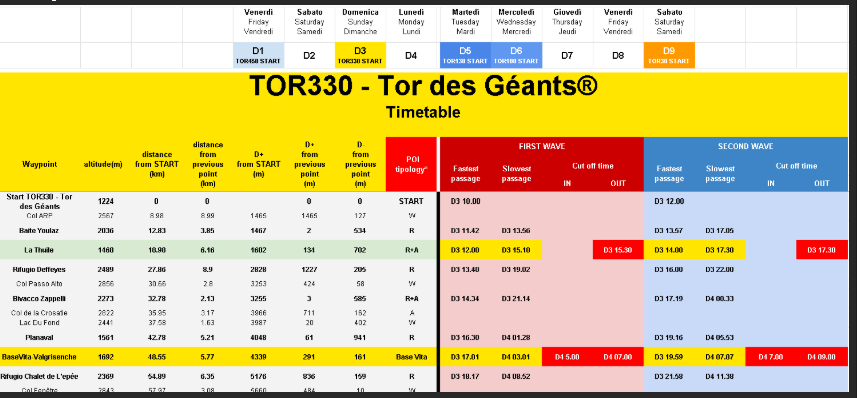


#### Stage Cutoffs
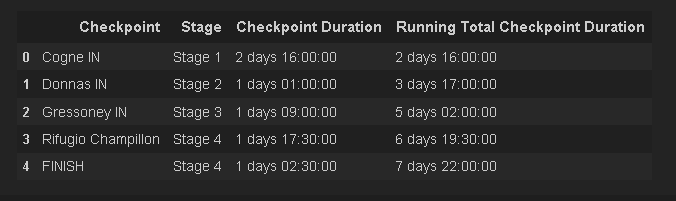
After cleaning the CSV and attaching dates instead of D1/ D2/ D3 etc, this is what the cut off talbe looks like:

#### Dates Cutoffs
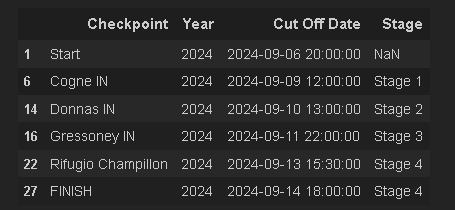

In [89]:
# Saving this 
lifebase_cut_offs_df = pd.read_excel(f'{race} Data/4. TOR450 Timetable Data/{race}_lifebase_cut_offs_df.xlsx')

# # # Convert integer seconds to timedelta
lifebase_cut_offs_df['Lifebase Duration'] = pd.to_timedelta(lifebase_cut_offs_df['Lifebase Duration_seconds'], unit='s')

# # # Convert integer seconds to timedelta
lifebase_cut_offs_df['Running Total Lifebase Duration'] = pd.to_timedelta(lifebase_cut_offs_df['Running Total Lifebase Duration_seconds'], unit='s')

lifebase_cut_offs_df = lifebase_cut_offs_df[['Lifebase',  'Lifebase Duration','Running Total Lifebase Duration']]
lifebase_cut_offs_df


Lifebase Lifebase Duration Running Total Lifebase Duration
0      Cogne IN   2 days 16:00:00                 2 days 16:00:00
1     Donnas IN   1 days 01:00:00                 3 days 17:00:00
2  Gressoney IN   1 days 09:00:00                 5 days 02:00:00
3        FINISH   2 days 20:00:00                 7 days 22:00:00

In [90]:
# # Saving this # Saving this 
# aid_station_cut_offs_df = pd.read_excel(f'{race} Data/4. TOR450 Timetable Data/{race}_aid_station_cut_offs_df.xlsx')

# # # # # Convert integer seconds to timedelta
# aid_station_cut_offs_df['Checkpoint Duration'] = pd.to_timedelta(aid_station_cut_offs_df['Checkpoint Duration_seconds'], unit='s')

# # # # Convert integer seconds to timedelta
# aid_station_cut_offs_df['Running Total Checkpoint Duration'] = pd.to_timedelta(aid_station_cut_offs_df['Running Total Checkpoint Duration_seconds'], unit='s')

# aid_station_cut_offs_df = aid_station_cut_offs_df[['Checkpoint', 'Stage', 'Checkpoint Duration','Running Total Checkpoint Duration']]
# aid_station_cut_offs_df



In [91]:
# Saving this 
checkpoints_cut_offs_df = pd.read_excel(f'{race} Data/4. TOR450 Timetable Data/{race}_checkpoint_cut_offs_df.xlsx')

# # # Convert integer seconds to timedelta
checkpoints_cut_offs_df['Checkpoint Duration'] = pd.to_timedelta(checkpoints_cut_offs_df['Checkpoint Duration_seconds'], unit='s')

# # # Convert integer seconds to timedelta
checkpoints_cut_offs_df['Running Total Checkpoint Duration'] = pd.to_timedelta(checkpoints_cut_offs_df['Running Total Checkpoint Duration_seconds'], unit='s')

checkpoints_cut_offs_df = checkpoints_cut_offs_df[['Checkpoint',  'Checkpoint Duration','Running Total Checkpoint Duration']]
checkpoints_cut_offs_df


Checkpoint Checkpoint Duration Running Total Checkpoint Duration
0            Cogne IN     2 days 16:00:00                   2 days 16:00:00
1           Donnas IN     1 days 01:00:00                   3 days 17:00:00
2        Gressoney IN     1 days 09:00:00                   5 days 02:00:00
3  Rifugio Champillon     1 days 17:30:00                   6 days 19:30:00
4              FINISH     1 days 02:30:00                   7 days 22:00:00

In [92]:
cutoffs_df_pivot = pd.read_excel(f'{race} Data/4. TOR450 Timetable Data/{race}_aid_station_for_each_year_cut_offs_df.xlsx')
cutoffs_df_pivot['Year'] = cutoffs_df_pivot['Year'].astype('int')
cutoffs_df_pivot['Year'] = cutoffs_df_pivot['Year'].astype('str')

    
cutoffs_df_pivot = cutoffs_df_pivot[['Checkpoint', 'Year', 'Cut Off Date']]
cutoffs_df_pivot[cutoffs_df_pivot['Year'] == '2024']

Checkpoint  Year        Cut Off Date
1                Start  2024 2024-09-06 20:00:00
6             Cogne IN  2024 2024-09-09 12:00:00
14           Donnas IN  2024 2024-09-10 13:00:00
16        Gressoney IN  2024 2024-09-11 22:00:00
22  Rifugio Champillon  2024 2024-09-13 15:30:00
27              FINISH  2024 2024-09-14 18:00:00

### Looking for the Polish Fella!

When I ran TOR 2023, I distingly remember running into a Polish fella as I was leaving Gressoney. I was hiking with him from Rifugio Barma, he was in Wave 1. I remember running up to him at the lifebase, all excited "Hey, you made it!"

The reply I recieved was "WHat are you talking about? I missed the cutoff"

So I began looking for him to find out why I dont have more people who missed the cut off!

Here I am leaving Gressoney!

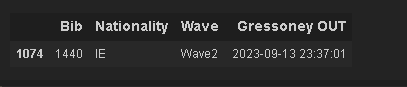

This is the cut off times
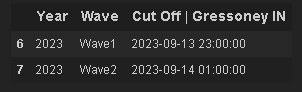

I looked for all the Poles that DNFed the race

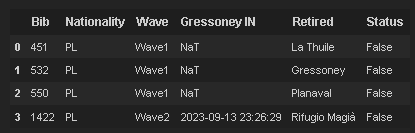

It is clear that he DNFed at 'Gressoney OUT - RITIRIO' 
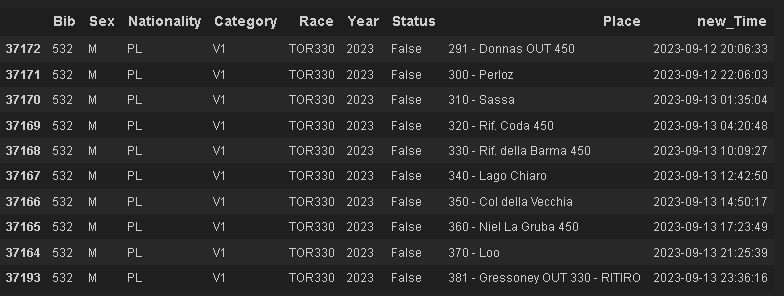
This is what is causing my heartache!



### SOLUTION
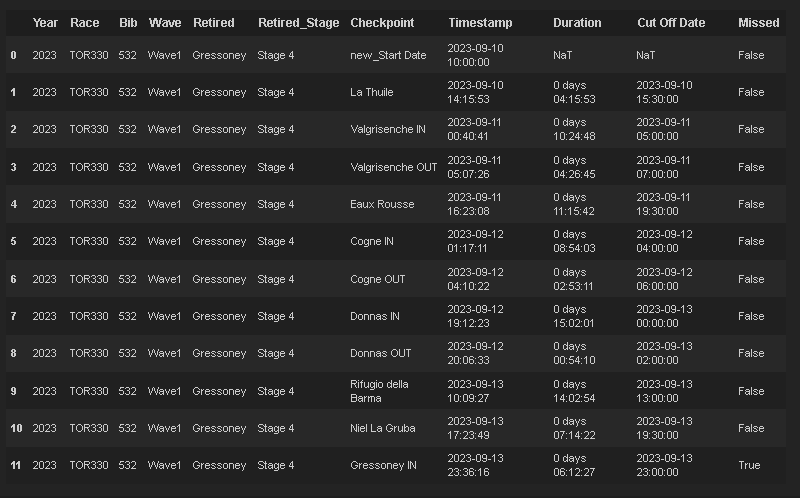


## Missed Cut Off - Function

In [93]:

def checking_cut_offs(df, column, stats_cut_offs_df, category_order):
    # Examining only finishers
    TORX_list = []
    n=0

    for year in years:
        year_df = df[df['Year'] == year]
        print('*'*50, '\n', year)
        for unique_bib in year_df['Bib'].unique(): 

            # Filter the dataframe for the current unique_bib
            bib_df = year_df[year_df['Bib'] == unique_bib].reset_index(drop = True)


            # Set 'Finish Category' as a categorical column with the defined order
            bib_df[column] = pd.Categorical(
                bib_df[column],
                categories = category_order,
                ordered=True)
            bib_df = bib_df.sort_values(by = column,  ascending =  True)
            

            retired_location = TOR450_dem['Retired'][TOR450_dem['Bib'] == unique_bib].values[0]
            n = n+1
            print(n, f'Processing Bib: {unique_bib}')
            # Ensure retired_location is not NaN
            if pd.isna(retired_location):
        #         print(retired_location)
                # Example: Calculating duration for finished participants
                bib_df['Duration'] = bib_df['Timestamp'].diff()
            else:

                # FIxing the Polish fella issue!
                retired_location = TOR450_dem['Retired'][TOR450_dem['Bib'] == unique_bib].values[0]
        #         print(f"Processing Bib: {unique_bib}, Retired Location: {retired_location}")
        #         print(bib_df[column].nunique())


                # Iterate over the rows to process the data
                for idx, row in bib_df.iterrows():
                    checkpoint = bib_df.at[idx, column]

                    ############ FIXING THE POLISH MAN 532 issue!
                    if retired_location in checkpoint:
                        # Check if the checkpoint does not contain 'OUT' or 'IN'
                        if 'OUT' in  checkpoint or 'IN' in checkpoint:

                            # If the checkpoint is retired_location + 'IN' and Timestamp is NaN
                            if checkpoint == f"{retired_location} IN" and pd.isna(row['Timestamp']):
                                # Locate the 'OUT' checkpoint row
                                out_row = bib_df[bib_df[column] == f"{retired_location} OUT"]
                                # Use the Timestamp from 'OUT'
                                bib_df.at[idx, 'Timestamp'] = out_row['Timestamp'].values[0]

                                # Make the next Timestamp Nan
                                bib_df.at[idx +1, 'Timestamp'] = pd.NaT
                                print(idx, idx+1)

            bib_df['Duration'] = bib_df['Timestamp'].diff()    

            bib_df['Duration_seconds'] = pd.to_timedelta( bib_df['Duration'], errors='coerce').dt.total_seconds()

            # Extract the start date timestamp
            bib_start_date = bib_df.loc[bib_df[column] == "START", 'Timestamp'].values[0]

            # Calculate running total duration
            bib_df['Running Total Duration'] = bib_df['Timestamp'] - bib_start_date

            # Convert duration to seconds
            bib_df['Running Total Duration_seconds'] = pd.to_timedelta(
                bib_df['Running Total Duration'], errors='coerce'
            ).dt.total_seconds()

            # Append the processed DataFrame to the list
            TORX_list.append(bib_df)
        #     print(f"Processed {n} Bib(s).", unique_bib)

    # Combine all results into one DataFrame
    if TORX_list:
        final_df = pd.concat(TORX_list, ignore_index=True)
        print("Combined DataFrame created.")
    else:
        final_df = pd.DataFrame()
        print("No DataFrames were processed.")

    print(final_df.columns)
    print(cutoffs_df_pivot.columns)

    if column == 'Checkpoint':

        final_df = final_df.merge(
            cutoffs_df_pivot,
            on=[column,  'Year'],
            how='left')


        final_df['Missed Last Checkpoint'] = np.where(
            ((final_df['Checkpoint'] == final_df['Retired'] + ' IN') |
            (final_df['Checkpoint'] == final_df['Retired'] + ' OUT')) &
            (final_df['Timestamp'] > final_df['Cut Off Date'] ),
            True,
            False
        ) 

        final_df = final_df.merge(
            stats_cut_offs_df[[column, f'{column} Duration']],
            on=column,
            how='left')    
        final_df['Missed Lifebase Allocated Time'] = np.where(
             final_df['Duration'] > final_df[f'{column} Duration'],
             'Outside Allocated Time ',
             'Within Allocated Time') 

        print( '\n', final_df[final_df['Bib'] == 1], '\n')



    elif column == 'Lifebase':
        final_df = final_df.rename(columns={"Lifebase": "Checkpoint"}) 

        print(f'column == {column}')
        final_df = final_df.merge(
            cutoffs_df_pivot,
            right_on=['Checkpoint',  'Year'],
            left_on=['Checkpoint',  'Year'],
            how='left')       
        final_df = final_df.rename(columns={"Checkpoint": "Lifebase"}) 

        final_df['Missed Last Checkpoint'] = np.where(
            ((final_df['Lifebase'] == final_df['Retired'] + ' IN') |
            (final_df['Lifebase'] == final_df['Retired'] + ' OUT')) &
            (final_df['Timestamp'] > final_df['Cut Off Date'] ),
            True,
            False
        ) 

        final_df = final_df.merge(
            stats_cut_offs_df[[column, f'{column} Duration']],
            on=column,
            how='left')  

        final_df['Missed Lifebase Allocated Time'] = np.where(
             final_df['Duration'] > final_df[f'{column} Duration'],
             'Outside Allocated Time ',
             'Within Allocated Time') 



    else:
        print('BOo')


            # Compare 'Timestamp' with the cutoff
    final_df['Missed'] = final_df['Timestamp'] >   final_df['Cut Off Date']
    final_df['Missed Diff'] = np.where(
        final_df['Timestamp'] > final_df['Cut Off Date'],
        final_df['Timestamp'] - final_df['Cut Off Date'],
        pd.NaT  # Ensure missing values are compatible with timedelta64
    )

    print(final_df[final_df['Timestamp'] > final_df['Cut Off Date']])

    # Explicitly cast 'Missed Diff' to timedelta64[ns] to enforce the type
    final_df['Missed Diff'] = final_df['Missed Diff'].astype('timedelta64[ns]')
#     final_df['Missed Last Checkpoint'] = final_df['Missed Last Checkpoint'].fillna(False)


    # tableau prep
    final_df['Missed Diff_seconds'] = pd.to_timedelta(
        final_df['Missed Diff'], errors='coerce').dt.total_seconds()

    if column  == 'Checkpoint':
        final_df['Missed Last Checkpoint'][~(final_df['Missed Diff'].isna()) &
                            ~(final_df['Retired'].isna()) &
                            ~(final_df['Checkpoint' ].str.contains(' OUT')) &
                            ~(final_df['Checkpoint' ].str.contains(' IN')) &
                            ( final_df['Checkpoint' ] ==  final_df['Retired'])] = True  

    return final_df

### Checkpoints

In [94]:
melt_checkpoint_df[(melt_checkpoint_df['Name'] == 'Tierney Paul') &
                  (melt_checkpoint_df['Year'] == '2022')]

PK    Race  Year   Bib          Name  \
115   TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
644   TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1173  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1702  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
2231  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
2760  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
3289  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
3818  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
4347  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   

                     Status1  Status Retired Retired_Stage         Diversion  \
115   Finished at Courmayeur    True                        As Planned Route   
644   Finished at Courmayeur    True                        As Planned Route   
1173  Finished at Courmayeur    True                        As Planned Route   
1702  Finished at Courmayeur    True                        As Planned Route   
2231  Finished at Courmayeur    True                        As Planned Route   
2760  Finished at Courmayeur    True                        As Planned Route   
3289  Finished at Courmayeur    True                        As Planned Route   
3818  Finished at Courmayeur    True                        As Planned Route   
4347  Finished at Courmayeur    True                        As Planned Route   

              Checkpoint           Timestamp                    Stage  
115                START 2022-09-09 20:00:00                  Stage 1  
644             Cogne IN 2022-09-11 12:04:23                  Stage 1  
1173           Cogne OUT 2022-09-11 13:04:11      Time Spent in Cogne  
1702           Donnas IN 2022-09-12 09:38:28                  Stage 2  
2231          Donnas OUT 2022-09-12 10:39:37     Time Spent in Donnas  
2760        Gressoney IN 2022-09-13 07:50:47                  Stage 3  
3289       Gressoney OUT 2022-09-13 09:50:18  Time Spent in Gressoney  
3818  Rifugio Champillon 2022-09-14 20:39:10                  Stage 4  
4347              FINISH 2022-09-15 12:23:20                  Stage 4

In [95]:
checkpoints_bib_df = checking_cut_offs(melt_checkpoint_df, 'Checkpoint', 
                                       checkpoints_cut_offs_df , checkpoint_category_order)

************************************************** 
 2021
1 Processing Bib: 4001
2 Processing Bib: 4003
3 Processing Bib: 4004
4 Processing Bib: 4005
5 Processing Bib: 4006
6 Processing Bib: 4008
7 Processing Bib: 4009
8 Processing Bib: 4010
9 Processing Bib: 4011
10 Processing Bib: 4012
11 Processing Bib: 4014
12 Processing Bib: 4015
13 Processing Bib: 4016
14 Processing Bib: 4017
15 Processing Bib: 4018
16 Processing Bib: 4019
17 Processing Bib: 4020
18 Processing Bib: 4021
19 Processing Bib: 4023
20 Processing Bib: 4024
21 Processing Bib: 4025
22 Processing Bib: 4026
23 Processing Bib: 4027
24 Processing Bib: 4028
25 Processing Bib: 4029
26 Processing Bib: 4030
27 Processing Bib: 4031
28 Processing Bib: 4032
29 Processing Bib: 4034
30 Processing Bib: 4035
31 Processing Bib: 4036
32 Processing Bib: 4037
33 Processing Bib: 4038
34 Processing Bib: 4039
35 Processing Bib: 4040
36 Processing Bib: 4042
37 Processing Bib: 4043
38 Processing Bib: 4044
39 Processing Bib: 4045
40 Processing B

333 Processing Bib: 4159
334 Processing Bib: 4160
335 Processing Bib: 4161
336 Processing Bib: 4162
337 Processing Bib: 4163
338 Processing Bib: 4164
339 Processing Bib: 4165
340 Processing Bib: 4166
341 Processing Bib: 4167
342 Processing Bib: 4168
343 Processing Bib: 4169
344 Processing Bib: 4170
345 Processing Bib: 4171
346 Processing Bib: 4172
347 Processing Bib: 4173
348 Processing Bib: 4174
349 Processing Bib: 4175
350 Processing Bib: 4176
351 Processing Bib: 4177
352 Processing Bib: 4178
353 Processing Bib: 4179
354 Processing Bib: 4180
355 Processing Bib: 4181
356 Processing Bib: 4182
357 Processing Bib: 4185
358 Processing Bib: 4186
359 Processing Bib: 4187
360 Processing Bib: 4188
************************************************** 
 2024
361 Processing Bib: 4001
362 Processing Bib: 4002
363 Processing Bib: 4003
364 Processing Bib: 4004
365 Processing Bib: 4006
366 Processing Bib: 4007
367 Processing Bib: 4008
368 Processing Bib: 4009
369 Processing Bib: 4010
370 Processing Bi

C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\608151596.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Missed Last Checkpoint'][~(final_df['Missed Diff'].isna()) &


In [96]:
checkpoints_bib_df['Missed Last Checkpoint'].unique()

array([False,  True])

In [97]:
checkpoints_bib_df.columns

Index(['PK', 'Race', 'Year', 'Bib', 'Name', 'Status1', 'Status', 'Retired',
       'Retired_Stage', 'Diversion', 'Checkpoint', 'Timestamp', 'Stage',
       'Duration', 'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds', 'Cut Off Date',
       'Missed Last Checkpoint', 'Checkpoint Duration',
       'Missed Lifebase Allocated Time', 'Missed', 'Missed Diff',
       'Missed Diff_seconds'],
      dtype='object')

In [98]:
checkpoints_bib_df[(checkpoints_bib_df['Name'] == 'Tierney Paul') &
                  (checkpoints_bib_df['Year'] == '2022')]

PK    Race  Year   Bib          Name  \
1035  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1036  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1037  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1038  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1039  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1040  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1041  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1042  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   
1043  TOR450_2022_4063  TOR450  2022  4063  Tierney Paul   

                     Status1  Status Retired Retired_Stage         Diversion  \
1035  Finished at Courmayeur    True                        As Planned Route   
1036  Finished at Courmayeur    True                        As Planned Route   
1037  Finished at Courmayeur    True                        As Planned Route   
1038  Finished at Courmayeur    True                        As Planned Route   
1039  Finished at Courmayeur    True                        As Planned Route   
1040  Finished at Courmayeur    True                        As Planned Route   
1041  Finished at Courmayeur    True                        As Planned Route   
1042  Finished at Courmayeur    True                        As Planned Route   
1043  Finished at Courmayeur    True                        As Planned Route   

      ... Duration_seconds Running Total Duration  \
1035  ...              NaN        0 days 00:00:00   
1036  ...         144263.0        1 days 16:04:23   
1037  ...           3588.0        1 days 17:04:11   
1038  ...          74057.0        2 days 13:38:28   
1039  ...           3669.0        2 days 14:39:37   
1040  ...          76270.0        3 days 11:50:47   
1041  ...           7171.0        3 days 13:50:18   
1042  ...         125332.0        5 days 00:39:10   
1043  ...          56650.0        5 days 16:23:20   

     Running Total Duration_seconds        Cut Off Date  \
1035                            0.0                 NaT   
1036                       144263.0 2022-09-12 12:00:00   
1037                       147851.0                 NaT   
1038                       221908.0 2022-09-13 13:00:00   
1039                       225577.0                 NaT   
1040                       301847.0 2022-09-14 22:00:00   
1041                       309018.0                 NaT   
1042                       434350.0 2022-09-16 15:30:00   
1043                       491000.0 2022-09-17 18:00:00   

      Missed Last Checkpoint Checkpoint Duration  \
1035                   False                 NaT   
1036                   False     2 days 16:00:00   
1037                   False                 NaT   
1038                   False     1 days 01:00:00   
1039                   False                 NaT   
1040                   False     1 days 09:00:00   
1041                   False                 NaT   
1042                   False     1 days 17:30:00   
1043                   False     1 days 02:30:00   

      Missed Lifebase Allocated Time Missed  Missed Diff Missed Diff_seconds  
1035           Within Allocated Time  False          NaT                 NaN  
1036           Within Allocated Time  False          NaT                 NaN  
1037           Within Allocated Time  False          NaT                 NaN  
1038           Within Allocated Time  False          NaT                 NaN  
1039           Within Allocated Time  False          NaT                 NaN  
1040           Within Allocated Time  False          NaT                 NaN  
1041           Within Allocated Time  False          NaT                 NaN  
1042           Within Allocated Time  False          NaT                 NaN  
1043           Within Allocated Time  False          NaT                 NaN  

[9 rows x 24 columns]

In [99]:
tierney_df = checkpoints_bib_df[(checkpoints_bib_df['Name'] == 'Tierney Paul') &
                  (checkpoints_bib_df['Year'] == '2022')]
# tierney_df['DIFF'] = tierney_df['Timestamp'].diff()
tierney_df[['Name', 'Bib', 'Race', 'Year', 'Status', 'Checkpoint', 'Timestamp', 'Duration',
       'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds',  'Stage',
      'Checkpoint Duration']]

Name   Bib    Race  Year  Status          Checkpoint  \
1035  Tierney Paul  4063  TOR450  2022    True               START   
1036  Tierney Paul  4063  TOR450  2022    True            Cogne IN   
1037  Tierney Paul  4063  TOR450  2022    True           Cogne OUT   
1038  Tierney Paul  4063  TOR450  2022    True           Donnas IN   
1039  Tierney Paul  4063  TOR450  2022    True          Donnas OUT   
1040  Tierney Paul  4063  TOR450  2022    True        Gressoney IN   
1041  Tierney Paul  4063  TOR450  2022    True       Gressoney OUT   
1042  Tierney Paul  4063  TOR450  2022    True  Rifugio Champillon   
1043  Tierney Paul  4063  TOR450  2022    True              FINISH   

               Timestamp        Duration  Duration_seconds  \
1035 2022-09-09 20:00:00             NaT               NaN   
1036 2022-09-11 12:04:23 1 days 16:04:23          144263.0   
1037 2022-09-11 13:04:11 0 days 00:59:48            3588.0   
1038 2022-09-12 09:38:28 0 days 20:34:17           74057.0   
1039 2022-09-12 10:39:37 0 days 01:01:09            3669.0   
1040 2022-09-13 07:50:47 0 days 21:11:10           76270.0   
1041 2022-09-13 09:50:18 0 days 01:59:31            7171.0   
1042 2022-09-14 20:39:10 1 days 10:48:52          125332.0   
1043 2022-09-15 12:23:20 0 days 15:44:10           56650.0   

     Running Total Duration  Running Total Duration_seconds  \
1035        0 days 00:00:00                             0.0   
1036        1 days 16:04:23                        144263.0   
1037        1 days 17:04:11                        147851.0   
1038        2 days 13:38:28                        221908.0   
1039        2 days 14:39:37                        225577.0   
1040        3 days 11:50:47                        301847.0   
1041        3 days 13:50:18                        309018.0   
1042        5 days 00:39:10                        434350.0   
1043        5 days 16:23:20                        491000.0   

                        Stage Checkpoint Duration  
1035                  Stage 1                 NaT  
1036                  Stage 1     2 days 16:00:00  
1037      Time Spent in Cogne                 NaT  
1038                  Stage 2     1 days 01:00:00  
1039     Time Spent in Donnas                 NaT  
1040                  Stage 3     1 days 09:00:00  
1041  Time Spent in Gressoney                 NaT  
1042                  Stage 4     1 days 17:30:00  
1043                  Stage 4     1 days 02:30:00

### Time Travel Issues
I filtered the data to spot any time travel moments!

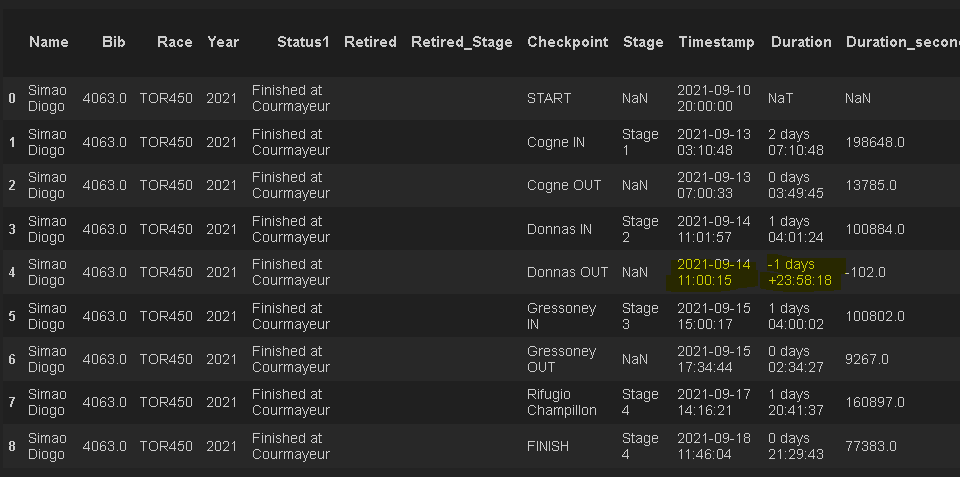

### Solution
Replacing the negative value with NAN
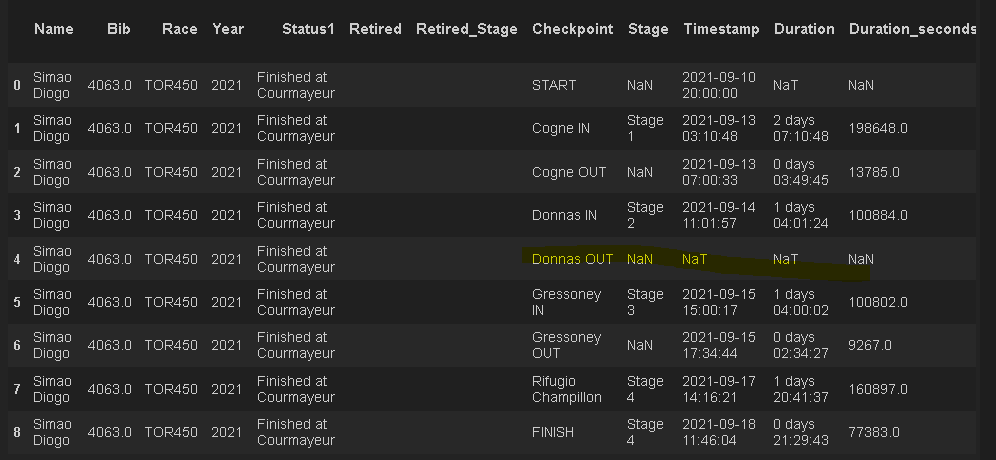

##### Time Travel issues in Checkpoint

In [100]:
unique_bibs_with_negative_values_in_checkpoints_bib_df = list(checkpoints_bib_df['Bib'][checkpoints_bib_df['Duration']  <= pd.to_timedelta('00:00:00')].unique())
unique_bibs_with_negative_values_in_checkpoints_bib_df = [int(bib) for bib in unique_bibs_with_negative_values_in_checkpoints_bib_df]

checkpoints_bib_df[checkpoints_bib_df['Duration']  <= pd.to_timedelta('00:00:00')]

PK    Race  Year   Bib         Name  \
481  TOR450_2021_4063  TOR450  2021  4063  Simao Diogo   

                    Status1  Status Retired Retired_Stage         Diversion  \
481  Finished at Courmayeur    True                        As Planned Route   

     ... Duration_seconds Running Total Duration  \
481  ...           -102.0        3 days 15:00:15   

    Running Total Duration_seconds Cut Off Date  Missed Last Checkpoint  \
481                       313215.0          NaT                   False   

    Checkpoint Duration  Missed Lifebase Allocated Time Missed  Missed Diff  \
481                 NaT           Within Allocated Time  False          NaT   

    Missed Diff_seconds  
481                 NaN  

[1 rows x 24 columns]

In [101]:
unique_bibs_with_negative_values_in_checkpoints_bib_df

[4063]

In [102]:

checkpoints_bib_df[['Name', 'Bib', 'Race', 'Year', 'Status1', 'Retired',
       'Retired_Stage', 'Checkpoint','Stage', 'Timestamp', 'Duration',
       'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds']][(checkpoints_bib_df['Bib'] == '4063') & 
                                          (checkpoints_bib_df['Year'] == '2021')].reset_index(drop = True)

Name   Bib    Race  Year                 Status1 Retired  \
0  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
1  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
2  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
3  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
4  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
5  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
6  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
7  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
8  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           

  Retired_Stage          Checkpoint                    Stage  \
0                             START                  Stage 1   
1                          Cogne IN                  Stage 1   
2                         Cogne OUT      Time Spent in Cogne   
3                         Donnas IN                  Stage 2   
4                        Donnas OUT     Time Spent in Donnas   
5                      Gressoney IN                  Stage 3   
6                     Gressoney OUT  Time Spent in Gressoney   
7                Rifugio Champillon                  Stage 4   
8                            FINISH                  Stage 4   

            Timestamp          Duration  Duration_seconds  \
0 2021-09-10 20:00:00               NaT               NaN   
1 2021-09-13 03:10:48   2 days 07:10:48          198648.0   
2 2021-09-13 07:00:33   0 days 03:49:45           13785.0   
3 2021-09-14 11:01:57   1 days 04:01:24          100884.0   
4 2021-09-14 11:00:15 -1 days +23:58:18            -102.0   
5 2021-09-15 15:00:17   1 days 04:00:02          100802.0   
6 2021-09-15 17:34:44   0 days 02:34:27            9267.0   
7 2021-09-17 14:16:21   1 days 20:41:37          160897.0   
8 2021-09-18 11:46:04   0 days 21:29:43           77383.0   

  Running Total Duration  Running Total Duration_seconds  
0        0 days 00:00:00                             0.0  
1        2 days 07:10:48                        198648.0  
2        2 days 11:00:33                        212433.0  
3        3 days 15:01:57                        313317.0  
4        3 days 15:00:15                        313215.0  
5        4 days 19:00:17                        414017.0  
6        4 days 21:34:44                        423284.0  
7        6 days 18:16:21                        584181.0  
8        7 days 15:46:04                        661564.0

In [103]:
fixing_negative_duration(checkpoints_bib_df)

In [104]:
checkpoints_bib_df =  calculating_banked_time(checkpoints_bib_df, checkpoints_cut_offs_df, 'Checkpoint')
checkpoints_bib_df.head(20)

Empty DataFrame
Columns: []
Index: [Bib, Checkpoint, Running Total Checkpoint Duration, Running Total Duration, Banking Time]


PK    Race  Year   Bib           Name  \
0   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
1   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
2   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
3   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
4   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
5   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
6   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
7   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
8   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
9   TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
10  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
11  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
12  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
13  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
14  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
15  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
16  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
17  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
18  TOR450_2021_4004  TOR450  2021  4004     Neale Matt   
19  TOR450_2021_4004  TOR450  2021  4004     Neale Matt   

                   Status1  Status Retired Retired_Stage         Diversion  \
0   Finished at Courmayeur    True                        As Planned Route   
1   Finished at Courmayeur    True                        As Planned Route   
2   Finished at Courmayeur    True                        As Planned Route   
3   Finished at Courmayeur    True                        As Planned Route   
4   Finished at Courmayeur    True                        As Planned Route   
5   Finished at Courmayeur    True                        As Planned Route   
6   Finished at Courmayeur    True                        As Planned Route   
7   Finished at Courmayeur    True                        As Planned Route   
8   Finished at Courmayeur    True                        As Planned Route   
9   Finished at Courmayeur    True                        As Planned Route   
10  Finished at Courmayeur    True                        As Planned Route   
11  Finished at Courmayeur    True                        As Planned Route   
12  Finished at Courmayeur    True                        As Planned Route   
13  Finished at Courmayeur    True                        As Planned Route   
14  Finished at Courmayeur    True                        As Planned Route   
15  Finished at Courmayeur    True                        As Planned Route   
16  Finished at Courmayeur    True                        As Planned Route   
17  Finished at Courmayeur    True                        As Planned Route   
18  Finished at Courmayeur    True                        As Planned Route   
19  Finished at Courmayeur    True                        As Planned Route   

    ...        Cut Off Date Missed Last Checkpoint Checkpoint Duration  \
0   ...                 NaT                  False                 NaT   
1   ... 2021-09-13 12:00:00                  False     2 days 16:00:00   
2   ...                 NaT                  False                 NaT   
3   ... 2021-09-14 13:00:00                  False     1 days 01:00:00   
4   ...                 NaT                  False                 NaT   
5   ... 2021-09-15 22:00:00                  False     1 days 09:00:00   
6   ...                 NaT                  False                 NaT   
7   ... 2021-09-17 15:30:00                  False     1 days 17:30:00   
8   ... 2021-09-18 18:00:00                  False     1 days 02:30:00   
9   ...                 NaT                  False                 NaT   
10  ... 2021-09-13 12:00:00                  False     2 days 16:00:00   
11  ...                 NaT                  False                 NaT   
12  ... 2021-09-14 13:00:00                  False     1 days 01:00:00   
13  ...                 NaT                  False                 NaT   
14  ... 2021-09-15 22:00:00  

In [105]:
checkpoints_bib_df[['Name', 'Bib', 'Race', 'Year', 'Checkpoint', 'Stage', 'Status1', 'Status', 'Retired',
       'Retired_Stage', 'Diversion', 'Timestamp', 'Duration',
       'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds', 'Cut Off Date',
       'Missed Last Checkpoint', 'Checkpoint Duration',
       'Missed Lifebase Allocated Time', 'Missed', 'Missed Diff',
       'Missed Diff_seconds', 'Running Total Checkpoint Duration',
       'Banking Time', 'Banking Time_seconds']].head(20)

Name   Bib    Race  Year          Checkpoint  \
0       Papi Luca  4001  TOR450  2021               START   
1       Papi Luca  4001  TOR450  2021            Cogne IN   
2       Papi Luca  4001  TOR450  2021           Cogne OUT   
3       Papi Luca  4001  TOR450  2021           Donnas IN   
4       Papi Luca  4001  TOR450  2021          Donnas OUT   
5       Papi Luca  4001  TOR450  2021        Gressoney IN   
6       Papi Luca  4001  TOR450  2021       Gressoney OUT   
7       Papi Luca  4001  TOR450  2021  Rifugio Champillon   
8       Papi Luca  4001  TOR450  2021              FINISH   
9   Plavan Marina  4003  TOR450  2021               START   
10  Plavan Marina  4003  TOR450  2021            Cogne IN   
11  Plavan Marina  4003  TOR450  2021           Cogne OUT   
12  Plavan Marina  4003  TOR450  2021           Donnas IN   
13  Plavan Marina  4003  TOR450  2021          Donnas OUT   
14  Plavan Marina  4003  TOR450  2021        Gressoney IN   
15  Plavan Marina  4003  TOR450  2021       Gressoney OUT   
16  Plavan Marina  4003  TOR450  2021  Rifugio Champillon   
17  Plavan Marina  4003  TOR450  2021              FINISH   
18     Neale Matt  4004  TOR450  2021               START   
19     Neale Matt  4004  TOR450  2021            Cogne IN   

                      Stage                 Status1  Status Retired  \
0                   Stage 1  Finished at Courmayeur    True           
1                   Stage 1  Finished at Courmayeur    True           
2       Time Spent in Cogne  Finished at Courmayeur    True           
3                   Stage 2  Finished at Courmayeur    True           
4      Time Spent in Donnas  Finished at Courmayeur    True           
5                   Stage 3  Finished at Courmayeur    True           
6   Time Spent in Gressoney  Finished at Courmayeur    True           
7                   Stage 4  Finished at Courmayeur    True           
8                   Stage 4  Finished at Courmayeur    True           
9                   Stage 1  Finished at Courmayeur    True           
10                  Stage 1  Finished at Courmayeur    True           
11      Time Spent in Cogne  Finished at Courmayeur    True           
12                  Stage 2  Finished at Courmayeur    True           
13     Time Spent in Donnas  Finished at Courmayeur    True           
14                  Stage 3  Finished at Courmayeur    True           
15  Time Spent in Gressoney  Finished at Courmayeur    True           
16                  Stage 4  Finished at Courmayeur    True           
17                  Stage 4  Finished at Courmayeur    True           
18                  Stage 1  Finished at Courmayeur    True           
19                  Stage 1  Finished at Courmayeur    True           

   Retired_Stage  ...        Cut Off Date Missed Last Checkpoint  \
0                 ...                 NaT                  False   
1                 ... 2021-09-13 12:00:00                  False   
2                 ...                 NaT                  False   
3                 ... 2021-09-14 13:00:00                  False   
4                 ...                 NaT                  False   
5                 ... 2021-09-15 22:00:00                  False   
6                 ...                 NaT                  False   
7                 ... 2021-09-17 15:30:00                  False   
8                 ... 2021-09-18 18:00:00                  False   
9                 ...                 NaT                  False   
10                ... 2021-09-13 12:00:00                  False   
11                ...                 NaT                  False   
12                ... 2021-09-14 13:00:00                  False   
13                ...                 NaT                  False   
14                ... 2021-09-15 22:00:00                  False   
15                ...                 NaT                  False   
16                ... 2021-09-17 15:30:00                  False   
17             

### Adding information related to the last missed cut off to TOR450 Dem

In [106]:
# Merge the datsets back after pivoting
TOR450_dem = TOR450_dem.merge(
    checkpoints_bib_df[[ 'Year', 'Race',  'Bib',  'Missed Last Checkpoint',
                        'Missed Diff',  'Missed Diff_seconds']][(checkpoints_bib_df['Missed Last Checkpoint'] == True)],
    on=['Year', 'Race','Bib'],
    how='left')


TOR450_dem = TOR450_dem.reset_index(drop = True)

TOR450_dem

Name   Bib Sex Nationality Category    Race  Year  \
0                    Adam Eric  4052   M          AT       V1  TOR450  2022   
1                 Ador Thierry  4005   M          FR       V2  TOR450  2022   
2             Ageorges Fabrice  4025   M          FR       V1  TOR450  2022   
3                Anderson John  4072   M          US       V1  TOR450  2022   
4    Angel Andrade Julio Cesar  4137   M          MX       V2  TOR450  2022   
..                         ...   ...  ..         ...      ...     ...   ...   
552          Teuscher Christof  4014   M          US       V1  TOR450  2021   
553          Traina Christophe  4034   M          BE       V1  TOR450  2021   
554           Tribolo Philippe  4039   M          FR       V1  TOR450  2021   
555  Van Der Hoeven Jan Jilles  4016   M          AE       V2  TOR450  2021   
556           Vincent Wendling  4047   M          FR       V2  TOR450  2021   

     Status        Duration  Duration_hours  Duration_seconds Finish Category  \
0      True 7 days 13:01:00      181.016667          651660.0         Sub-190   
1     False             NaT             NaN               NaN             DNF   
2     False             NaT             NaN               NaN             DNF   
3      True 6 days 17:33:50      161.563889          581630.0         Sub-170   
4     False             NaT             NaN               NaN             DNF   
..      ...             ...             ...               ...             ...   
552    True 7 days 15:01:05      183.018056          658865.0         Sub-190   
553    True 7 days 17:00:24      185.006667          666024.0         Sub-190   
554    True 7 days 16:24:31      184.408611          663871.0         Sub-190   
555   False             NaT             NaN               NaN             DNF   
556    True 7 days 18:50:41      186.844722          672641.0         Sub-190   

                   PK Status1 Retired Retired_Stage Diversion  \
0    TOR450_2021_4001     NaN     NaN           NaN       NaN   
1    TOR450_2021_4001     NaN     NaN           NaN       NaN   
2    TOR450_2021_4001     NaN     NaN           NaN       NaN   
3    TOR450_2021_4001     NaN     NaN           NaN       NaN   
4    TOR450_2021_4001     NaN     NaN           NaN       NaN   
..                ...     ...     ...           ...       ...   
552  TOR450_2021_4026     NaN     NaN           NaN       NaN   
553  TOR450_2021_4026     NaN     NaN           NaN       NaN   
554  TOR450_2021_4026     NaN     NaN           NaN       NaN   
555  TOR450_2021_4026     NaN     NaN           NaN       NaN   
556  TOR450_2021_4026     NaN     NaN           NaN       NaN   

    Missed Last Checkpoint Missed Diff  Missed Diff_seconds  
0                      NaN         NaT                  NaN  
1                      NaN         NaT                  NaN  
2                      NaN         NaT                  NaN  
3                      NaN         NaT                  NaN  
4                      NaN         NaT                  NaN  
..                     ...         ...                  ...  
552                    NaN         NaT                  NaN  
553                    NaN         NaT                  NaN  
554                    NaN         NaT                  NaN  
555                    NaN         NaT                  NaN  
556                    NaN         NaT                  NaN  

[557 rows x 20 columns]

In [107]:
TOR450_dem.groupby('Retired')['Retired'].count()

Series([], Name: Retired, dtype: int64)

In [108]:
TOR450_dem.groupby('Diversion')['Diversion'].count()

Diversion
As Planned Route    1
Name: Diversion, dtype: int64

In [109]:
TOR450_dem.groupby(['Retired_Stage'])['Retired_Stage'].count()

Series([], Name: Retired_Stage, dtype: int64)

#### Which Finishers missed the cut off?

In [110]:
checkpoints_bib_df[(checkpoints_bib_df['Missed'] == True) &
                  (checkpoints_bib_df['Retired'].isna())]

Empty DataFrame
Columns: [PK, Race, Year, Bib, Name, Status1, Status, Retired, Retired_Stage, Diversion, Checkpoint, Timestamp, Stage, Duration, Duration_seconds, Running Total Duration, Running Total Duration_seconds, Cut Off Date, Missed Last Checkpoint, Checkpoint Duration, Missed Lifebase Allocated Time, Missed, Missed Diff, Missed Diff_seconds, Running Total Checkpoint Duration, Banking Time, Banking Time_seconds]
Index: []

[0 rows x 27 columns]

### Lifebase DF

In [111]:
lifebase_bib_df = checking_cut_offs(melt_lifebase_df, 'Lifebase', lifebase_cut_offs_df, lifebase_category_order )
lifebase_bib_df.head(20)

************************************************** 
 2021
1 Processing Bib: 4001
2 Processing Bib: 4003
3 Processing Bib: 4004
4 Processing Bib: 4005
5 Processing Bib: 4006
6 Processing Bib: 4008
7 Processing Bib: 4009
8 Processing Bib: 4010
9 Processing Bib: 4011
10 Processing Bib: 4012
11 Processing Bib: 4014
12 Processing Bib: 4015
13 Processing Bib: 4016
14 Processing Bib: 4017
15 Processing Bib: 4018
16 Processing Bib: 4019
17 Processing Bib: 4020
18 Processing Bib: 4021
19 Processing Bib: 4023
20 Processing Bib: 4024
21 Processing Bib: 4025
22 Processing Bib: 4026
23 Processing Bib: 4027
24 Processing Bib: 4028
25 Processing Bib: 4029
26 Processing Bib: 4030
27 Processing Bib: 4031
28 Processing Bib: 4032
29 Processing Bib: 4034
30 Processing Bib: 4035
31 Processing Bib: 4036
32 Processing Bib: 4037
33 Processing Bib: 4038
34 Processing Bib: 4039
35 Processing Bib: 4040
36 Processing Bib: 4042
37 Processing Bib: 4043
38 Processing Bib: 4044
39 Processing Bib: 4045
40 Processing B

329 Processing Bib: 4155
330 Processing Bib: 4156
331 Processing Bib: 4157
332 Processing Bib: 4158
333 Processing Bib: 4159
334 Processing Bib: 4160
335 Processing Bib: 4161
336 Processing Bib: 4162
337 Processing Bib: 4163
338 Processing Bib: 4164
339 Processing Bib: 4165
340 Processing Bib: 4166
341 Processing Bib: 4167
342 Processing Bib: 4168
343 Processing Bib: 4169
344 Processing Bib: 4170
345 Processing Bib: 4171
346 Processing Bib: 4172
347 Processing Bib: 4173
348 Processing Bib: 4174
349 Processing Bib: 4175
350 Processing Bib: 4176
351 Processing Bib: 4177
352 Processing Bib: 4178
353 Processing Bib: 4179
354 Processing Bib: 4180
355 Processing Bib: 4181
356 Processing Bib: 4182
357 Processing Bib: 4185
358 Processing Bib: 4186
359 Processing Bib: 4187
360 Processing Bib: 4188
************************************************** 
 2024
361 Processing Bib: 4001
362 Processing Bib: 4002
363 Processing Bib: 4003
364 Processing Bib: 4004
365 Processing Bib: 4006
366 Processing Bi

PK    Race  Year   Bib           Name  \
0   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
1   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
2   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
3   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
4   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
5   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
6   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
7   TOR450_2021_4001  TOR450  2021  4001      Papi Luca   
8   TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
9   TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
10  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
11  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
12  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
13  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
14  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
15  TOR450_2021_4003  TOR450  2021  4003  Plavan Marina   
16  TOR450_2021_4004  TOR450  2021  4004     Neale Matt   
17  TOR450_2021_4004  TOR450  2021  4004     Neale Matt   
18  TOR450_2021_4004  TOR450  2021  4004     Neale Matt   
19  TOR450_2021_4004  TOR450  2021  4004     Neale Matt   

                   Status1  Status Retired Retired_Stage         Diversion  \
0   Finished at Courmayeur    True                        As Planned Route   
1   Finished at Courmayeur    True                        As Planned Route   
2   Finished at Courmayeur    True                        As Planned Route   
3   Finished at Courmayeur    True                        As Planned Route   
4   Finished at Courmayeur    True                        As Planned Route   
5   Finished at Courmayeur    True                        As Planned Route   
6   Finished at Courmayeur    True                        As Planned Route   
7   Finished at Courmayeur    True                        As Planned Route   
8   Finished at Courmayeur    True                        As Planned Route   
9   Finished at Courmayeur    True                        As Planned Route   
10  Finished at Courmayeur    True                        As Planned Route   
11  Finished at Courmayeur    True                        As Planned Route   
12  Finished at Courmayeur    True                        As Planned Route   
13  Finished at Courmayeur    True                        As Planned Route   
14  Finished at Courmayeur    True                        As Planned Route   
15  Finished at Courmayeur    True                        As Planned Route   
16  Finished at Courmayeur    True                        As Planned Route   
17  Finished at Courmayeur    True                        As Planned Route   
18  Finished at Courmayeur    True                        As Planned Route   
19  Finished at Courmayeur    True                        As Planned Route   

    ... Duration_seconds Running Total Duration  \
0   ...              NaN        0 days 00:00:00   
1   ...         145590.0        1 days 16:26:30   
2   ...           2909.0        1 days 17:14:59   
3   ...          83028.0        2 days 16:18:47   
4   ...           2769.0        2 days 17:04:56   
5   ...          77248.0        3 days 14:32:24   
6   ...           4018.0        3 days 15:39:22   
7   ...         182318.0        5 days 18:18:00   
8   ...              NaN        0 days 00:00:00   
9   ...         170973.0        1 days 23:29:33   
10  ...           5377.0        2 days 00:59:10   
11  ...          88255.0        3 days 01:30:05   
12  ...           1080.0        3 days 01:48:05   
13  ...              NaN                    NaT   
14  ...              NaN        4 days 07:26:06   
15  ...         223429.0        6 days 21:29:55   
16  ...              NaN        0 days 00:00:00   
17  ...         176886.0        2 days 01:08:06   
18  ...          16053.0        2 days 05:35:39   
19  ...          97480.0        3 days 08:40:19   

   Running Total Duration_seconds        Cut Off Date  Missed Last 

##### Time Travel issues in Lifebase DF 

In [112]:
unique_bibs_with_negative_values_in_lifebase_bib_df = list(lifebase_bib_df['Bib'][lifebase_bib_df['Duration']  <= pd.to_timedelta('00:00:00')].unique())
unique_bibs_with_negative_values_in_lifebase_bib_df = [int(bib) for bib in unique_bibs_with_negative_values_in_lifebase_bib_df]

lifebase_bib_df[lifebase_bib_df['Duration']  <= pd.to_timedelta('00:00:00')]

PK    Race  Year   Bib         Name  \
428  TOR450_2021_4063  TOR450  2021  4063  Simao Diogo   

                    Status1  Status Retired Retired_Stage         Diversion  \
428  Finished at Courmayeur    True                        As Planned Route   

     ... Duration_seconds Running Total Duration  \
428  ...           -102.0        3 days 15:00:15   

    Running Total Duration_seconds Cut Off Date  Missed Last Checkpoint  \
428                       313215.0          NaT                   False   

    Lifebase Duration  Missed Lifebase Allocated Time Missed  Missed Diff  \
428               NaT           Within Allocated Time  False          NaT   

    Missed Diff_seconds  
428                 NaN  

[1 rows x 24 columns]

In [113]:
lifebase_bib_df[['Name', 'Bib', 'Race', 'Year', 'Status1', 'Retired',
       'Retired_Stage', 'Lifebase','Stage', 'Timestamp', 'Duration',
       'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds']][(lifebase_bib_df['Bib'] == '4063') & 
                                          (lifebase_bib_df['Year'] == '2021')].reset_index(drop = True)

Name   Bib    Race  Year                 Status1 Retired  \
0  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
1  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
2  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
3  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
4  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
5  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
6  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           
7  Simao Diogo  4063  TOR450  2021  Finished at Courmayeur           

  Retired_Stage       Lifebase                    Stage           Timestamp  \
0                        START                  Stage 1 2021-09-10 20:00:00   
1                     Cogne IN                  Stage 1 2021-09-13 03:10:48   
2                    Cogne OUT      Time Spent in Cogne 2021-09-13 07:00:33   
3                    Donnas IN                  Stage 2 2021-09-14 11:01:57   
4                   Donnas OUT     Time Spent in Donnas 2021-09-14 11:00:15   
5                 Gressoney IN                  Stage 3 2021-09-15 15:00:17   
6                Gressoney OUT  Time Spent in Gressoney 2021-09-15 17:34:44   
7                       FINISH                  Stage 4 2021-09-18 11:46:04   

           Duration  Duration_seconds Running Total Duration  \
0               NaT               NaN        0 days 00:00:00   
1   2 days 07:10:48          198648.0        2 days 07:10:48   
2   0 days 03:49:45           13785.0        2 days 11:00:33   
3   1 days 04:01:24          100884.0        3 days 15:01:57   
4 -1 days +23:58:18            -102.0        3 days 15:00:15   
5   1 days 04:00:02          100802.0        4 days 19:00:17   
6   0 days 02:34:27            9267.0        4 days 21:34:44   
7   2 days 18:11:20          238280.0        7 days 15:46:04   

   Running Total Duration_seconds  
0                             0.0  
1                        198648.0  
2                        212433.0  
3                        313317.0  
4                        313215.0  
5                        414017.0  
6                        423284.0  
7                        661564.0

In [114]:
fixing_negative_duration(lifebase_bib_df)

lifebase_bib_df[(lifebase_bib_df['Bib'].isin(unique_bibs_with_negative_values_in_lifebase_bib_df ))]

Empty DataFrame
Columns: [PK, Race, Year, Bib, Name, Status1, Status, Retired, Retired_Stage, Diversion, Lifebase, Timestamp, Stage, Duration, Duration_seconds, Running Total Duration, Running Total Duration_seconds, Cut Off Date, Missed Last Checkpoint, Lifebase Duration, Missed Lifebase Allocated Time, Missed, Missed Diff, Missed Diff_seconds]
Index: []

[0 rows x 24 columns]

In [115]:
lifebase_bib_df = calculating_banked_time(lifebase_bib_df, lifebase_cut_offs_df, 'Lifebase')
lifebase_bib_df.head(20)
lifebase_bib_df[lifebase_bib_df['Banking Time']  < pd.to_timedelta('00:00:00')] 


Empty DataFrame
Columns: []
Index: [Bib, Lifebase, Running Total Lifebase Duration, Running Total Duration, Banking Time]


PK    Race  Year   Bib                      Name Status1  \
851   TOR450_2022_4054  TOR450  2022  4054           Rovelli Roberto     DNF   
971   TOR450_2022_4069  TOR450  2022  4069              Mrtinez Jose     DNF   
1019  TOR450_2022_4076  TOR450  2022  4076  Locatelli Michele Oriele     DNF   
1035  TOR450_2022_4079  TOR450  2022  4079               Cirla Marco     DNF   
1595  TOR450_2023_4014  TOR450  2023  4014              Jacek Fugiel     DNF   
1667  TOR450_2023_4023  TOR450  2023  4023              Hacking Hugh     DNF   
1771  TOR450_2023_4037  TOR450  2023  4037          Kinsbergen Robin     DNF   
2099  TOR450_2023_4085  TOR450  2023  4085        Compagnoni Gustavo     DNF   
2179  TOR450_2023_4096  TOR450  2023  4096             De Biase Anna     DNF   
2525  TOR450_2023_4139  TOR450  2023  4139            Taguchi Minori     DNF   
3027  TOR450_2024_4023  TOR450  2024  4023            Haylett Philip     DNF   
3827  TOR450_2024_4130  TOR450  2024  4130              Mrtinez Jose     DNF   

      Status           Retired      Retired_Stage  \
851    False             Sassa            Stage 3   
971    False  Rifugio Prarayer            Stage 4   
1019   False             Sassa            Stage 3   
1035   False            Donnas            Stage 2   
1595   False            Donnas            Stage 2   
1667   False            Donnas            Stage 2   
1771   False            Donnas            Stage 2   
2099   False            Donnas            Stage 2   
2179   False         Gressoney            Stage 4   
2525   False         Gressoney            Stage 4   
3027   False            Donnas            Stage 2   
3827   False          Ollomont  Stage 4 Diversion   

                              Diversion  ...        Cut Off Date  \
851                    As Planned Route  ... 2022-09-13 13:00:00   
971                    As Planned Route  ... 2022-09-13 13:00:00   
1019                   As Planned Route  ... 2022-09-13 13:00:00   
1035                   As Planned Route  ... 2022-09-13 13:00:00   
1595                   As Planned Route  ... 2023-09-12 13:00:00   
1667                   As Planned Route  ... 2023-09-12 13:00:00   
1771                   As Planned Route  ... 2023-09-12 13:00:00   
2099                   As Planned Route  ... 2023-09-12 13:00:00   
2179                   As Planned Route  ... 2023-09-12 13:00:00   
2525                   As Planned Route  ... 2023-09-13 22:00:00   
3027                   As Planned Route  ... 2024-09-10 13:00:00   
3827  Stage 4 Weather Contingency Route  ... 2024-09-10 13:00:00   

     Missed Last Checkpoint Lifebase Duration Missed Lifebase Allocated Time  \
851                   False   1 days 01:00:00        Outside Allocated Time    
971                   False   1 days 01:00:00        Outside Allocated Time    
1019                  False   1 days 01:00:00        Outside Allocated Time    
1035                   True   1 days 01:00:00          Within Allocated Time   
1595                   True   1 days 01:00:00        Outside Allocated Time    
1667                   True   1 days 01:00:00        Outside Allocated Time    
1771                   True   1 days 01:00:00        Outside Allocated Time    
2099                   True   1 days 01:00:00        Outside Allocated Time    
2179                  False   1 days 01:00:00        Outside Allocated Time    
2525                   True   1 days 09:00:00        Outside Allocated Time    
3027                   True   1 days 01:00:00        Outside Allocated Time    
3827                  False   1 days 01:00:00        Outside Allocated Time    

      Missed     Missed Diff  Missed Diff_seconds  \
851     True 0 days 00:33:44               2024.0   
971     True 0 days 00:02:56                176.0   
1019    True 0 days 00:33:54               2034.0   
1035    True 0 days 01:57:00               7020.0   
1595    True 0 days 00:21:52               1312.0   
1667    True 0 days 06:08:04              220

### Aid Station DF

In [116]:

def checking_aid_stations(df, column):
    # Examining only finishers
    TORX_list = []
    n=0
    
    for year in years:
        year_df = df[df['Year'] == year]
        print('*'*50, '\n', year)
        for unique_bib in year_df['Bib'].unique(): 

            # Filter the dataframe for the current unique_bib
            bib_df = year_df[year_df['Bib'] == unique_bib].reset_index(drop = True)
            bib_df = bib_df.sort_values(by = 'Timestamp', ascending =  True)
            bib_df[f'{column}_copy'] = bib_df[column].copy()
            n = n+1
            
            retired_location = TOR450_dem['Retired'][TOR450_dem['Bib'] == unique_bib].values[0]
            diversion = year_df['Diversion'][year_df['Bib'] == unique_bib].values[0]

            print('*'*30)
            print(unique_bib, year, diversion)
            if diversion  == 'Stage 4 Weather Contigency Route' :
                
                print(n, f'Processing Bib: {unique_bib}')

                # Set 'Finish Category' as a categorical column with the defined order
                bib_df[column] = pd.Categorical(
                    bib_df[column],
                    categories = weather_contigency_route,
                    ordered=True)

            elif diversion  == 'As Planned Route':
#                 print(bib_df[column].unique())
                # Set 'Finish Category' as a categorical column with the defined order
                bib_df[column] = pd.Categorical(
                    bib_df[column],
                    categories = aid_station_category_order,
                    ordered=True)
            else:
                print('diverstion didnt work!')
                print(bib_df[column].unique())
                bib_df_columns = list(bib_df[column].unique())
                
                for bib_df_column in bib_df_columns:
                    if bib_df_column in weather_contigency_route:
                        pass
                    elif bib_df_column in aid_station_category_order:
                        pass
                    else:
                        print(bib_df_column)
            
            # Ensure retired_location is not NaN
            if pd.isna(retired_location):
        #         print(retired_location)
                # Example: Calculating duration for finished participants
                bib_df['Duration'] = bib_df['Timestamp'].diff()
            else:

                # FIxing the Polish fella issue!
                retired_location = TOR450_dem['Retired'][TOR450_dem['Bib'] == unique_bib].values[0]
#                 print(retired_location)
        #         print(f"Processing Bib: {unique_bib}, Retired Location: {retired_location}")
        #         print(bib_df[column].nunique())


                # Iterate over the rows to process the data
                for idx, row in bib_df.iterrows():
#                     print( bib_df.at[idx, column])
                    checkpoint = bib_df.at[idx, column]


                    ############ FIXING THE POLISH MAN 532 issue!
                    if pd.isna(checkpoint):
                        pass
                    elif retired_location in checkpoint:
                        # Check if the checkpoint does not contain 'OUT' or 'IN'
                        if 'OUT' in  checkpoint or 'IN' in checkpoint:

                            # If the checkpoint is retired_location + 'IN' and Timestamp is NaN
                            if checkpoint == f"{retired_location} IN" and pd.isna(row['Timestamp']):
                                # Locate the 'OUT' checkpoint row
                                out_row = bib_df[bib_df[column] == f"{retired_location} OUT"]
                                # Use the Timestamp from 'OUT'
                                bib_df.at[idx, 'Timestamp'] = out_row['Timestamp'].values[0]

                                # Make the next Timestamp Nan
                                bib_df.at[idx +1, 'Timestamp'] = pd.NaT
                                print(idx, idx+1)

            bib_df['Duration'] = bib_df['Timestamp'].diff()    

            bib_df['Duration_seconds'] = pd.to_timedelta( bib_df['Duration'], errors='coerce').dt.total_seconds()

            # Extract the start date timestamp
            bib_start_date = bib_df.loc[bib_df[column] == "START", 'Timestamp'].values[0]

            # Calculate running total duration
            bib_df['Running Total Duration'] = bib_df['Timestamp'] - bib_start_date

            # Convert duration to seconds
            bib_df['Running Total Duration_seconds'] = pd.to_timedelta(
                bib_df['Running Total Duration'], errors='coerce'
            ).dt.total_seconds()

            # Append the processed DataFrame to the list
            TORX_list.append(bib_df)
        #     print(f"Processed {n} Bib(s).", unique_bib)

    # Combine all results into one DataFrame
    if TORX_list:
        final_df = pd.concat(TORX_list, ignore_index=True)
        print("Combined DataFrame created.")
    else:
        final_df = pd.DataFrame()
        print("No DataFrames were processed.")

    print(final_df.columns)

    return final_df


all_aid_station_bib_df = checking_aid_stations(melt_TOR450, 'Aid Station')

************************************************** 
 2021
******************************
4001 2021 As Planned Route
******************************
4015 2021 As Planned Route
******************************
4006 2021 As Planned Route
******************************
4027 2021 As Planned Route
******************************
4011 2021 As Planned Route
******************************
4048 2021 As Planned Route
******************************
4017 2021 As Planned Route
******************************
4050 2021 As Planned Route
******************************
4065 2021 As Planned Route
******************************
4037 2021 As Planned Route
******************************
4003 2021 As Planned Route
******************************
4032 2021 As Planned Route
******************************
4064 2021 As Planned Route
******************************
4004 2021 As Planned Route
******************************
4043 2021 As Planned Route
******************************
4026 2021 As Planned Route
**************

******************************
4138 2022 As Planned Route
******************************
4120 2022 As Planned Route
******************************
4046 2022 As Planned Route
******************************
4018 2022 As Planned Route
******************************
4044 2022 As Planned Route
******************************
4076 2022 As Planned Route
******************************
4054 2022 As Planned Route
******************************
4023 2022 As Planned Route
******************************
4111 2022 As Planned Route
******************************
4073 2022 As Planned Route
******************************
4040 2022 As Planned Route
******************************
4026 2022 As Planned Route
******************************
4055 2022 As Planned Route
******************************
4047 2022 As Planned Route
******************************
4056 2022 As Planned Route
******************************
4110 2022 As Planned Route
******************************
4109 2022 As Planned Route
**************

******************************
4187 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Rifugio Sella' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Rifugio Dondena' 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN'
 'Donnas OUT' 'Rifugio Coda' 'Rifugio della Barma' 'Lago Chiaro'
 'Niel La Gruba' 'Loo' 'Gressoney IN' 'Gressoney OUT' 'Rifugio Sitten'
 'Rifugio Guide di Frachey' 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz'
 'Rifugio Prarayer' 'Oyace' 'Oyace OUT' 'Bruson Arp' 'Col Brison'
 'Rifugio Champillon' 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'FINISH']
******************************
4014 2023 As Planned Route
******************************
4122 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Ri

******************************
4046 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Rifugio Sella' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Rifugio Dondena' 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN'
 'Donnas OUT' 'Perloz' 'Rifugio Coda' 'Rifugio della Barma' 'Lago Chiaro'
 'Niel La Gruba' 'Loo' 'Gressoney IN' 'Gressoney OUT' 'Rifugio Sitten'
 'Rifugio Guide di Frachey' 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz'
 'Rifugio Prarayer' 'Oyace' 'Oyace OUT' 'Bruson Arp' 'Col Brison'
 'Rifugio Champillon' 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'Parco Bollino' 'FINISH']
******************************
4169 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio El

******************************
4080 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Rifugio Sella' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Rifugio Dondena' 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN'
 'Donnas OUT' 'Rifugio Coda' 'Rifugio della Barma' 'Lago Chiaro'
 'Niel La Gruba' 'Loo' 'Gressoney IN' 'Gressoney OUT' 'Rifugio Sitten'
 'Rifugio Guide di Frachey' 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz'
 'Rifugio Prarayer' 'Oyace' 'Oyace OUT' 'Bruson Arp' 'Col Brison'
 'Rifugio Champillon' 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'Parco Bollino' 'FINISH']
******************************
4149 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta'

******************************
4131 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin' 'Rifugio Dondena'
 'Chardonney' 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT'
 'Rifugio Coda' 'Rifugio della Barma' 'Lago Chiaro' 'Niel La Gruba' 'Loo'
 'Gressoney IN' 'Gressoney OUT' 'Rifugio Sitten'
 'Rifugio Guide di Frachey' 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz'
 'Rifugio Prarayer' 'Oyace' 'Oyace OUT' 'Bruson Arp' 'Col Brison'
 'Rifugio Champillon' 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'Parco Bollino' 'FINISH']
Chardonney
******************************
4095 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Eli

******************************
4166 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Rifugio Sella' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT'
 'Rifugio Coda' 'Rifugio della Barma' 'Lago Chiaro' 'Niel La Gruba' 'Loo'
 'Gressoney IN' 'Gressoney OUT' 'Rifugio Sitten'
 'Rifugio Guide di Frachey' 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz'
 'Rifugio Prarayer' 'Oyace' 'Oyace OUT' 'Bruson Arp' 'Col Brison'
 'Rifugio Champillon' 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'Parco Bollino' 'FINISH']
******************************
4104 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes

******************************
4097 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Benevolo'
 'Rifugio Savoia' 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod'
 'Rifugio Sella' 'Cogne IN' 'Cogne OUT' 'Rifugio Grauson'
 'Rifugio Miserin' 'Rifugio Dondena' 'Dortoir Retempio' 'Rifugio Bonze'
 'Donnas IN' 'Donnas OUT' 'Rifugio Coda' 'Rifugio della Barma'
 'Lago Chiaro' 'Niel La Gruba' 'Loo' 'Gressoney IN' 'Gressoney OUT'
 'Rifugio Sitten' 'Rifugio Guide di Frachey' 'Hotel Stambecco'
 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer' 'Oyace' 'Oyace OUT'
 'Bruson Arp' 'Col Brison' 'Rifugio Champillon' 'Ponteille Desot'
 'Hotel Italia' 'Rifugio Frassati' 'Pas Entre Deux Sauts'
 'Monte de la Saxe' 'Parco Bollino' 'FINISH']
******************************
4035 2023 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio

******************************
4096 2023 As Planned Route
******************************
4139 2023 As Planned Route
******************************
4048 2023 As Planned Route
******************************
4133 2023 As Planned Route
******************************
4030 2023 As Planned Route
******************************
4034 2023 As Planned Route
******************************
4136 2023 As Planned Route
******************************
4152 2023 As Planned Route
******************************
4060 2023 As Planned Route
******************************
4128 2023 As Planned Route
******************************
4052 2023 As Planned Route
******************************
4175 2023 As Planned Route
******************************
4171 2023 As Planned Route
******************************
4101 2023 As Planned Route
******************************
4124 2023 As Planned Route
******************************
4064 2023 As Planned Route
******************************
4069 2023 As Planned Route
**************

******************************
4177 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sella'
 'Cogne IN' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT' 'Rifugio Coda'
 'Rifugio della Barma' 'Niel La Gruba' 'Loo' 'Gressoney IN'
 'Gressoney OUT' 'Rifugio Sitten' 'Rifugio Guide di Frachey'
 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer'
 'Rifugio Crête Sèche' 'Oyace' 'Bruson Arp' 'Col Brison'
 'Rifugio Champillon' 'Ponteille Desot' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'FINISH']
******************************
4092 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifu

******************************
4026 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sella'
 'Cogne IN' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT'
 'Rifugio Coda' 'Rifugio della Barma' 'Niel La Gruba' 'Loo' 'Gressoney IN'
 'Gressoney OUT' 'Rifugio Sitten' 'Rifugio Guide di Frachey'
 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer' 'Oyace'
 'Bruson Arp' 'Col Brison' 'Hotel Italia' 'Rifugio Frassati'
 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'FINISH']
******************************
4011 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II'

******************************
4142 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sella'
 'Cogne IN' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT'
 'Rifugio Coda' 'Rifugio della Barma' 'Niel La Gruba' 'Loo' 'Gressoney IN'
 'Gressoney OUT' 'Rifugio Sitten' 'Rifugio Guide di Frachey'
 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer' 'Oyace'
 'Bruson Arp' 'Col Brison' 'Ponteille Desot' 'Hotel Italia'
 'Rifugio Frassati' 'Pas Entre Deux Sauts' 'Monte de la Saxe' 'FINISH']
******************************
4166 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vit

******************************
4056 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sella'
 'Cogne IN' 'Cogne OUT' 'Rifugio Grauson' 'Rifugio Miserin'
 'Dortoir Retempio' 'Rifugio Bonze' 'Donnas IN' 'Donnas OUT'
 'Rifugio Coda' 'Rifugio della Barma' 'Niel La Gruba' 'Loo' 'Gressoney IN'
 'Gressoney OUT' 'Rifugio Sitten' 'Rifugio Guide di Frachey'
 'Hotel Stambecco' 'Rifugio Perucca Vuillermoz' 'Rifugio Prarayer' 'Oyace'
 'Bruson Arp' 'Col Brison' 'Rifugio Champillon' 'Ponteille Desot'
 'Hotel Italia']
******************************
4058 2024 Stage 4 Weather Contingency Route
diverstion didnt work!
['START' 'Rifugio Maison Vieille' 'Rifugio Elisabetta' 'Rifugio Deffeyes'
 'Rifugio degli Angeli' 'Rifugio Bezzi' 'Rifugio Savoia'
 'Rifugio Vittorio Emanuele II' 'Rifugio Chabod' 'Rifugio Sell

******************************
4039 2024 As Planned Route
******************************
4126 2024 As Planned Route
******************************
4097 2024 As Planned Route
******************************
4105 2024 As Planned Route
******************************
4121 2024 As Planned Route
******************************
4086 2024 As Planned Route
******************************
4050 2024 As Planned Route
******************************
4143 2024 As Planned Route
******************************
4106 2024 As Planned Route
******************************
4038 2024 As Planned Route
******************************
4168 2024 As Planned Route
******************************
4155 2024 As Planned Route
******************************
4159 2024 As Planned Route
******************************
4042 2024 As Planned Route
******************************
4165 2024 As Planned Route
******************************
4064 2024 As Planned Route
******************************
4131 2024 As Planned Route
**************

In [117]:
TOR450_dem['Diversion'][(TOR450_dem['Year'] == '2023') &
                      (TOR450_dem['Bib'] == '4143')].values[0]

nan

In [118]:
all_aid_station_bib_df[['Bib', 'Race', 'Year', 'Status',#'Status_1',
                        'Aid Station','Aid Station_copy', 
                        'Duration', 'Duration_seconds', 
                        'Running Total Duration', 'Running Total Duration_seconds',
                       ]][(all_aid_station_bib_df['Name'].str.contains('Erika')) &
                      (all_aid_station_bib_df['Year'] == '2024')]

Bib    Race  Year Status                   Aid Station  \
11775  4045  TOR450  2024   True                         START   
11776  4045  TOR450  2024   True        Rifugio Maison Vieille   
11777  4045  TOR450  2024   True            Rifugio Elisabetta   
11778  4045  TOR450  2024   True              Rifugio Deffeyes   
11779  4045  TOR450  2024   True          Rifugio degli Angeli   
11780  4045  TOR450  2024   True                 Rifugio Bezzi   
11781  4045  TOR450  2024   True              Rifugio Benevolo   
11782  4045  TOR450  2024   True                Rifugio Savoia   
11783  4045  TOR450  2024   True  Rifugio Vittorio Emanuele II   
11784  4045  TOR450  2024   True                Rifugio Chabod   
11785  4045  TOR450  2024   True                 Rifugio Sella   
11786  4045  TOR450  2024   True                      Cogne IN   
11787  4045  TOR450  2024   True                     Cogne OUT   
11788  4045  TOR450  2024   True               Rifugio Grauson   
11789  4045  TOR450  2024   True               Rifugio Miserin   
11790  4045  TOR450  2024   True              Dortoir Retempio   
11791  4045  TOR450  2024   True                 Rifugio Bonze   
11792  4045  TOR450  2024   True                     Donnas IN   
11793  4045  TOR450  2024   True                    Donnas OUT   
11794  4045  TOR450  2024   True                  Rifugio Coda   
11795  4045  TOR450  2024   True           Rifugio della Barma   
11796  4045  TOR450  2024   True                 Niel La Gruba   
11797  4045  TOR450  2024   True                           Loo   
11798  4045  TOR450  2024   True                  Gressoney IN   
11799  4045  TOR450  2024   True                 Gressoney OUT   
11800  4045  TOR450  2024   True                Rifugio Sitten   
11801  4045  TOR450  2024   True      Rifugio Guide di Frachey   
11802  4045  TOR450  2024   True               Hotel Stambecco   
11803  4045  TOR450  2024   True    Rifugio Perucca Vuillermoz   
11804  4045  TOR450  2024   True              Rifugio Prarayer   
11805  4045  TOR450  2024   True           Rifugio Crête Sèche   
11806  4045  TOR450  2024   True                         Oyace   
11807  4045  TOR450  2024   True                    Bruson Arp   
11808  4045  TOR450  2024   True                    Col Brison   
11809  4045  TOR450  2024   True                   Berio Damon   
11810  4045  TOR450  2024   True                   Ollomont IN   
11811  4045  TOR450  2024   True                  Ollomont OUT   
11812  4045  TOR450  2024   True            Rifugio Champillon   
11813  4045  TOR450  2024   True               Ponteille Desot   
11814  4045  TOR450  2024   True                  Hotel Italia   
11815  4045  TOR450  2024   True              Rifugio Frassati   
11816  4045  TOR450  2024   True          Pas Entre Deux Sauts   
11817  4045  TOR450  2024   True              Monte de la Saxe   
11818  4045  TOR450  2024   True                        FINISH   

                   Aid Station_copy        Duration  Duration_seconds  \
11775                         START             NaT               NaN   
11776        Rifugio Maison Vieille 0 days 01:13:02            4382.0   
11777            Rifugio Elisabetta 0 days 01:55:17            6917.0   
11778              Rifugio Deffeyes 0 days 06:02:07           21727.0   
11779          Rifugio degli Angeli 0 days 07:21:22           26482.0   
11780                 Rifugio Bezzi 0 days 05:04:19           18259.0   
11781              Rifugio Benevolo 0 days 03:30:26           12626.0   
11782                Rifugio Savoia 0 days 03:44:50           13490.0   
11783  Rifugio Vittorio Emanuele II 0 days 05:47:16           20836.0   
11784                Rifugio Chabod 0 days 02:00:46            7246.0   
11785                 Rifugio Sella 0 days 06:19:23           22763.0   
11786                      Cogne IN 0 days 03:00:27           10827.0   
11787                     Cogne OUT 0 days 01:28:10            5290.0   
11788          

In [119]:
all_aid_station_bib_df[['Aid Station','Aid Station_copy' ]][(pd.isna(all_aid_station_bib_df['Aid Station']))].drop_duplicates(keep='first')

Aid Station   Aid Station_copy
3314          NaN             Bosses
4936          NaN         Chardonney
5210          NaN    Hotel Stambecco
7916          NaN          Champoluc
13573         NaN  Valtournenche OUT

### Saving All Dataframes

In [120]:
TOR450_dem['Missed Last Checkpoint'] = TOR450_dem['Missed Last Checkpoint'].fillna('False')
TOR450_dem['Missed Last Checkpoint'] = TOR450_dem['Missed Last Checkpoint'].astype('str')
TOR450_dem['Missed Last Checkpoint'].unique()

array(['False', 'True'], dtype=object)

In [121]:
TOR450_dem['Status'] = TOR450_dem['Status'].astype('str')
TOR450_dem['Status'].unique()

array(['True', 'False'], dtype=object)

In [122]:
TOR450_dem[(TOR450_dem['Name'] == 'Tierney Paul') &
          (TOR450_dem['Year'] == '2023')]

Name   Bib Sex Nationality Category    Race  Year Status  \
488  Tierney Paul  4163   M          IE       V1  TOR450  2023   True   

           Duration  Duration_hours  Duration_seconds Finish Category  \
488 5 days 15:22:00      135.366667          487320.0         Sub-140   

                   PK Status1 Retired Retired_Stage Diversion  \
488  TOR450_2021_4004     NaN     NaN           NaN       NaN   

    Missed Last Checkpoint Missed Diff  Missed Diff_seconds  
488                  False         NaT                  NaN

In [123]:
TOR450_dem['PK'] = TOR450_dem['Race'].astype(str) +'_'+ TOR450_dem['Year'].astype(str) +'_'+ TOR450_dem['Bib'].astype(str)
TOR450_dem = TOR450_dem[['PK',  'Race', 'Year',  'Bib', 'Name', 'Sex', 'Nationality', 'Category',
       'Status', 'Status1',  'Duration_hours', 'Duration_seconds',
       'Finish Category',  'Retired', 'Retired_Stage', 'Diversion',
            'Missed Last Checkpoint', 'Missed Diff_seconds' ]]
saving_tableau_df(TOR450_dem, 'dem')

C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\14536607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('int')
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\14536607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('str')


In [124]:
TOR450_dem

PK    Race  Year   Bib                       Name Sex  \
0    TOR450_2022_4052  TOR450  2022  4052                  Adam Eric   M   
1    TOR450_2022_4005  TOR450  2022  4005               Ador Thierry   M   
2    TOR450_2022_4025  TOR450  2022  4025           Ageorges Fabrice   M   
3    TOR450_2022_4072  TOR450  2022  4072              Anderson John   M   
4    TOR450_2022_4137  TOR450  2022  4137  Angel Andrade Julio Cesar   M   
..                ...     ...   ...   ...                        ...  ..   
552  TOR450_2021_4014  TOR450  2021  4014          Teuscher Christof   M   
553  TOR450_2021_4034  TOR450  2021  4034          Traina Christophe   M   
554  TOR450_2021_4039  TOR450  2021  4039           Tribolo Philippe   M   
555  TOR450_2021_4016  TOR450  2021  4016  Van Der Hoeven Jan Jilles   M   
556  TOR450_2021_4047  TOR450  2021  4047           Vincent Wendling   M   

    Nationality Category Status Status1  Duration_hours  Duration_seconds  \
0            AT       V1   True     NaN      181.016667          651660.0   
1            FR       V2  False     NaN             NaN               NaN   
2            FR       V1  False     NaN             NaN               NaN   
3            US       V1   True     NaN      161.563889          581630.0   
4            MX       V2  False     NaN             NaN               NaN   
..          ...      ...    ...     ...             ...               ...   
552          US       V1   True     NaN      183.018056          658865.0   
553          BE       V1   True     NaN      185.006667          666024.0   
554          FR       V1   True     NaN      184.408611          663871.0   
555          AE       V2  False     NaN             NaN               NaN   
556          FR       V2   True     NaN      186.844722          672641.0   

    Finish Category Retired Retired_Stage Diversion Missed Last Checkpoint  \
0           Sub-190     NaN           NaN       NaN                  False   
1               DNF     NaN           NaN       NaN                  False   
2               DNF     NaN           NaN       NaN                  False   
3           Sub-170     NaN           NaN       NaN                  False   
4               DNF     NaN           NaN       NaN                  False   
..              ...     ...           ...       ...                    ...   
552         Sub-190     NaN           NaN       NaN                  False   
553         Sub-190     NaN           NaN       NaN                  False   
554         Sub-190     NaN           NaN       NaN                  False   
555             DNF     NaN           NaN       NaN                  False   
556         Sub-190     NaN           NaN       NaN                  False   

     Missed Diff_seconds  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
..                   ...  
552                  NaN  
553                  NaN  
554                  NaN  
555                  NaN  
556                  NaN  

[557 rows x 18 columns]

##### Checkpoint

In [125]:
# checkpoints_bib_df['PK'] = str(checkpoints_bib_df['Race']) +'_'+ str(checkpoints_bib_df['Year']) +'_'+ str(checkpoints_bib_df['Bib'])

In [126]:
checkpoint_dem_list = ['PK', 'Year', 'Race', 'Bib', 
                       'Checkpoint', 'Stage', 'Timestamp',
                       'Duration_seconds', 'Running Total Duration_seconds', 'Banking Time_seconds',\
                       'Missed Lifebase Allocated Time']

checkpoints_bib_df.loc[pd.isna(checkpoints_bib_df['Timestamp']), 'Missed Lifebase Allocated Time'] = pd.NaT

checkpoints_bib_df[checkpoint_dem_list][(checkpoints_bib_df['Name'] == 'Tierney Paul') &
                                       (checkpoints_bib_df['Year'] == '2022')]

PK  Year    Race   Bib          Checkpoint  \
1035  TOR450_2022_4063  2022  TOR450  4063               START   
1036  TOR450_2022_4063  2022  TOR450  4063            Cogne IN   
1037  TOR450_2022_4063  2022  TOR450  4063           Cogne OUT   
1038  TOR450_2022_4063  2022  TOR450  4063           Donnas IN   
1039  TOR450_2022_4063  2022  TOR450  4063          Donnas OUT   
1040  TOR450_2022_4063  2022  TOR450  4063        Gressoney IN   
1041  TOR450_2022_4063  2022  TOR450  4063       Gressoney OUT   
1042  TOR450_2022_4063  2022  TOR450  4063  Rifugio Champillon   
1043  TOR450_2022_4063  2022  TOR450  4063              FINISH   

                        Stage           Timestamp  Duration_seconds  \
1035                  Stage 1 2022-09-09 20:00:00               NaN   
1036                  Stage 1 2022-09-11 12:04:23          144263.0   
1037      Time Spent in Cogne 2022-09-11 13:04:11            3588.0   
1038                  Stage 2 2022-09-12 09:38:28           74057.0   
1039     Time Spent in Donnas 2022-09-12 10:39:37            3669.0   
1040                  Stage 3 2022-09-13 07:50:47           76270.0   
1041  Time Spent in Gressoney 2022-09-13 09:50:18            7171.0   
1042                  Stage 4 2022-09-14 20:39:10          125332.0   
1043                  Stage 4 2022-09-15 12:23:20           56650.0   

      Running Total Duration_seconds  Banking Time_seconds  \
1035                             0.0                   NaN   
1036                        144263.0               86137.0   
1037                        147851.0                   NaN   
1038                        221908.0               98492.0   
1039                        225577.0                   NaN   
1040                        301847.0              137353.0   
1041                        309018.0                   NaN   
1042                        434350.0              154250.0   
1043                        491000.0              193000.0   

     Missed Lifebase Allocated Time  
1035          Within Allocated Time  
1036          Within Allocated Time  
1037          Within Allocated Time  
1038          Within Allocated Time  
1039          Within Allocated Time  
1040          Within Allocated Time  
1041          Within Allocated Time  
1042          Within Allocated Time  
1043          Within Allocated Time

In [127]:
saving_tableau_df(checkpoints_bib_df[checkpoint_dem_list], 'checkpoints_bib_df')

C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\14536607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('int')
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\14536607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('str')


##### Lifebase

In [128]:
# lifebase_bib_df['PK'] = lifebase_bib_df['Race'] +'_'+ lifebase_bib_df['Year'] +'_'+ str(lifebase_bib_df['Bib'])

In [129]:
lifebase_dem_list = ['PK', 'Year', 'Race', 'Bib', 
                     'Lifebase', 'Stage','Timestamp',  'Duration_seconds',
                     'Running Total Duration_seconds', 'Banking Time_seconds',\
                       'Missed Lifebase Allocated Time']


lifebase_bib_df[lifebase_dem_list][(lifebase_bib_df['Bib'] == '4143')]

PK  Year    Race   Bib       Lifebase  \
2544  TOR450_2023_4143  2023  TOR450  4143          START   
2545  TOR450_2023_4143  2023  TOR450  4143       Cogne IN   
2546  TOR450_2023_4143  2023  TOR450  4143      Cogne OUT   
2547  TOR450_2023_4143  2023  TOR450  4143      Donnas IN   
2548  TOR450_2023_4143  2023  TOR450  4143     Donnas OUT   
2549  TOR450_2023_4143  2023  TOR450  4143   Gressoney IN   
2550  TOR450_2023_4143  2023  TOR450  4143  Gressoney OUT   
2551  TOR450_2023_4143  2023  TOR450  4143         FINISH   
3920  TOR450_2024_4143  2024  TOR450  4143          START   
3921  TOR450_2024_4143  2024  TOR450  4143       Cogne IN   
3922  TOR450_2024_4143  2024  TOR450  4143      Cogne OUT   
3923  TOR450_2024_4143  2024  TOR450  4143      Donnas IN   
3924  TOR450_2024_4143  2024  TOR450  4143     Donnas OUT   
3925  TOR450_2024_4143  2024  TOR450  4143   Gressoney IN   
3926  TOR450_2024_4143  2024  TOR450  4143  Gressoney OUT   
3927  TOR450_2024_4143  2024  TOR450  4143         FINISH   

                        Stage           Timestamp  Duration_seconds  \
2544                  Stage 1 2023-09-08 20:00:00               NaN   
2545                  Stage 1 2023-09-11 03:20:04          199204.0   
2546      Time Spent in Cogne 2023-09-11 07:54:14           16450.0   
2547                  Stage 2 2023-09-12 06:23:38           80964.0   
2548     Time Spent in Donnas                 NaT               NaN   
2549                  Stage 3                 NaT               NaN   
2550  Time Spent in Gressoney                 NaT               NaN   
2551                  Stage 4                 NaT               NaN   
3920                  Stage 1 2024-09-06 20:00:00               NaN   
3921                  Stage 1 2024-09-09 03:41:14          200474.0   
3922      Time Spent in Cogne 2024-09-09 04:57:32            4578.0   
3923                  Stage 2 2024-09-10 09:35:19          103067.0   
3924     Time Spent in Donnas 2024-09-10 11:27:44            6745.0   
3925                  Stage 3 2024-09-11 16:59:40          106316.0   
3926  Time Spent in Gressoney 2024-09-11 19:50:51           10271.0   
3927                  Stage 4                 NaT               NaN   

      Running Total Duration_seconds  Banking Time_seconds  \
2544                             0.0                   NaN   
2545                        199204.0               31196.0   
2546                        215654.0                   NaN   
2547                        296618.0               23782.0   
2548                             NaN                   NaN   
2549                             NaN                   NaN   
2550                             NaN                   NaN   
2551                             NaN                   NaN   
3920                             0.0                   NaN   
3921                        200474.0               29926.0   
3922                        205052.0                   NaN   
3923                        308119.0               12281.0   
3924                        314864.0                   NaN   
3925                        421180.0               18020.0   
3926                        431451.0                   NaN   
3927                             NaN                   NaN   

     Missed Lifebase Allocated Time  
2544          Within Allocated Time  
2545          Within Allocated Time  
2546          Within Allocated Time  
2547          Within Allocated Time  
2548          Within Allocated Time  
2549          Within Allocated Time  
2550          Within Allocated Time  
2551          Within Allocated Time  
3920          Within Allocated Time  
3921          Within Allocated Time  
3922          Within Allocated Time  
3923        Outside Allocated Time   
3924          Within Allocated Time  
3925          Within Allocated Time  
3926          Within Allocated Time  
3927          Within Allocated Time

In [130]:
lifebase_bib_df.loc[pd.isna(lifebase_bib_df['Timestamp']), 'Missed Lifebase Allocated Time'] = pd.NaT

In [131]:
saving_tableau_df(lifebase_bib_df[lifebase_dem_list], 'lifebase_bib_df')

C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\14536607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('int')
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\14536607.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('str')


##### Aid Station

In [132]:

# for stage,  stage_str in zip(stages, stages_str):
#     all_aid_station_bib_df.loc[all_aid_station_bib_df['Aid Station'].isin(stage), 'Stage'] = f'{stage_str}'


In [133]:
# all_aid_station_bib_df['PK'] = all_aid_station_bib_df['Race'] +'_'+ all_aid_station_bib_df['Year'] +'_'+ all_aid_station_bib_df['Bib']

In [134]:
# aid_station_dem_list = ['PK', 'Year', 'Race', 'Bib', \
#                         'Aid Station', 'Aid Station_copy', 'Stage', 'Timestamp',  \
#                         'Duration_seconds', 'Running Total Duration_seconds',\
#                        'Missed Lifebase Allocated Time']


# all_aid_station_bib_df[aid_station_dem_list][(all_aid_station_bib_df['Bib'] == '1440')]

In [135]:
# saving_tableau_df(all_aid_station_bib_df[aid_station_dem_list], 'all_aid_station_bib_df')

In [136]:
# End the timer
end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

Execution time: 86.557042 seconds


### 3 Datasets
- TOR450_dem: demographic data from 100x100 trail
- DUV_450: DUV data containing all the runners who finished TOR450
- DUV_330: DUV data containing all the runners who finished TOR330

### TOR450 2019
The TORX Live data is only goes far as 2021, which means that there is no record of 2019 race in the  dataset. Which means it not possible to comment on the completion/DNF rate in 2018 



### ITRA 2019 - TO THE RESCUE
 The ITRA 2019 actually has the DNFs so we can continue to match the dataset and try and get the FULL picture of everyone who ever than TOR450 and their TOR330 time!

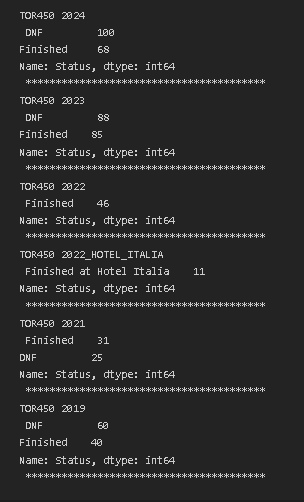

####  TOR450_dem + ITRA_2019 = DNF RATE FULL PICTURE
FIrst I need to make sure ITRA (2019) data has the same columns as TOR450_dem (2021 - 2024). 
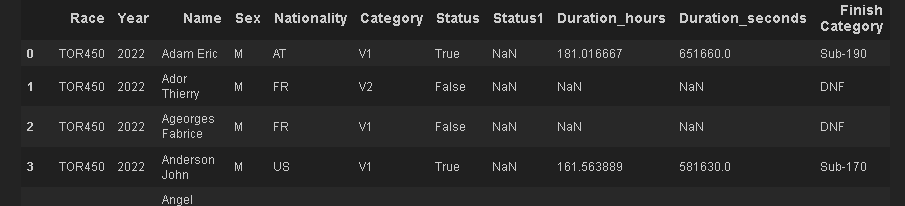


#### Prepping ITRA 2019 for merge 
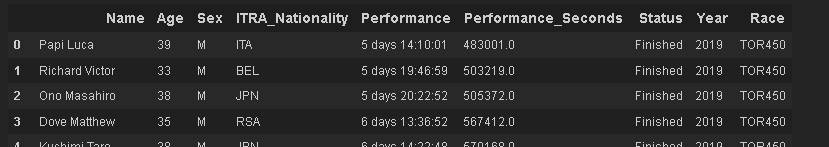

Some column names are not the same so this will be prepped.


### ITRA nationalities
ITRA Nationalities take different code to the Nationality to the TORX Live - also they take residency rather than nationality 

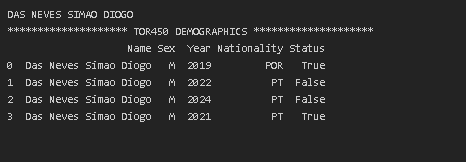

In [137]:
prep_TOR450_dem = TOR450_dem[[ 'Race', 'Year', 'Name', 'Sex', 'Nationality', 'Category',
       'Status', 'Status1', 'Duration_hours', 'Duration_seconds',
       'Finish Category']]
prep_TOR450_dem.groupby(['Category'])['Category'].count()

Category
SEN     73
V1     222
V2     215
V3      46
V4       1
Name: Category, dtype: int64

In [138]:
prep_TOR450_dem.groupby(['Category'])['Category'].count()

Category
SEN     73
V1     222
V2     215
V3      46
V4       1
Name: Category, dtype: int64

### Preparin 2019 data to merge with TORX LIVE data summary


In [139]:
TOR450_itra = pd.read_excel(f'{race} Data/5. Clean Data for Data Visualisation/{race}_itra_including_DNF.xlsx',
                                     dtype={'Year': 'string'})

TOR450_itra_2019 = TOR450_itra[TOR450_itra['Year'] == '2019'].reset_index(drop = True)
TOR450_itra_2019

Name Age Sex ITRA_Nationality      Performance  \
0           Papi Luca  39   M              ITA  5 days 14:10:01   
1      Richard Victor  33   M              BEL  5 days 19:46:59   
2        Ono Masahiro  38   M              JPN  5 days 20:22:52   
3        Dove Matthew  35   M              RSA  6 days 13:36:52   
4        Kuchimi Taro  38   M              JPN  6 days 14:22:48   
..                ...  ..  ..              ...              ...   
95    Thiebat Orlando  65   M              ITA              NaT   
96       Thierry Ador  48   M              FRA              NaT   
97   Tribolo Philippe  44   M              FRA              NaT   
98   Viglino Frederic  48   M              FRA              NaT   
99  Zapata Munoz Juan  46   M              ESP              NaT   

    Performance_Seconds    Status  Year    Race  
0              483001.0  Finished  2019  TOR450  
1              503219.0  Finished  2019  TOR450  
2              505372.0  Finished  2019  TOR450  
3              567412.0  Finished  2019  TOR450  
4              570168.0  Finished  2019  TOR450  
..                  ...       ...   ...     ...  
95                  NaN       DNF  2019  TOR450  
96                  NaN       DNF  2019  TOR450  
97                  NaN       DNF  2019  TOR450  
98                  NaN       DNF  2019  TOR450  
99                  NaN       DNF  2019  TOR450  

[100 rows x 9 columns]

In [140]:
TOR450_itra_2019.groupby('Status')['Status'].count()

Status
DNF         60
Finished    40
Name: Status, dtype: int64

In [141]:

TOR450_itra_2019 = TOR450_itra_2019.rename(columns={"Performance": "Duration",
                                                    "Performance_Seconds": "Duration_seconds",
                                                    "ITRA_Nationality": "Nationality",
                                                   }) 

TOR450_itra_2019['Status1'] = TOR450_itra_2019['Status'].copy() 
TOR450_itra_2019.loc[TOR450_itra_2019['Status1'] == 'Finished', 'Status'] = 'True'
TOR450_itra_2019.loc[TOR450_itra_2019['Status1'] == 'DNF', 'Status'] = 'False'

# Convert to timedelta and get total hours (handling NaT)
TOR450_itra_2019['Duration_hours'] = pd.to_timedelta(
    TOR450_itra_2019['Duration'], errors='coerce'
).dt.total_seconds() / 3600  # Convert seconds to hours



TOR450_itra_2019['Finish Category'] = TOR450_itra_2019['Duration_hours'].apply(categorize_duration)


# Set 'Finish Category' as a categorical column with the defined order
TOR450_itra_2019['Finish Category'] = pd.Categorical(
    TOR450_itra_2019['Finish Category'],
    categories = finish_category_order,
    ordered = True
)

def categorize_age(age):
    if pd.isna(age):
        return pd.nan  # Handle NaT values
    elif age < 40: # under40
        return 'SEN'
    elif age < 50: #40-49
        return f'V1'
    elif age < 60: #50-59
        return f'V2'
    elif age < 70: #60-69
        return f'V3'
    else:
        return 'V4' # Over 70

    
TOR450_itra_2019['Category'] = TOR450_itra_2019['Age'].apply(categorize_age)

TOR450_itra_2019 = TOR450_itra_2019[[
    'Race','Year',  'Name',  'Sex', 'Nationality','Category',
       'Status', 'Status1',  'Duration_hours', 'Duration_seconds', 'Finish Category']]


In [142]:
print(len(prep_TOR450_dem.columns))
print(len(TOR450_itra_2019.columns))

11
11


In [143]:
# Concatenate along columns (axis=1)
TOR450_2019_2024 = pd.concat([TOR450_itra_2019, prep_TOR450_dem])

### ITRA nationalities
ITRA Nationalities take different code to the Nationality to the TORX Live - also they take residency rather than nationality 

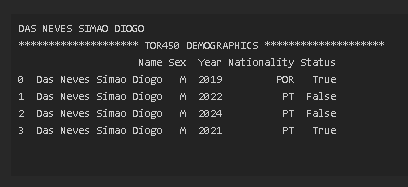



In [144]:

# TOR450_2019_2024.loc[TOR450_2019_2024['Year'] == '2019', 'Nationality'] = np.nan
# TOR450_2019_2024['Nationality'] = TOR450_2019_2024['Nationality'].bfill()

In [145]:
# Set 'Finish Category' as a categorical column with the defined order
TOR450_2019_2024['Year'] = pd.Categorical(
    TOR450_2019_2024['Year'],
    categories = ['2019',  '2021', '2022', '2023', '2024', ],
    ordered = True
)


TOR450_2019_2024['Year'].unique()

['2019', '2022', '2024', '2023', '2021']
Categories (5, object): ['2019' < '2021' < '2022' < '2023' < '2024']

### Cleaning Names to make sure they match

In [146]:
name_mapping = {
    'Kuehn Philip': 'Kuhn Philip',
    'Gu Haiyan': 'Gu Hai Yan',
    'Sylvain Oeillet': 'Oeillet Sylvain',
     'Gonzalez Fernando': 'Gonzalez Rodriguez Fernando',
     'Yann Richard': 'Richard Yann',
    'Stephane Poulin': 'Poulin Stephane',
    
    'Claudiu Beletoiu':'Beletoiu Claudiu Ionel',
#     'Beletoiu Claudiu': 'Claudiu Beletoiu',
    'Mrtinez Jose': 'Martinez Jose',
    'Marzotto Ita Emanuela': 'Marzotto Ita Emanuela Anna',
    'Jose Urizar': 'Urizar Jose Lorenzo',
    'Petersen Heine': 'Petersen Heine Hove',
    'Madeira Luis': 'Picanco Madeira Luis Manuel',
    'Devine Keri': 'Devine Keri Ann',
    'Rastelli Daniel': 'Rastelli Daniel Fernando',
    'Compagnoni Gustavo': 'Compagnoni Gustavo Fernando',
    'De Lahitte Hernan': 'De Lahitte Hernan Roberto',
    'Hayes Steve': 'Hayes Steven',
    'Eric Jeanclaude': 'Jeanclaude Eric',
    'Jan Kriska': 'Kriska Jan',
    'Gong Mingcheng': 'Gong Ming Cheng (Tom)',
    'Domnin Erard': 'Erard Domnin',
    'Roig Josep': 'Roig Carcel Josep',
    'Geist Bill': 'Geist William',
    'Buitrago Javier': 'Buitrago Rodriguez Oscar Javier',
    'Ramos Mario': 'Ramos Quispe Mario Wilbert',
    'Gosney Melissa': 'Gosney Missy',
    'Ong Soonseng': 'Ong Soon Seng (Steven)',
    'Timo Vogel': 'Vogel Timo',
    'Perrone Carmelo': 'Perrone Fodaro Carmelo',
    'Madrigal Ligia': 'Madrigal Moya Ligia',
    'Frederic Gil': 'Gil Frederic',
    'Daniel Gloria': 'Gloria Daniel',
    'Herrero Albert': 'Herrero Casas Albert',
    'De Santiago Luis': 'De Santiago Iglesias Luis Angel',
    'Pierre Selva': 'Selva Pierre',
    'Antonin Claudio': 'Antonin Claudio Roger',
    'Iancu David': 'Iancu David Traian',
    'Javega David': 'Javega Meneses David',
    'Matthieu Moreau': 'Moreau Matthieu',
    'Neale Matt': 'Neale Matthew',
    'Philippe Perez': 'Perez Philippe',
    'Vincent Wendling': 'Wendling Vincent',
    'Berglund Marcus': 'Berglund Marcus K.',
    'Erwee Tiaan': 'Erwee Christiaan Dirk (Tiaan)',
    'Francisco Flavio': 'Sousa Francisco Flavio Jose',
    'Puit Javier': 'Puit Juste Javier',
    'Rizzo Diego': 'Rizzo Diego Francesco',
    'Sibona Guendalina': 'Sibona Guendalina Enrica',
    'Simao Diogo': 'Das Neves Simao Diogo',
    'Galve Javier': 'Galve Sainz De Varanda Javier',
    'Santos Nuno': 'Charrua Santos Nuno Miguel',
    'Wang Xiaolin': 'Wang Xiao Lin',
    'Gabioud Jules Henry': 'Gabioud Jules Henri',
    'Guy Berton': 'Berton Guy',
    'Jacek Fugiel': 'Fugiel Jacek',
    'Xiong Pengpeng': 'Xiong Peng Peng',
    'Daoting Zhou' :'Zhou Dao Ting',
    'Zhou Daoting': 'Zhou Dao Ting',
    'Dolah Mohd Puzi': 'Dolah Dolah Mohd. Puzi',
    'Ramos Mario Wilbert': 'Ramos Quispe Mario Wilbert',
    'Samaniego Jose': 'Samaniego Montero Jose',
    'Serrazina Jorge': 'Marquez Serrazina Jorge Manuel',
    'Thierry Ador': 'Ador Thierry',
    'Luca Franceschini': 'Franceschini Luca',
    'Saito Toshiyuki': 'Saitou Toshiyuki'
}

for df in [TOR450, TOR450_dem, TOR450_2019_2024, TORX_itra_no_DNF]:
    df['Name'].replace(name_mapping, inplace=True)
    
DUV_330.loc[DUV_330['Name'] == 'Gonzalez Fernando', 'Name'] = 'Gonzalez Rodriguez Fernando'
DUV_330.loc[DUV_330['Name'] == 'Yann Richard', 'Name'] = 'Richard Yann'

TOR450_2019_2024.loc[TOR450_2019_2024['Name'] == 'Beletoiu Claudiu', 'Name'] = 'Beletoiu Claudiu Ionel'




C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\893854965.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'].replace(name_mapping, inplace=True)


### Finding all TOR450 finishers' TOR330 times
This involves filtering DUV_330 by the names in the DUV_450

In [147]:
DUV_450.groupby('Year')['Year'].count()

Year
2019    40
2021    31
2022    46
2023    85
2024    68
Name: Year, dtype: int64

In [148]:
DUV_330.groupby('Year')['Year'].count()

Year
2010    179
2011    300
2012     73
2013    383
2014    444
2015      6
2016    446
2017    461
2018    534
2019    565
2021    431
2022    408
2023    621
2024    533
Name: Year, dtype: int64

In [149]:
DUV_finishers_450_list = list(DUV_450['Name'].unique())
print('The number of TOR450 unique finishers from 2021-2024: ',len(DUV_finishers_450_list))

DUV_finishers_330_list =  list(DUV_330['Name'].unique())
print('The number of TOR330 unique finishers from 2010-2024: ',len(DUV_finishers_330_list))

The number of TOR450 unique finishers from 2021-2024:  215
The number of TOR330 unique finishers from 2010-2024:  4179


In [150]:
n = 0
DUV_450_finisher_TOR330_time = []
names_not_match = []
for finisher in DUV_finishers_450_list:
    if finisher in DUV_finishers_330_list:
#         print(finisher)
        bib_df = DUV_330[DUV_330['Name'] == finisher]

        DUV_450_finisher_TOR330_time.append(bib_df)
                                
    else:
        n = n+1
        print(n, finisher)
        names_not_match.append(finisher)


1 Richard Victor
2 Fink Katja
3 Hjelmer Magnus
4 Das Neves Simao Diogo


#### 4 Finishers of TOR450 thatI struggled to find any TOR330 Finishers' times 

1 Richard Victor

2 Fink Katja

3 Hjelmer Magnus

4 Das Neves Simao Diogo


In [151]:
DUV_450_finisher_TOR330_time = pd.concat(DUV_450_finisher_TOR330_time)

In [152]:
for name in names_not_match:
    name1 = name.split(' ')[0]
    name2 = name.split(' ')[1]
    print('*'*55)
    print(name.upper())
    print('*'*23, 'DUV 330','*'*23)
    print(DUV_330[['Name', 'Sex', 'DUV_ationality', 'Performance']][DUV_330['Name'].str.contains(name1)])
    print('-'*55)
    print(DUV_330[['Name', 'Sex', 'DUV_ationality', 'Performance']][DUV_330['Name'].str.contains(name2)])
    print('*'*23, 'DUV 450','*'*23)
    print(DUV_450[['Name', 'Sex', 'DUV_ationality', 'Performance']][DUV_450['Name'].str.contains(name)])
    print('\n' *5)
    



*******************************************************
RICHARD VICTOR
*********************** DUV 330 ***********************
                    Name Sex DUV_ationality     Performance
682      Turgeon Richard   M            CAN 4 days 10:56:10
1761       Heath Richard   M            GBR 5 days 03:24:26
1902       Newey Richard   M            GBR 5 days 04:31:43
2191        Richard Yann   M            FRA 5 days 06:48:36
2680  Buckingham Richard   M            AUS 5 days 10:36:11
2969     Cupples Richard   M            GBR 5 days 13:22:36
3016       Newey Richard   M            GBR 5 days 13:47:11
3978       Abell Richard   M            GBR 5 days 23:41:48
5037   Leneindre Richard   M            FRA 6 days 03:58:01
-------------------------------------------------------
                        Name Sex DUV_ationality     Performance
1318           Gravot Victor   M            FRA 4 days 22:49:19
2342      Ballesteros Victor   M            USA 5 days 07:56:30
2441       Hugot Jean Vic

In [153]:
print(DUV_330[DUV_330['Name'].isin(list(DUV_450_finisher_TOR330_time['Name'].unique()))].shape)

(343, 9)


### Paul Tierney

Ran TOR450 3 times, but DNFed once, which means his TOR330 times have been already found in the DUV_330 data.

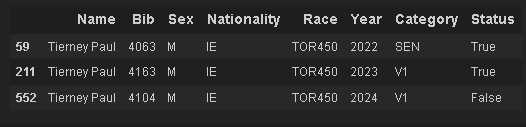

In [154]:
TOR450_2019_2024[TOR450_2019_2024['Name'] == 'Tierney Paul']

Race  Year          Name Sex Nationality Category Status Status1  \
134  TOR450  2022  Tierney Paul   M          IE      SEN   True     NaN   
315  TOR450  2024  Tierney Paul   M          IE       V1  False     NaN   
488  TOR450  2023  Tierney Paul   M          IE       V1   True     NaN   

     Duration_hours  Duration_seconds Finish Category  
134      136.388889          491000.0         Sub-140  
315             NaN               NaN             DNF  
488      135.366667          487320.0         Sub-140

In [155]:
TOR450_dem_unique_names_of_everyone_who_ever_finished_TOR450_even_once_list = list(TOR450_2019_2024['Name'][TOR450_2019_2024['Status'] == 'True'].unique())
print('Number of uniquw names in TOR450_dem that finished TOR450 at least once: ',
      len(TOR450_dem_unique_names_of_everyone_who_ever_finished_TOR450_even_once_list))

Number of uniquw names in TOR450_dem that finished TOR450 at least once:  215


In [156]:
TOR450_dem_unique_names_of_never_finished_TOR450_list = list(TOR450_2019_2024['Name'][~(TOR450_2019_2024['Name'].isin(TOR450_dem_unique_names_of_everyone_who_ever_finished_TOR450_even_once_list))].unique())
print('Number of uniquw names in TOR450_dem that never finished TOR450: ', len(TOR450_dem_unique_names_of_never_finished_TOR450_list))

Number of uniquw names in TOR450_dem that never finished TOR450:  237


### Finding TOR330 times for everyone who NEVER finished TOR450 in 2021 - 2024

In [157]:
# Whose names dont Match? 
names_dont_match = []
n = 0
for TOR450_DNF in TOR450_dem_unique_names_of_never_finished_TOR450_list:
    if TOR450_DNF in DUV_finishers_330_list:
        pass
    else:
        n = n + 1
        print(n , TOR450_DNF)
        
        names_dont_match.append(TOR450_DNF)
 

1 Alfier Alessio
2 Caparicas Paulo
3 Chamoux Jerome
4 Degli Innocenti Stefano
5 Davico Claudio
6 Martinez Jose
7 Solari Paolo
8 Jacobs Erik
9 Obreza Marko
10 Van Gheluwe Yannick
11 Chiri Duilio Fedele


### 11 Names in DNFs TOR450_dem dont match the names of the DUV_330

In [158]:
n = 0
for name in names_dont_match:
    
    bib_df = DUV_330[DUV_330['Name'].str.contains(f'{name}')]
    if not bib_df.empty:
        
        n = n+1
        print(n, name)
        print(bib_df['Name'].unique())
        print('*'*30)
    else:
        name_split = name.split(' ')[0]
        name_split_1 = name.split(' ')[1]
        bib_df = DUV_330[DUV_330['Name'].str.contains(f'{name_split}')]
        if not bib_df.empty:
            
            n = n+1
            print(n, name)
            print(bib_df['Name'].unique())
            print('*'*30)
        else: 
            bib_df = DUV_330[DUV_330['Name'].str.contains(f'{name_split_1}')]
            n = n+1
            print(n, name)
            print(bib_df['Name'].unique())
            print('*'*30)

1 Alfier Alessio
['Alfieri Nicola']
******************************
2 Caparicas Paulo
['Durao Paulo' 'Reis Paulo' 'Rodrigues Paulo Jorge'
 'Dos Santos Queiros Joao Paulo']
******************************
3 Chamoux Jerome
['Lucas Jerome' 'Pelle Jerome' 'Martimort Jerome' 'Sartre Jerome'
 'Marin Jerome' 'Perrier Jerome' 'Parent Jerome' 'Soulier Jerome'
 'Clerc Jerome' 'Thibaut Jerome' 'Berode Jerome' 'Gondolff Jerome']
******************************
4 Degli Innocenti Stefano
['Degli Agosti Andrea']
******************************
5 Davico Claudio
['Cheraz Claudio' 'Gadler Claudio' 'Rossi Claudio' 'Roullet Claudio'
 'Lombardi Claudio' 'Herin Claudio' 'Cernuschi Claudio'
 'Antonin Claudio Roger' 'Bocchino Claudio' 'Bastrentaz Claudio'
 'Curtaz Claudio' 'Ferrero Claudio' 'Blotto Claudio' 'Zandonai Claudio'
 'Tucci Claudio' 'Distort Claudio']
******************************
6 Martinez Jose
['Larrotcha Martinez Carrasco Juan Jose' 'Martinez Urruzola Nerea'
 'Martinez Fernandez Jose Luis' 'Martine

### Which Martinez Jose?

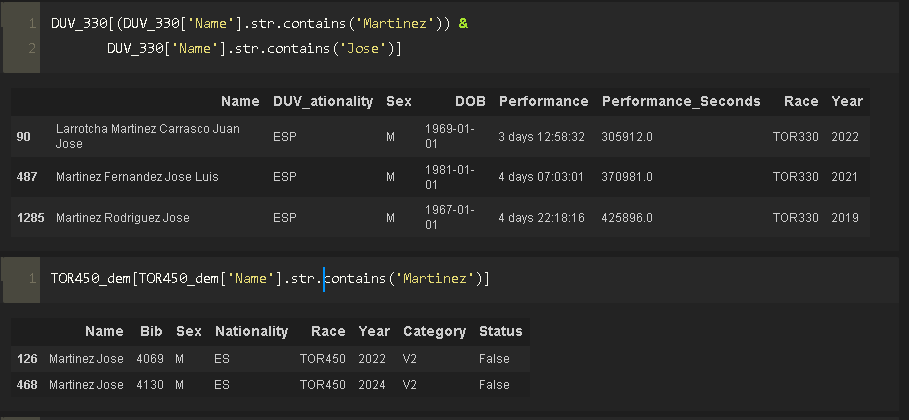

V2 is 50-59 years old, so it is definetely not the 1981 born...

In [159]:
DUV_330[(DUV_330['Name'].str.contains('Martinez')) &
       DUV_330['Name'].str.contains('Jose')]

Name DUV_ationality Sex        DOB  \
90    Larrotcha Martinez Carrasco Juan Jose            ESP   M 1969-01-01   
487            Martinez Fernandez Jose Luis            ESP   M 1981-01-01   
1285                Martinez Rodriguez Jose            ESP   M 1967-01-01   

         Performance  Performance_Seconds    Race  Year  Performance_hours  
90   3 days 12:58:32             305912.0  TOR330  2022          84.975556  
487  4 days 07:03:01             370981.0  TOR330  2021         103.050278  
1285 4 days 22:18:16             425896.0  TOR330  2019         118.304444

In [160]:
TOR450_dem[TOR450_dem['Name'].str.contains('Martinez')]

PK    Race  Year   Bib           Name Sex Nationality  \
91   TOR450_2022_4069  TOR450  2022  4069  Martinez Jose   M          ES   
267  TOR450_2024_4130  TOR450  2024  4130  Martinez Jose   M          ES   

    Category Status Status1  Duration_hours  Duration_seconds Finish Category  \
91        V2  False     NaN             NaN               NaN             DNF   
267       V2  False     NaN             NaN               NaN             DNF   

    Retired Retired_Stage Diversion Missed Last Checkpoint  \
91      NaN           NaN       NaN                  False   
267     NaN           NaN       NaN                  False   

     Missed Diff_seconds  
91                   NaN  
267                  NaN

In [161]:
for df in [TOR450, TOR450_dem, TOR450_2019_2024, TORX_itra_no_DNF]:
    df['Name'] = df['Name'].str.replace('Martinez Jose', 'Martinez Rodriguez Jose')

C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\239322603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Name'] = df['Name'].str.replace('Martinez Jose', 'Martinez Rodriguez Jose')


In [162]:
TOR450_2019_2024_unique_names_of_never_finished_TOR450_list = list(TOR450_2019_2024['Name'][~(TOR450_2019_2024['Name'].isin(TOR450_dem_unique_names_of_everyone_who_ever_finished_TOR450_even_once_list))].unique())
print('Number of uniquw names in TOR450_dem that never finished TOR450: ', len(TOR450_2019_2024_unique_names_of_never_finished_TOR450_list))

# Whose names dont Match? 
names_dont_match = []
n = 0
for TOR450_DNF in TOR450_2019_2024_unique_names_of_never_finished_TOR450_list:
    if TOR450_DNF in DUV_finishers_330_list:
        pass
    else:
        n = n + 1
        print(n , TOR450_DNF)
        
        names_dont_match.append(TOR450_DNF)
 

Number of uniquw names in TOR450_dem that never finished TOR450:  237
1 Alfier Alessio
2 Caparicas Paulo
3 Chamoux Jerome
4 Degli Innocenti Stefano
5 Davico Claudio
6 Solari Paolo
7 Jacobs Erik
8 Obreza Marko
9 Van Gheluwe Yannick
10 Chiri Duilio Fedele


In [163]:

for name in names_dont_match:
    name1 = name.split(' ')[0]
    name2 = name.split(' ')[1]

    print('*'*55)
    print(name.upper())
    print('*'*23, 'TOR450 DEMOGRAPHICS','*'*23)
    print(TOR450_2019_2024[['Name', 'Year','Sex', 'Nationality', 'Status','Duration_hours']][TOR450_2019_2024['Name'].str.contains(name)].reset_index(drop = True))
    
    print('*'*23, 'DUV 330','*'*23)
    print('Searching for names with: ',name1.upper())
    print(DUV_330[['Name', 'Year','Sex', 'DUV_ationality', 'Performance']][DUV_330['Name'].str.contains(name1)].reset_index(drop = True))
    
    print('-'*55)
    print('Searching for names with: ',name2.upper())
    print(DUV_330[['Name', 'Year','Sex', 'DUV_ationality', 'Performance']][DUV_330['Name'].str.contains(name2)].reset_index(drop = True))

    try:
        print('-'*55)
        name3 = name.split(' ')[2]
        print('Searching for names with: ',name3.upper())
        print(DUV_330[['Name', 'Year','Sex', 'DUV_ationality', 'Performance']][DUV_330['Name'].str.contains(name3)].reset_index(drop = True))
        print('-'*55)
        print('Searching for names with: ',name1.upper(), name3.upper())
        print(DUV_330[['Name', 'Year','Sex', 'DUV_ationality', 'Performance']][(DUV_330['Name'].str.contains(name1)) &
                                                                              (DUV_330['Name'].str.contains(name3))].reset_index(drop = True))

    except:
        pass
    
    print('*'*23, 'DUV 450','*'*23)
    print(DUV_450[['Name', 'Year','Sex', 'DUV_ationality', 'Performance']][DUV_450['Name'].str.contains(name)].reset_index(drop = True))

    print('\n' *5)
    

*******************************************************
ALFIER ALESSIO
*********************** TOR450 DEMOGRAPHICS ***********************
             Name  Year Sex Nationality Status  Duration_hours
0  Alfier Alessio  2019   M         ITA  False             NaN
*********************** DUV 330 ***********************
Searching for names with:  ALFIER
             Name  Year Sex DUV_ationality     Performance
0  Alfieri Nicola  2010   M            ITA 5 days 07:31:47
-------------------------------------------------------
Searching for names with:  ALESSIO
                                Name  Year Sex DUV_ationality     Performance
0                      Vorti Alessio  2021   M            ITA 4 days 01:43:18
1                      Breda Alessio  2018   M            ITA 4 days 08:52:28
2  D Alessio Davidson Joseph Anthony  2024   M            USA 5 days 00:06:59
3  D Alessio Davidson Joseph Anthony  2021   M            USA 5 days 02:45:26
4  D Alessio Davidson Joseph Anthony  2018   M

           Name  Year Sex Nationality Status  Duration_hours
0  Solari Paolo  2022   M          CL  False             NaN
*********************** DUV 330 ***********************
Searching for names with:  SOLARI
Empty DataFrame
Columns: [Name, Year, Sex, DUV_ationality, Performance]
Index: []
-------------------------------------------------------
Searching for names with:  PAOLO
                 Name  Year Sex DUV_ationality     Performance
0   Pignacchino Paolo  2019   M            ITA 3 days 14:00:16
1         Piano Paolo  2017   M            ITA 3 days 18:56:06
2         Rossi Paolo  2016   M            ITA 3 days 22:16:27
3        Pajaro Paolo  2013   M            ITA 3 days 22:46:54
4         Piano Paolo  2016   M            ITA 4 days 03:24:00
..                ...   ...  ..            ...             ...
72      Benetti Paolo  2023   M            ITA 6 days 03:27:25
73       Riboli Paolo  2018   M            ITA 6 days 03:56:31
74    Vagaggini Paolo  2014   M            ITA 6 d

#### 11 TOR450 DNF

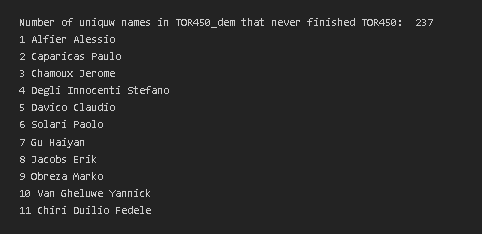

These are people whose DNFed TOR450 having never finished TOR450 and whose TOR330 I can not find!

In [164]:
n = 0

DUV_330_never_finished_450 = []

for TOR450_DNF in TOR450_2019_2024_unique_names_of_never_finished_TOR450_list:
    if TOR450_DNF in DUV_finishers_330_list:
        bib_df = DUV_330[DUV_330['Name'] == TOR450_DNF]
        if not bib_df.empty:
            DUV_330_never_finished_450.append(bib_df)
    else:
        n = n + 1
        print(n , TOR450_DNF)
        
        

1 Alfier Alessio
2 Caparicas Paulo
3 Chamoux Jerome
4 Degli Innocenti Stefano
5 Davico Claudio
6 Solari Paolo
7 Jacobs Erik
8 Obreza Marko
9 Van Gheluwe Yannick
10 Chiri Duilio Fedele


In [165]:
DUV_330_never_finished_450  = pd.concat(DUV_330_never_finished_450 )

DUV_330_never_finished_450.reset_index(drop = True, inplace = True)

### Adding TOR450 finishers' time to all those who never finished DNFs. 

In [166]:
# Everyone who finished TOR450 at least once!
DUV_450_finisher_TOR330_time.reset_index(drop = True, inplace = True)


In [167]:
# Concatenate along columns (axis=1)
DUV330_all_who_started_TOR450 = pd.concat([DUV_450_finisher_TOR330_time, DUV_330_never_finished_450])
DUV330_all_who_started_TOR450.reset_index(drop = True , inplace = True)

In [168]:
DUV330_all_who_started_TOR450#.sort_values(by = 'Performance', ascending = True )

Name DUV_ationality Sex        DOB  \
0                Raichon Sebastien            FRA   M 1972-01-01   
1    Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01   
2    Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01   
3    Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01   
4                     Kienzl Peter            ITA   M 1975-01-01   
..                             ...            ...  ..        ...   
696                 Holst Benjamin            DEN   M 1970-01-01   
697                 Holst Benjamin            DEN   M 1970-01-01   
698                     Kriska Jan            USA   M 1967-01-01   
699            Urizar Jose Lorenzo            SUI   M 1966-01-01   
700                 L Heureux Yvan            CAN   M 1974-01-01   

        Performance  Performance_Seconds    Race  Year  Performance_hours  
0   3 days 14:25:33             311133.0  TOR330  2019          86.425833  
1   3 days 08:18:24             289104.0  TOR330  2019          80.306667  
2   4 days 07:23:07             372187.0  TOR330  2018         103.385278  
3   5 days 06:13:32             454412.0  TOR330  2014         126.225556  
4   3 days 05:31:11             279071.0  TOR330  2018          77.519722  
..              ...                  ...     ...   ...                ...  
696 5 days 09:47:29             467249.0  TOR330  2019         129.791389  
697 5 days 17:07:53             493673.0  TOR330  2016         137.131389  
698 4 days 16:59:19             406759.0  TOR330  2014         112.988611  
699 5 days 01:38:42             437922.0  TOR330  2019         121.645000  
700 5 days 08:40:11             463211.0  TOR330  2019         128.669722  

[701 rows x 9 columns]

### Name per Status 

In [169]:
# creating a newn columns for the df
name_count_headers = ["Name","# TOR450 Finishes","# TOR450 DNFs", 'Total # TOR450 attempts','# TOR330 Finishes']

#creating a dataframe with columns
count_TOR450_TOR330_per_runner = pd.DataFrame(columns = name_count_headers)

for name in list(TOR450_2019_2024['Name'].unique()):
    bib_df = TOR450_2019_2024[TOR450_2019_2024['Name'] == name]
    finish = 0
    dnf = 0
    for year in bib_df['Year'].unique():
        bib_year_df = bib_df[bib_df['Year'] == year]
        status = bib_year_df['Status'].values[0]
        if status  == 'True':
            finish = finish + 1
        elif status  == 'False':
            dnf = dnf + 1
    try:
        tor_finishing_count = DUV330_all_who_started_TOR450['Name'][DUV330_all_who_started_TOR450['Name'] == name].count()
    except:
        print('issues')
    print(name, finish, dnf, tor_finishing_count )
    total_TOR450_attempts =  finish + dnf
    name_count = [name, finish, dnf, total_TOR450_attempts, tor_finishing_count ]

    count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)

count_TOR450_TOR330_per_runner
    

Papi Luca 3 2 1
Richard Victor 1 0 0
Ono Masahiro 1 0 5
Dove Matthew 1 0 1
Kuchimi Taro 3 0 1
Guerini Luca 1 1 6
Anderson John 2 2 2
Sciebura Pawel 2 0 1
Nadler Kurt 1 0 1
Geoffroy Julien 1 0 1
Zanarella Cristiano 1 0 1
Diemoz Paolo 1 0 2
Girgin Serkan 1 0 2
Girgin Sertan 1 0 3
Gonzalez Rodriguez Fernando 2 0 2
Firth Darren 1 0 1
Beretta Marco 2 0 3
Saviozzi Francesco 1 0 2


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Takeda Kentaro 1 3 2
Calvo Requena Albert 1 1 2
Franceschini Luca 1 0 2
Das Neves Simao Diogo 2 2 0
De Prati Giovanni 1 0 2
Traina Christophe 2 2 1
Baars Anouk 1 0 1
Javega Meneses David 2 0 1
Puit Juste Javier 2 1 1
Fonio Stefano 1 0 1
Saitou Toshiyuki 1 0 1
Cretin Jean Noel 1 0 1
Souchon Frederic 1 1 1
Arnus Matej 1 0 3
Ponce Sebastien 4 1 2
Girard Norbert 1 1 1
Perez Palencia Santiago 1 0 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Plavan Marina 4 1 4
Isernia Ruggiero 2 1 7
Gallizia Michele 1 1 3
Magnin Luciano 1 0 1
Rubaldo Paolo 1 0 3
Alfier Alessio 0 1 0
Alleguede Stephane 0 1 1
Boncompagni Roberto 0 1 2
Bourguignon Laurent 0 1 3
Buzzolan Corrado 0 2 1
Caparicas Paulo 0 1 0
Chamoux Jerome 0 1 0
De Mottoni Tommaso 0 1 1
Degli Innocenti Stefano 0 1 0
Dolah Dolah Mohd. Puzi 0 1 1
Dufour Olivier 0 2 3
Dutz Olivier 0 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Feinhaus Dima 0 1 3
Fugiel Jacek 0 2 2
Gaggero Ugo 0 1 1
Gasparini Thierry 0 2 1
Genois Alexandre 0 1 1
Grant Bruce 0 1 3
Jacqmin Nathanael 0 1 1
Jeanclaude Eric 0 2 1
Joubert Franck 0 1 1
Kanobelj Marco 0 1 3
Kissiyar Ouns 0 2 2
La Martina Dario 0 2 1
Landresse Christian 0 2 3
Longhini Piero 0 1 1
Luet Dominique 0 1 1
Macchiavello Giorgio 1 1 5
Madrigal Moya Ligia 0 2 2
Manolino Davide 0 2 2
Marchetti Franco 0 1 1
Marin Janne 0 1 2
Marmonti Osvaldo 0 1 3
Marzotto Ita Emanuela Anna 0 2 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Mayen Jean Sebastien 0 1 2
Menni Fabio 0 1 3
Minoggio Sergio 1 2 2
Moissinac Patrick 0 1 1
Morasso Umberto 0 1 5
Moro Franco 0 4 2
Oeillet Sylvain 2 3 2
Palazzi Gaetano 0 1 4
Papa Fabrizio 0 1 1
Paschetto Renzo 0 2 3
Petersen Heine Hove 0 2 2
Piazzo Mario 0 2 1
Pica Massimo 0 1 2
Prossen Francesco 0 1 3
Ramos Quispe Mario Wilbert 0 2 6


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Rinaldo Alfio 0 5 3
Romboletti Oscar 0 2 1
Samaniego Montero Jose 0 1 3
Sanguineti Charlie 0 3 1
Marquez Serrazina Jorge Manuel 0 1 1
Szymik Marcin 0 2 3
Thiebat Orlando 0 1 3
Ador Thierry 1 3 2
Tribolo Philippe 1 2 2
Viglino Frederic 0 1 1
Zapata Munoz Juan 0 1 1
Adam Eric 1 0 1
Ageorges Fabrice 0 1 1
Angel Andrade Julio Cesar 0 4 4
Anthonioz Pierre 1 0 2
Arbel Yannick 1 0 1
Arlot Christophe 0 1 1
Barmasse Piero 2 0 3
Bastrentaz Claudio 0 2 1
Bayios Ioannis 0 1 1
Beletoiu Claudiu Ionel 2 0 1
Berglund Marcus K. 1 1 3
Bero Stephan 2 1 1
Bonandrini Paolo 1 0 3
Bourdais Olivier 1 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Bracotto Giovanni Giuseppe 0 2 6
Bremmers Paul 0 1 1
Brussolo Simone 0 1 1
Buitrago Rodriguez Oscar Javier 0 3 1
Callisardi Giancarlo 2 1 1
Candido Luca 0 1 2
Carminati Mirko 2 0 1
Carranza Miguel 0 2 1
Cattaneo Martino 0 2 1
Cestino Saez Enrique 0 2 1
Christin Benoit Julien 1 1 1
Cimarosti Gabriele 1 0 2
Cirla Marco 0 1 1
Criado Toca Pablo 0 1 6
Curtil Raphael 1 0 1
D Angeli Pietro 0 1 2
Davico Claudio 0 1 0
Defecinski Radoslaw 0 1 1
Devine Keri Ann 0 1 1
Erard Domnin 0 2 2
Dorne Franck 0 1 1
Ekse Kaisa 1 1 1
Erwee Christiaan Dirk (Tiaan) 3 0 3
Fabre Olivier 1 0 1
Fiori Giorgio 0 3 1
Fohrmeister Volker 3 1 1
Sousa Francisco Flavio Jose 1 1 1
Garcia Rodriguez Jorge Manuel 1 0 1
Geist William 0 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Gentilini Iader 0 1 1
Gilardoni Alessandro 1 1 4
Goeringer Patrick 1 0 1
Gong Ming Cheng (Tom) 0 1 1
Gosney Brett 0 1 1
Gosney Missy 0 1 1
Guasina Giorgio 2 1 2
Guery Benjamin 1 1 1
Guffon Alain 1 1 1
Guilera Sala Monica 0 1 1
Haebler Stefan 2 0 1
Hansel Sarah 2 1 1
Heideck Daniel 1 1 4
Hetmanski Adam 0 1 1
Heyer Patrick 1 0 1
Higueret Quentin 1 0 1
Higueret Stephane 1 1 1
Hilz Rainer 1 0 2
Humphrey Andy 0 1 1
Iancu David Traian 0 3 1
Iotti Sebastien 1 1 1
Jongens Willemijn 0 1 1
Jouneau Pierre Henri 1 1 10
Kollassa Marina 0 1 1
Lambin Claude 0 1 9


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Lauret Denis 1 1 1
Laving Jean Marc 1 0 1
Lesage Sebastien 1 0 2
Letourneau Benoit 0 1 1
Locatelli Michele Oriele 0 2 2
Picanco Madeira Luis Manuel 0 2 3
Mallol Luc 0 2 2
Manse Lilian 1 0 1
Marois Martine 0 3 2
Marquis Micha 0 1 1
Michaud Andre Paul 0 1 1
Mousseaux David 1 0 1
Martinez Rodriguez Jose 0 2 1
Negri Mattia 1 2 1
Nordfjell Maria 0 2 2
Noseda Vittorio 0 1 1
Noville Maurice 0 1 3
Ost Isabelle 1 0 1
Paladin Tiziano 0 2 2
Palma Raphael 2 0 1
Penneman Aurelien 1 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Pivert Jean Baptiste 0 1 1
Plantefeve Gaetan 0 1 1
Poskin Julien 1 0 1
Poulin Stephane 2 1 1
Poupinet Benoit 0 1 1
Raichon Sebastien 2 0 1
Rao Shashwat 2 1 1
Rizzo Diego Francesco 1 0 2
Roig Carcel Josep 0 1 1
Rosati Luciano 0 1 1
Rovelli Roberto 0 1 2
Rzeszotko Leszek 0 1 2
Rzeszotko Marzena 0 1 1
Saint Joly Chloe 1 0 1
Samain Anthony 0 2 2
Santiago Delgado Juan Carlos 0 1 2
Sciamanna Marco 0 3 2
Sibona Guendalina Enrica 1 0 2
Simard Arnaud 2 1 9
Solari Paolo 0 1 0
Souloumiac Arnaud 2 0 1
Spinks Nicky 1 0 2
Szramowiat Marek 0 2 1
Tierney Paul 2 1 3
Turgeon Richard 1 0 1
Van Der Hoeven Jan Jilles 0 3 3
Venneugues Alban 1 0 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Vorti Alessio 0 1 1
Vukotic Dejan 1 0 1
Warchol Alexandre 0 1 1
Adet Benoit 1 0 2
Agnoli Cristian 0 2 1
Alexandru Florin 0 1 1
Annovazzi Giancarlo 1 1 6
Antonin Claudio Roger 0 2 1
Argelich Torra Enrique 1 1 1
Baneras Batlle Sergi 2 0 1
Barbieri Ranieri Brook 1 1 1
Benso Alfredo 0 1 4
Beranger Sandrine 0 2 1
Berthon Mickael 1 0 1
Bianchini Flaviano 1 0 1
Bicelli Raphael 1 0 2
Bie Nicolas 1 1 1
Blanc Abele 0 1 1
Bokman Jakob 0 1 1
Bongioanni Fabrizio 1 0 2
Bortolotti Elisabetta 0 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Brambilla Luca 1 0 1
Bryant Shane 0 1 1
Buchowicz Krzysztof 1 0 1
Carrelli Thomas 1 0 1
Case Stephanie 1 1 3
Castellain Edouard 0 1 1
Cattelan Fabio 0 1 1
Champigny Julien 1 0 1
Ciapa Philippe 1 0 1
Clark Stephen 0 1 2
Colls Avila Oscar 0 1 1
Comero Roberto 1 0 2
Compagnoni Gustavo Fernando 0 2 2
Crussy Thierry 0 1 1
D Agostino Maurizio 0 2 1
Da Costa Veloso Alexandre 1 1 1
Danet Fabien 2 0 1
De Santiago Iglesias Luis Angel 0 1 1
Demeter Michal 0 1 1
Denis Bernard 0 1 1
Despretz Thomas 0 2 1
Dessambre Nicolas 1 0 1
Dietrich Christophe 1 0 2
Dimzas Evangelos 1 1 2
Distort Corrado 0 1 2
Dossena Paolo 0 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Douillet David 0 1 2
Duranti Luca 1 0 1
Durao Paulo 0 2 1
Fages Perrine 0 2 1
Felix Christophe 1 1 1
Fernandez Sylvain 0 1 1
Ferrario Andrea 0 1 1
Fink Katja 1 0 0
Flamia Stefano 0 1 1
Flavelle Erika 1 0 1
Foiadelli Elio 0 1 3
Forzani Adriano 0 1 1
Gil Frederic 0 1 2
Gaffuri Paolo 0 1 2
Galve Sainz De Varanda Javier 1 0 2
Giacchetta Stephane 1 0 1
Giovannini Giacomo 2 0 1
Gofflot Frederic 0 1 2
Gremeaux Denis 0 1 2
Grise Dominic 0 2 1
Gu Hai Yan 0 2 1
Gueraud Laurent 2 0 2
Hayes Steven 0 1 1
Haylett Philip 0 2 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Hernandez Ruiz Javier 0 2 1
Herrero Casas Albert 0 1 1
Herrmann Sebastien 0 1 1
Hewitt Michael 1 0 1
Hjelmstrom Peter 0 3 1
Hopwood Paul 0 2 1
Hunziker Ivan 0 1 1
Jacobs Erik 0 1 0
Janssen Rick 0 1 1
Jouffrey Olivier 1 0 1
Khalyapin Alexander 1 0 1
Kot Rafal 0 1 1
Krawczyk Tomasz 0 1 2
Krieger Thibaut 2 0 2
Kuhn Philip 1 0 1
Le Clainche Pierre 1 0 1
Lepoutre Antoine 0 1 1
Li Zhong Xue 0 2 1
Lovera Pierluigi 0 1 1
Lucas Frost Jonathan 0 1 1
Manfredi Negri Luca 0 1 2
Martin Bertrand 0 1 2
Martin Escribano Maximo 0 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Menin Jonathan 1 0 1
Milani Diego 2 0 3
Mora Federico 1 0 1
Moyroud Nicolas 2 0 3
Mullins Brian 0 1 2
Nolly Dino Franco 1 0 1
Novello Moreno 1 0 1
Obreza Marko 0 1 0
Pasta Dario 2 0 2
Pennazio Sebastien 2 0 4
Peresedov Vladimir 0 1 2
Pettinato Filippo 1 0 1
Selva Pierre 0 1 1
Podraza Tadeusz 0 1 2
Poirier Pierre 0 1 1
Prince Mike 0 1 1
Puiati Stefano 0 2 4
Quigley James 0 2 1
Quirk Thomas 1 0 1
Raso Andrea 2 0 2
Reid Melissa 0 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Renson Patrice 1 1 1
Riccardi Omar 0 1 2
Rigard Mickael 1 1 1
Roncato Alessandro 1 0 1
Roncoroni Luca 0 2 1
Rossi Carlo 1 0 1
Salt Zoe 0 1 1
Charrua Santos Nuno Miguel 1 1 1
Shao Sebastien 1 1 1
Soler Jean Pierre 1 0 1
Solivera Retchas Carles 2 0 3
Sproston Amy 0 2 1
Taguchi Minori 0 2 2
Taskin Sadik 0 2 1
Testa Antonio 0 2 2
Tognoni Patrich 1 1 2


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Trabucchi Pietro 0 2 3
Trygub Ievgeniia 0 1 1
Van Gheluwe Yannick 0 1 0
Vanmarcke Maxime 0 1 1
Vidal Salvi Jordi 1 0 1
Vuillen Loris 0 1 1
Wang Xiao Lin 2 0 3
Ward Peter 0 1 1
Yvin Erwan 0 1 1
Zhong Liu 0 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Alfero Flavien 1 0 1
Bolis Matteo 1 0 1
Bombenger Jean Francois 2 0 2
Bouquet Sophie 0 1 1
Braccialini Matteo 0 1 2
Buche Jean Pascal 1 1 1
Burgin Freddy 0 1 1
Castiglione Marco 1 0 1
Cattaneo Andrea 1 0 1
Charreau Benoist 1 0 1
Cheng Kuo Pin 0 1 1
Chiri Duilio Fedele 0 1 0
Conta Paolo 0 1 1
D Angelo Fabio 0 1 1
Da Forno Dario 0 1 2
De Biase Anna 0 1 1
De Lahitte Hernan Roberto 0 1 2
De Marco Enrico 1 0 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Delannoy Emmanuel 0 1 1
Deliau Bastien 1 0 1
Do Nascimento Franck 0 1 1
Duchier Claude 0 1 1
Dunkerbeck Thomas 1 0 1
Duperray Remy 1 0 1
Enrione Davide 1 0 1
Espie Laurent 0 1 1
Frontini Marco 1 0 1
Gabioud Candide 1 0 1
Gabioud Jules Henri 2 0 1
Gavazzeni Silvano 1 0 1
Gay Jean Philippe 1 0 1
Gent Anthony 1 0 1
Golay Geymond Florence 1 0 1
Grenno Raphael 0 1 1
Griseri Elio 0 1 3
Gross Cristiano 0 1 2
Gustafsson Johan 1 0 1
Berton Guy 1 0 1
Hacking Hugh 0 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Hjelmer Magnus 2 0 0
Incerti Thierry 0 1 1
Jurado Contreras Jonatan 1 0 1
Keith Eoin 1 0 1
Kienzl Peter 1 0 1
Kinsbergen Robin 0 1 3
Kucera Petr 1 0 2
Landry Danny 0 1 3
Lodi Severino 1 0 1
Luboz Dante 1 0 1
Maistri Francesco 0 1 1
Mangili Ivo Paolo 1 0 1
Michelotti Giuseppe 0 1 1
Minerva Vito 1 0 3
Olivieri Eric 0 1 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Olivson Oleksandr 1 1 3
Ong Soon Seng (Steven) 0 1 1
Ost Vincent 1 0 1
Perrone Fodaro Carmelo 0 1 1
Pirovano Andrea 1 0 1
Porati Fabrizio 1 0 1
Poriel Yannick 0 1 1
Pulizzi Antonio 0 1 2
Quinaou Yannick 1 0 1
Ralcheva Aneta 0 1 1
Rastelli Daniel Fernando 0 1 1
Richard Yann 1 0 1
Ruiz Velez Domingo 1 0 1
Schwalger Andreas 1 0 1
Sebanek Martin 1 0 1
Soderlund Emil 1 0 1
Soudy Jonathan 1 0 1
Szkaluba Barbara 0 1 1
Teuscher Christof 2 0 1
Vogel Timo 0 1 1
Turin Nicholas 1 0 1


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Underwood Tim 1 0 2
Van Woensel Thomas 1 0 1
Villa Simone 1 0 1
Wijaya Hendra 0 1 2
Xiong Peng Peng 1 0 1
Zhou Dao Ting 1 0 2
Alvarez Perez Miguel 1 0 2
Bedhet Guillaume 1 0 1
Belin Christophe 0 1 1
Ferrari Fabio 0 1 2
Gaetani Elio 0 1 1
Holst Benjamin 0 1 2
Kriska Jan 0 1 1
Urizar Jose Lorenzo 0 1 1
L Heureux Yvan 0 1 1
Moreau Matthieu 1 0 2
Neale Matthew 1 0 2
Perez Philippe 1 0 2


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index 

Raucy Emmanuel 1 0 3
Wendling Vincent 1 0 2


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)
C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\1947623673.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  count_TOR450_TOR330_per_runner = count_TOR450_TOR330_per_runner.append(pd.Series(name_count , index = name_count_headers), ignore_index = True)


Name # TOR450 Finishes # TOR450 DNFs Total # TOR450 attempts  \
0           Papi Luca                 3             2                       5   
1      Richard Victor                 1             0                       1   
2        Ono Masahiro                 1             0                       1   
3        Dove Matthew                 1             0                       1   
4        Kuchimi Taro                 3             0                       3   
..                ...               ...           ...                     ...   
447   Moreau Matthieu                 1             0                       1   
448     Neale Matthew                 1             0                       1   
449    Perez Philippe                 1             0                       1   
450    Raucy Emmanuel                 1             0                       1   
451  Wendling Vincent                 1             0                       1   

    # TOR330 Finishes  
0                   1  
1                   0  
2                   5  
3                   1  
4                   1  
..                ...  
447                 2  
448                 2  
449                 2  
450                 3  
451                 2  

[452 rows x 5 columns]

In [170]:
count_TOR450_TOR330_per_runner.sort_values(by = ['# TOR450 Finishes', '# TOR330 Finishes'], ascending = False).reset_index(drop =  True).head(50)

Name # TOR450 Finishes # TOR450 DNFs  \
0                   Plavan Marina                 4             1   
1                 Ponce Sebastien                 4             1   
2   Erwee Christiaan Dirk (Tiaan)                 3             0   
3                       Papi Luca                 3             2   
4                    Kuchimi Taro                 3             0   
5              Fohrmeister Volker                 3             1   
6                   Simard Arnaud                 2             1   
7                Isernia Ruggiero                 2             1   
8              Pennazio Sebastien                 2             0   
9                   Beretta Marco                 2             0   
10                 Barmasse Piero                 2             0   
11                   Tierney Paul                 2             1   
12                   Milani Diego                 2             0   
13                Moyroud Nicolas                 2             0   
14        Solivera Retchas Carles                 2             0   
15                  Wang Xiao Lin                 2             0   
16                  Anderson John                 2             2   
17    Gonzalez Rodriguez Fernando                 2             0   
18                Oeillet Sylvain                 2             3   
19                Guasina Giorgio                 2             1   
20                Gueraud Laurent                 2             0   
21                Krieger Thibaut                 2             0   
22                    Pasta Dario                 2             0   
23                    Raso Andrea                 2             0   
24        Bombenger Jean Francois                 2             0   
25                 Sciebura Pawel                 2             0   
26              Traina Christophe                 2             2   
27           Javega Meneses David                 2             0   
28              Puit Juste Javier                 2             1   
29         Beletoiu Claudiu Ionel                 2             0   
30                   Bero Stephan                 2             1   
31           Callisardi Giancarlo                 2             1   
32                Carminati Mirko                 2             0   
33                 Haebler Stefan                 2             0   
34                   Hansel Sarah                 2             1   
35                  Palma Raphael                 2             0   
36                Poulin Stephane                 2             1   
37              Raichon Sebastien                 2             0   
38                   Rao Shashwat                 2             1   
39              Souloumiac Arnaud                 2             0   
40           Baneras Batlle Sergi                 2             0   
41                   Danet Fabien                 2             0   
42             Giovannini Giacomo                 2             0   
43            Gabioud Jules Henri                 2             0   
44              Teuscher Christof                 2             0   
45          Das Neves Simao Diogo                 2             2   
46                 Hjelmer Magnus                 2             0   
47           Jouneau Pierre Henri                 1             1   
48                   Guerini Luca                 1             1   
49            Annovazzi Giancarlo                 1             1   

   Total # TOR450 attempts # TOR330 Finishes  
0                        5                 4  
1                        5                 2  
2                        3                 3  
3                        5                 1  
4                        3                 1  
5                        4                 1  
6                        3                 9  
7                        3                 7  
8                        2                 4  
9                        2             

In [171]:
count_TOR450_TOR330_per_runner.sort_values(by = ['# TOR450 Finishes', '# TOR330 Finishes'], ascending = False).reset_index(drop =  True).tail(50)

Name # TOR450 Finishes # TOR450 DNFs  \
402             Quigley James                 0             2   
403              Reid Melissa                 0             1   
404            Roncoroni Luca                 0             2   
405                  Salt Zoe                 0             1   
406              Sproston Amy                 0             2   
407              Taskin Sadik                 0             2   
408          Trygub Ievgeniia                 0             1   
409          Vanmarcke Maxime                 0             1   
410             Vuillen Loris                 0             1   
411                Ward Peter                 0             1   
412                Yvin Erwan                 0             1   
413                 Zhong Liu                 0             1   
414            Bouquet Sophie                 0             1   
415             Burgin Freddy                 0             1   
416             Cheng Kuo Pin                 0             1   
417               Conta Paolo                 0             1   
418            D Angelo Fabio                 0             1   
419             De Biase Anna                 0             1   
420         Delannoy Emmanuel                 0             1   
421      Do Nascimento Franck                 0             1   
422            Duchier Claude                 0             1   
423             Espie Laurent                 0             1   
424            Grenno Raphael                 0             1   
425              Hacking Hugh                 0             1   
426           Incerti Thierry                 0             1   
427         Maistri Francesco                 0             1   
428       Michelotti Giuseppe                 0             1   
429             Olivieri Eric                 0             1   
430    Ong Soon Seng (Steven)                 0             1   
431    Perrone Fodaro Carmelo                 0             1   
432            Poriel Yannick                 0             1   
433            Ralcheva Aneta                 0             1   
434  Rastelli Daniel Fernando                 0             1   
435          Szkaluba Barbara                 0             1   
436                Vogel Timo                 0             1   
437          Belin Christophe                 0             1   
438              Gaetani Elio                 0             1   
439                Kriska Jan                 0             1   
440       Urizar Jose Lorenzo                 0             1   
441            L Heureux Yvan                 0             1   
442            Alfier Alessio                 0             1   
443           Caparicas Paulo                 0             1   
444            Chamoux Jerome                 0             1   
445   Degli Innocenti Stefano                 0             1   
446            Davico Claudio                 0             1   
447              Solari Paolo                 0             1   
448               Jacobs Erik                 0             1   
449              Obreza Marko                 0             1   
450       Van Gheluwe Yannick                 0             1   
451       Chiri Duilio Fedele                 0             1   

    Total # TOR450 attempts # TOR330 Finishes  
402                       2                 1  
403                       1                 1  
404                       2                 1  
405                       1                 1  
406                       2                 1  
407                       2                 1  
408                       1                 1  
409                       1                 1  
410                       1                 1  
411                       1                 1  
412                       1                 1  
413                       1                 1  
414                       1                 1  
415                       1          

### TOR330 Finishers's Times:

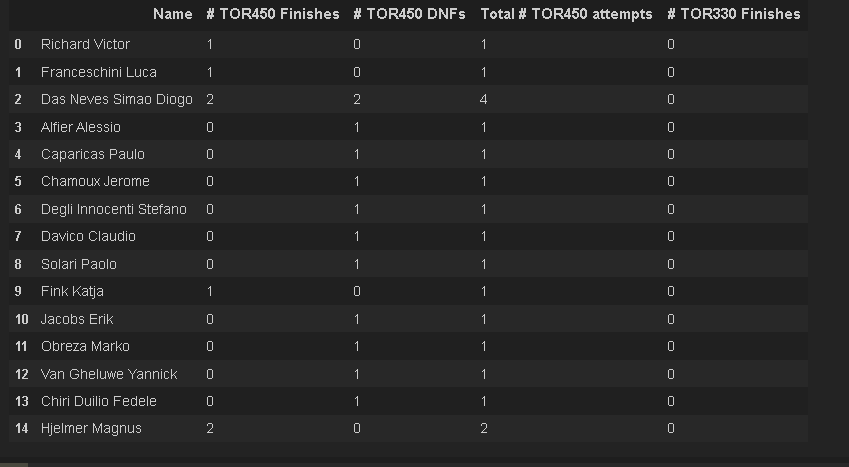

15 runners' TOR330 data I couldn't find!

In [172]:
count_TOR450_TOR330_per_runner[count_TOR450_TOR330_per_runner['# TOR330 Finishes'] == 0].reset_index(drop= True)

Name # TOR450 Finishes # TOR450 DNFs  \
0            Richard Victor                 1             0   
1     Das Neves Simao Diogo                 2             2   
2            Alfier Alessio                 0             1   
3           Caparicas Paulo                 0             1   
4            Chamoux Jerome                 0             1   
5   Degli Innocenti Stefano                 0             1   
6            Davico Claudio                 0             1   
7              Solari Paolo                 0             1   
8                Fink Katja                 1             0   
9               Jacobs Erik                 0             1   
10             Obreza Marko                 0             1   
11      Van Gheluwe Yannick                 0             1   
12      Chiri Duilio Fedele                 0             1   
13           Hjelmer Magnus                 2             0   

   Total # TOR450 attempts # TOR330 Finishes  
0                        1                 0  
1                        4                 0  
2                        1                 0  
3                        1                 0  
4                        1                 0  
5                        1                 0  
6                        1                 0  
7                        1                 0  
8                        1                 0  
9                        1                 0  
10                       1                 0  
11                       1                 0  
12                       1                 0  
13                       2                 0

In [173]:
count_TOR450_TOR330_per_runner.loc[(count_TOR450_TOR330_per_runner['# TOR450 Finishes'] != 0) &\
                                   (count_TOR450_TOR330_per_runner['# TOR450 DNFs'] != 0) &
                                   ( count_TOR450_TOR330_per_runner['Total # TOR450 attempts'] >1 )
                                   , 'Status' ] = 'Mix'

count_TOR450_TOR330_per_runner.loc[(count_TOR450_TOR330_per_runner['# TOR450 Finishes'] == 0) &\
                                   (count_TOR450_TOR330_per_runner['# TOR450 DNFs'] != 0)
                                   , 'Status' ] = 'All DNF'


count_TOR450_TOR330_per_runner.loc[(count_TOR450_TOR330_per_runner['# TOR450 Finishes'] != 0) &\
                                   (count_TOR450_TOR330_per_runner['# TOR450 DNFs'] == 0)
                                   , 'Status' ] = 'All Finish'

In [174]:
count_TOR450_TOR330_per_runner.groupby(['Status'])['Status'].count()

Status
All DNF       237
All Finish    157
Mix            58
Name: Status, dtype: int64

### Does TOR330 Experience improve your chance of finishing?
Eeeeeh, nope?

In [210]:
# Create the "TOR330 Experience" column
count_TOR450_TOR330_per_runner["# Times Completed TOR330"] = pd.cut(
    count_TOR450_TOR330_per_runner["# TOR330 Finishes"], 
    bins=[-1, 0, 1,2,3,4, 5, 10], 
    labels=["0", "1", "2", "3", "4", "5", "6+"])

# Set a categorical column with the defined order
count_TOR450_TOR330_per_runner["# Times Completed TOR330"] = pd.Categorical(
    count_TOR450_TOR330_per_runner["# Times Completed TOR330"],
    categories = ["0", "1", "2", "3", "4", "5", "6+"],
    ordered=True
)

# Group by TOR330 Experience and count the occurrences of each category
df_grouped = count_TOR450_TOR330_per_runner.groupby(
    ["# Times Completed TOR330"]
)[ "# TOR450 Finishes", "# TOR450 DNFs"].sum().reset_index(drop = False)

df_grouped['Total TOR450 Attempts'] = df_grouped['# TOR450 Finishes'] + df_grouped['# TOR450 DNFs']
df_grouped['% TOR450 Finishes'] = round(df_grouped['# TOR450 Finishes'] /df_grouped['Total TOR450 Attempts'] ,2 )
df_grouped['% TOR450 DNFs'] = round(df_grouped['# TOR450 DNFs'] /df_grouped['Total TOR450 Attempts'] , 2)


# Reshape DataFrame for Plotly
df_melted = df_grouped.melt(id_vars=["# Times Completed TOR330"], 
                             value_vars=["% TOR450 Finishes", "% TOR450 DNFs"], 
                             var_name="Category", 
                             value_name="Percentage")

# Create Bar Chart with Percentage Labels
fig = px.bar(df_melted, x="# Times Completed TOR330", y="Percentage",
             color="Category", barmode='group',
             title="Percentage of TOR450 Finishes & DNFs by TOR330 Experience",
             labels={"Percentage": "Percentage (%)"},
             text_auto='.2f'  # Display values with 2 decimal places
            )

fig.show()


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\3749635916.py:15: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



### FInish TOR330 TImes of everyone who ran TOR450

In [176]:
DUV330_all_who_started_TOR450

Name DUV_ationality Sex        DOB  \
0                Raichon Sebastien            FRA   M 1972-01-01   
1    Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01   
2    Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01   
3    Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01   
4                     Kienzl Peter            ITA   M 1975-01-01   
..                             ...            ...  ..        ...   
696                 Holst Benjamin            DEN   M 1970-01-01   
697                 Holst Benjamin            DEN   M 1970-01-01   
698                     Kriska Jan            USA   M 1967-01-01   
699            Urizar Jose Lorenzo            SUI   M 1966-01-01   
700                 L Heureux Yvan            CAN   M 1974-01-01   

        Performance  Performance_Seconds    Race  Year  Performance_hours  
0   3 days 14:25:33             311133.0  TOR330  2019          86.425833  
1   3 days 08:18:24             289104.0  TOR330  2019          80.306667  
2   4 days 07:23:07             372187.0  TOR330  2018         103.385278  
3   5 days 06:13:32             454412.0  TOR330  2014         126.225556  
4   3 days 05:31:11             279071.0  TOR330  2018          77.519722  
..              ...                  ...     ...   ...                ...  
696 5 days 09:47:29             467249.0  TOR330  2019         129.791389  
697 5 days 17:07:53             493673.0  TOR330  2016         137.131389  
698 4 days 16:59:19             406759.0  TOR330  2014         112.988611  
699 5 days 01:38:42             437922.0  TOR330  2019         121.645000  
700 5 days 08:40:11             463211.0  TOR330  2019         128.669722  

[701 rows x 9 columns]

In [180]:
DUV330_all_who_started_TOR450 = DUV330_all_who_started_TOR450.merge(
    count_TOR450_TOR330_per_runner[['Name',  '# Times Completed TOR330','Status']], 
    on = 'Name',
    how='left'
)

DUV330_all_who_started_TOR450

Name DUV_ationality Sex        DOB  \
0                Raichon Sebastien            FRA   M 1972-01-01   
1    Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01   
2    Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01   
3    Erwee Christiaan Dirk (Tiaan)            RSA   M 1987-01-01   
4                     Kienzl Peter            ITA   M 1975-01-01   
..                             ...            ...  ..        ...   
696                 Holst Benjamin            DEN   M 1970-01-01   
697                 Holst Benjamin            DEN   M 1970-01-01   
698                     Kriska Jan            USA   M 1967-01-01   
699            Urizar Jose Lorenzo            SUI   M 1966-01-01   
700                 L Heureux Yvan            CAN   M 1974-01-01   

        Performance  Performance_Seconds    Race  Year  Performance_hours  \
0   3 days 14:25:33             311133.0  TOR330  2019          86.425833   
1   3 days 08:18:24             289104.0  TOR330  2019          80.306667   
2   4 days 07:23:07             372187.0  TOR330  2018         103.385278   
3   5 days 06:13:32             454412.0  TOR330  2014         126.225556   
4   3 days 05:31:11             279071.0  TOR330  2018          77.519722   
..              ...                  ...     ...   ...                ...   
696 5 days 09:47:29             467249.0  TOR330  2019         129.791389   
697 5 days 17:07:53             493673.0  TOR330  2016         137.131389   
698 4 days 16:59:19             406759.0  TOR330  2014         112.988611   
699 5 days 01:38:42             437922.0  TOR330  2019         121.645000   
700 5 days 08:40:11             463211.0  TOR330  2019         128.669722   

    # Times Completed TOR330      Status  
0                          1  All Finish  
1                          3  All Finish  
2                          3  All Finish  
3                          3  All Finish  
4                          1  All Finish  
..                       ...         ...  
696                        2     All DNF  
697                        2     All DNF  
698                        1     All DNF  
699                        1     All DNF  
700                        1     All DNF  

[701 rows x 11 columns]

In [181]:
bin_size = DUV330_all_who_started_TOR450['Performance_hours'].max() -DUV330_all_who_started_TOR450['Performance_hours'].min()  
DUV330_all_who_started_TOR450['Performance_hours'] = round(DUV330_all_who_started_TOR450['Performance_hours'], 2)

DUV330_all_who_started_TOR450['round_Performance_hours'] = np.floor(DUV330_all_who_started_TOR450['Performance_hours'])

DUV330_all_who_started_TOR450['# Times Completed TOR330'] = \
DUV330_all_who_started_TOR450['# Times Completed TOR330'].astype('str').astype('category')


# Define custom color mapping
color_map = {
    'All Finish': '#4CAF50',  # Softer green
    'Mix': '#FFA500',  # Warm orange
    'All DNF': '#D32F2F'  # Deep red
}


TOR450_all_finish = RDUV330_all_who_started_TOR450[DUV330_all_who_started_TOR450['Status'] == 'All Finish']
TOR450_mix = DUV330_all_who_started_TOR450[DUV330_all_who_started_TOR450['Status'] == 'Mix']
TOR450_all_DNF = DUV330_all_who_started_TOR450[DUV330_all_who_started_TOR450['Status'] == 'All DNF']

# Create histogram
fig = px.histogram(DUV330_all_who_started_TOR450, x="round_Performance_hours", 
                   nbins=72,  # Bin size = 1
                   color  = 'Status',
                   title="Performance Distribution by Status",
                   labels={"Performance": "Performance Score", "count": "Frequency"},
                   barmode="overlay",
                               color_discrete_map=color_map ) # Apply custom colors)  # Overlapping bars for better comparison

# Show plot
fig.show()


In [207]:
from plotly.subplots import make_subplots


# Create subplots with shared y-axis
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=("TOR450 Finishes", "TOR450 Mix", "TOR450 All DNF"))
round_Performance_hours_category = ['77', '78', '79', 
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
       '101', '102', '103', '104', '105', '106', '107', '108', '109',
       '110', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '120', '121', '122', '123', '124', '125', '126', '127',
       '128', '129', '130', '131', '132', '133', '134', '135', '136',
       '137', '138', '139', '140', '141', '142', '143', '144', '145',
       '146', '147', '148' , '149']

DUV330_all_who_started_TOR450['round_Performance_hours_copy'] = DUV330_all_who_started_TOR450['round_Performance_hours'].copy()
DUV330_all_who_started_TOR450['round_Performance_hours_copy'] = DUV330_all_who_started_TOR450['round_Performance_hours_copy'].astype('int').astype('str')


# Set 'Finish Category' as a categorical column with the defined order
DUV330_all_who_started_TOR450['round_Performance_hours_copy'] = pd.Categorical(
    DUV330_all_who_started_TOR450['round_Performance_hours_copy'],
    categories = round_Performance_hours_category,
    ordered=True)

DUV330_all_who_started_TOR450 = DUV330_all_who_started_TOR450.sort_values(by = 'round_Performance_hours_copy', ascending = True)

TOR330_performance_table = DUV330_all_who_started_TOR450.groupby(['Status', 'round_Performance_hours_copy'])[ 'round_Performance_hours_copy'].count().to_frame(name = 'count').reset_index()

TOR450_all_finish = TOR330_performance_table[TOR330_performance_table['Status'] == 'All Finish']
TOR450_mix = TOR330_performance_table[TOR330_performance_table['Status'] == 'Mix']
TOR450_all_DNF = TOR330_performance_table[TOR330_performance_table['Status'] == 'All DNF']

# Bar Chart for TOR450 Finishes
fig.add_trace(go.Bar(x=TOR450_all_finish["round_Performance_hours_copy"], 
                     y=TOR450_all_finish["count"], 
                     name="Finishes", 
                     marker=dict(color="#4CAF50")), 
              row=1, col=1)

# Bar Chart for TOR450 Mix
fig.add_trace(go.Bar(x=TOR450_mix["round_Performance_hours_copy"], 
                     y=TOR450_mix["count"], 
                     name="Mix", 
                     marker=dict(color="#FFA500")), 
              row=2, col=1)

# Bar Chart for TOR450 All DNF
fig.add_trace(go.Bar(x=TOR450_all_DNF["round_Performance_hours_copy"], 
                     y=TOR450_all_DNF["count"], 
                     name="All DNF", 
                     marker=dict(color="#D32F2F")), 
              row=3, col=1)

# Standardize Y-Axis Range
fig.update_yaxes(matches='y')  # Ensures all subplots share the same y-axis range

# Increase Figure Size
fig.update_layout(height=800, width=800, title_text="Impact of TOR330 Experience on TOR450 Performance", 
                  showlegend=True)

# Show the figure
fig.show()


array(['77', '79', '80', '81', '83', '84', '85', '86', '87', '88', '89',
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
       '101', '102', '103', '104', '105', '106', '107', '108', '109',
       '110', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '120', '121', '122', '123', '124', '125', '126', '127',
       '128', '129', '130', '131', '132', '133', '134', '135', '136',
       '137', '138', '139', '140', '141', '142', '143', '144', '145',
       '146', '147', '148'], dtype=object)

In [211]:
for status in list(DUV330_all_who_started_TOR450['Status'].unique()):
    print(status)
    status_df = DUV330_all_who_started_TOR450[DUV330_all_who_started_TOR450['Status']== status]

    
    
        # Set a categorical column with the defined order
    status_df["# Times Completed TOR330"] = pd.Categorical(
        status_df["# Times Completed TOR330"],
        categories = ["0", "1", "2", "3", "4", "5", "6+"],
        ordered=True
    )
    
    status_df = status_df.sort_values(by = "# Times Completed TOR330", ascending = True )
    status_df['# Times Completed TOR330'] = \
    status_df['# Times Completed TOR330'].astype('str').astype('category')

    # Create histogram
    fig = px.histogram(status_df, x="round_Performance_hours", 
                       nbins=8 ,  # Bin size = 1
                       color  = '# Times Completed TOR330',
                       title=f"TOR330 Completed Times by {status}",
                       labels={"Performance": "Performance Score", "count": "Frequency"},
                       barmode="overlay")  # Overlapping bars for better comparison

    # Show plot
    fig.show()


All Finish


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\3400246788.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



All DNF


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\3400246788.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Mix


C:\Users\Karina\AppData\Local\Temp\ipykernel_11796\3400246788.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [212]:
DUV330_all_who_started_TOR450[(DUV330_all_who_started_TOR450['Status']== 'All Finish') &
                              
                              (DUV330_all_who_started_TOR450['# Times Completed TOR330'] == '1')
#                               (DUV330_all_who_started_TOR450['Performance']>129 )
                             ].sort_values(by ='Performance_hours', ascending = True).reset_index(drop = True)

Name DUV_ationality Sex        DOB     Performance  \
0           Kienzl Peter            ITA   M 1975-01-01 3 days 05:31:11   
1    Gabioud Jules Henri            SUI   M 1987-01-01 3 days 07:58:26   
2        Gabioud Candide            SUI   M 1984-01-01 3 days 12:34:07   
3           Bolis Matteo            ITA   M 1979-01-01 3 days 13:06:26   
4      Raichon Sebastien            FRA   M 1972-01-01 3 days 14:25:33   
..                   ...            ...  ..        ...             ...   
102          Baars Anouk            NED   F 1978-01-01 5 days 07:17:58   
103       Brambilla Luca            ITA   M 1997-01-01 5 days 08:04:54   
104         Firth Darren            GBR   M 1969-01-01 5 days 08:48:02   
105      Carminati Mirko            ITA   M 1987-01-01 5 days 09:01:04   
106        Arbel Yannick            FRA   M 1976-01-01 5 days 09:50:48   

     Performance_Seconds    Race  Year  Performance_hours  \
0               279071.0  TOR330  2018              77.52   
1               287906.0  TOR330  2011              79.97   
2               304447.0  TOR330  2022              84.57   
3               306386.0  TOR330  2021              85.11   
4               311133.0  TOR330  2019              86.43   
..                   ...     ...   ...                ...   
102             458278.0  TOR330  2018             127.30   
103             461094.0  TOR330  2023             128.08   
104             463682.0  TOR330  2016             128.80   
105             464464.0  TOR330  2019             129.02   
106             467448.0  TOR330  2021             129.85   

    # Times Completed TOR330      Status  round_Performance_hours  \
0                          1  All Finish                     77.0   
1                          1  All Finish                     79.0   
2                          1  All Finish                     84.0   
3                          1  All Finish                     85.0   
4                          1  All Finish                     86.0   
..                       ...         ...                      ...   
102                        1  All Finish                    127.0   
103                        1  All Finish                    128.0   
104                        1  All Finish                    128.0   
105                        1  All Finish                    129.0   
106                        1  All Finish                    129.0   

    round_Performance_hours_copy  
0                             77  
1                             79  
2                            NaN  
3                            NaN  
4                            NaN  
..                           ...  
102                          127  
103                          128  
104                          128  
105                          129  
106                          129  

[107 rows x 13 columns]

In [213]:
DUV_330[(DUV_330['Name'].str.contains('Williams|Croke'))]

Name DUV_ationality Sex        DOB     Performance  \
811           Williams Eric            USA   M 1985-01-01 4 days 13:03:11   
1223  Williams Sarah Kirsty            GBR   F 1973-01-01 4 days 21:37:34   
1644           Croke Ciaran            IRL   M 1989-01-01 5 days 02:25:28   
1955          Williams John            IRL   M 1976-01-01 5 days 04:53:42   
3014          Williams John            IRL   M 1976-01-01 5 days 13:45:18   
3816        Williams Brenda            CAN   F 1964-01-01 5 days 22:58:03   

      Performance_Seconds    Race  Year  Performance_hours  
811              392591.0  TOR330  2021         109.053056  
1223             423454.0  TOR330  2022         117.626111  
1644             440728.0  TOR330  2023         122.424444  
1955             449622.0  TOR330  2024         124.895000  
3014             481518.0  TOR330  2023         133.755000  
3816             514683.0  TOR330  2011         142.967500

In [214]:
print(DUV_450[DUV_450['Name'].isin(list(DUV330_all_who_started_TOR450['Name'].unique()))].shape)
print(DUV_450.shape)

(264, 10)
(270, 10)


In [215]:
sub_DUV330_all_who_started_TOR450 = DUV330_all_who_started_TOR450[['Name','Year','Performance_hours', 'Race']]
sub_TOR450_2019_2024 = TOR450_2019_2024[['Name','Year','Duration_hours', 'Race']]
sub_TOR450_2019_2024 = sub_TOR450_2019_2024.rename(columns = {'Duration_hours': 'Performance_hours'})
sub_TOR450_2019_2024

Name  Year  Performance_hours    Race
0                    Papi Luca  2019         134.166944  TOR450
1               Richard Victor  2019         139.783056  TOR450
2                 Ono Masahiro  2019         140.381111  TOR450
3                 Dove Matthew  2019         157.614444  TOR450
4                 Kuchimi Taro  2019         158.380000  TOR450
..                         ...   ...                ...     ...
552          Teuscher Christof  2021         183.018056  TOR450
553          Traina Christophe  2021         185.006667  TOR450
554           Tribolo Philippe  2021         184.408611  TOR450
555  Van Der Hoeven Jan Jilles  2021                NaN  TOR450
556           Wendling Vincent  2021         186.844722  TOR450

[657 rows x 4 columns]

In [216]:
sub_DUV330_all_who_started_TOR450 = sub_DUV330_all_who_started_TOR450[sub_DUV330_all_who_started_TOR450['Name'].isin(list(DUV330_all_who_started_TOR450['Name'].unique()))]

# Concatenate along columns (axis=1)
DUV_330_450 = pd.concat([sub_DUV330_all_who_started_TOR450, sub_TOR450_2019_2024])

DUV_330_450['Performance_hours'] = round(DUV_330_450['Performance_hours'], 2)
DUV_330_450['Performance_hours'] = DUV_330_450['Performance_hours'].astype('str')
DUV_330_450['Performance_hours'] = DUV_330_450['Performance_hours'].str.replace('nan','DNF')
DUV_330_450['Performance_Race'] = DUV_330_450['Race'] + " " + DUV_330_450['Performance_hours']


DUV_330_450_pivoted = DUV_330_450.pivot_table(
            index='Name',
            columns='Year',  
            values='Performance_Race',
            aggfunc='first'  # Ensures only the first match is kept in case of duplicates
        ).reset_index()
DUV_330_450_pivoted.reset_index(drop = True , inplace = True)
DUV_330_450_pivoted

Year                 Name 2010 2011 2012 2013 2014 2015 2016           2017  \
0               Adam Eric  NaN  NaN  NaN  NaN  NaN  NaN  NaN            NaN   
1             Adet Benoit  NaN  NaN  NaN  NaN  NaN  NaN  NaN            NaN   
2            Ador Thierry  NaN  NaN  NaN  NaN  NaN  NaN  NaN  TOR330 102.62   
3        Ageorges Fabrice  NaN  NaN  NaN  NaN  NaN  NaN  NaN            NaN   
4         Agnoli Cristian  NaN  NaN  NaN  NaN  NaN  NaN  NaN            NaN   
..                    ...  ...  ...  ...  ...  ...  ...  ...            ...   
447            Yvin Erwan  NaN  NaN  NaN  NaN  NaN  NaN  NaN            NaN   
448   Zanarella Cristiano  NaN  NaN  NaN  NaN  NaN  NaN  NaN            NaN   
449     Zapata Munoz Juan  NaN  NaN  NaN  NaN  NaN  NaN  NaN  TOR330 128.64   
450             Zhong Liu  NaN  NaN  NaN  NaN  NaN  NaN  NaN            NaN   
451         Zhou Dao Ting  NaN  NaN  NaN  NaN  NaN  NaN  NaN  TOR330 110.84   

Year           2018           2019           2021           2022  \
0               NaN            NaN  TOR330 123.29  TOR450 181.02   
1               NaN  TOR330 133.93  TOR330 128.63            NaN   
2      TOR330 93.53     TOR450 DNF            NaN     TOR450 DNF   
3               NaN  TOR330 125.25            NaN     TOR450 DNF   
4               NaN  TOR330 117.35            NaN            NaN   
..              ...            ...            ...            ...   
447             NaN            NaN            NaN            NaN   
448   TOR330 120.64  TOR450 166.59            NaN            NaN   
449             NaN     TOR450 DNF            NaN            NaN   
450             NaN            NaN            NaN            NaN   
451             NaN  TOR330 109.62            NaN            NaN   

Year           2023           2024  
0               NaN            NaN  
1               NaN  TOR450 185.51  
2        TOR450 DNF  TOR450 159.15  
3               NaN            NaN  
4        TOR450 DNF     TOR450 DNF  
..              ...            ...  
447   TOR330 116.48     TOR450 DNF  
448             NaN            NaN  
449             NaN            NaN  
450   TOR330 128.78     TOR450 DNF  
451    TOR450 169.8            NaN  

[452 rows x 15 columns]

In [217]:
DUV_330_450_pivoted[DUV_330_450_pivoted['Name'] == 'Tierney Paul']

Year          Name 2010 2011 2012 2013 2014 2015 2016          2017  \
419   Tierney Paul  NaN  NaN  NaN  NaN  NaN  NaN  NaN  TOR330 99.16   

Year          2018 2019         2021           2022           2023        2024  
419   TOR330 94.66  NaN  TOR330 88.1  TOR450 136.39  TOR450 135.37  TOR450 DNF

In [218]:
name = 'DUV_330_450_pivoted'
file_path = f'{race} Data/5. Clean Data for Data Visualisation/{race}_{name}.xlsx'
DUV_330_450_pivoted.to_excel(file_path, index=False)

In [219]:
print(race)

TOR450


In [220]:
DUV330_all_who_started_TOR450['Category'] = np.where(DUV330_all_who_started_TOR450['Performance_hours']<120,
                                                        'Sub-120', 'Over-120')
df_grouped = DUV330_all_who_started_TOR450[['Name','Year',
                               'Performance_hours', 'Race', 'Status', 'Category']][DUV330_all_who_started_TOR450['Performance_hours'] <130]\
.groupby(['Status', 'Category'])['Status'].count().to_frame(name = 'count').reset_index()
df_grouped

Status  Category  count
0     All DNF  Over-120    174
1     All DNF   Sub-120     99
2  All Finish  Over-120     62
3  All Finish   Sub-120    136
4         Mix  Over-120     43
5         Mix   Sub-120     65

In [221]:
df_grouped['Status'].unique()

array(['All DNF', 'All Finish', 'Mix'], dtype=object)

In [222]:
# Set a categorical column with the defined order
df_grouped["Category"] = pd.Categorical(
    df_grouped["Category"],
    categories = ['Sub-120', 'Over-120'],
    ordered=True
)
df_grouped["Status"] = pd.Categorical(
    df_grouped["Status"],
    categories = ['All Finish', 'Mix', 'All DNF'],
    ordered=True
)
df_grouped = df_grouped.sort_values(by = ["Category", "Status"], ascending =True)

# Define custom color mapping
color_map = {
    'All Finish': '#4CAF50',  # Softer green
    'Mix': '#FFA500',  # Warm orange
    'All DNF': '#D32F2F'  # Deep red
}

# Create Bar Chart with Percentage Labels
fig = px.bar(df_grouped, x="Category", y="count",
             color="Status", barmode='group',
             title="Percentage of TOR450 Finishes & DNFs by TOR330 Experience",
             color_discrete_map=color_map  # Apply custom colors
            )

fig.show()


In [227]:

# Create a new column 'Finish Category'
def categorize_duration(hours):
    if pd.isna(hours):
        return 'DNF'  # Handle NaT values
    elif hours < 50:
        return 'Sub-50'
    elif hours <= 150:
        return f'Sub-{int(hours // 10) * 10 + 10}'  # Round to nearest 10 up to 150
    else:
        return 'Over-150'
    
DUV330_all_who_started_TOR450['Finish Category'] = DUV330_all_who_started_TOR450['Performance_hours'].apply(categorize_duration)


# Define the desired order of categories
finish_category_order = [
    'Sub-50','Sub-60',
    'Sub-70','Sub-80','Sub-90', 'Sub-100', 'Sub-110', 'Sub-120',
    'Sub-130', 'Sub-140', 'Sub-150', 'Over-150', 'DNF']

# Set 'Finish Category' as a categorical column with the defined order
DUV330_all_who_started_TOR450['Finish Category'] = pd.Categorical(
    DUV330_all_who_started_TOR450['Finish Category'],
    categories = finish_category_order,
    ordered = True
)



df_grouped = DUV330_all_who_started_TOR450[['Name','Year',
                               'Performance_hours', 'Race', 'Status', 'Category', 'Finish Category']].groupby(['Status', 'Finish Category'])['Status'].count().to_frame(name = 'count').reset_index()
df_grouped

Status Finish Category  count
0      All DNF          Sub-50      0
1      All DNF          Sub-60      0
2      All DNF          Sub-70      0
3      All DNF          Sub-80      0
4      All DNF          Sub-90      7
5      All DNF         Sub-100      8
6      All DNF         Sub-110     26
7      All DNF         Sub-120     58
8      All DNF         Sub-130    174
9      All DNF         Sub-140     37
10     All DNF         Sub-150     48
11     All DNF        Over-150      0
12     All DNF             DNF      0
13  All Finish          Sub-50      0
14  All Finish          Sub-60      0
15  All Finish          Sub-70      0
16  All Finish          Sub-80      2
17  All Finish          Sub-90      8
18  All Finish         Sub-100     20
19  All Finish         Sub-110     55
20  All Finish         Sub-120     51
21  All Finish         Sub-130     62
22  All Finish         Sub-140     12
23  All Finish         Sub-150      9
24  All Finish        Over-150      0
25  All Finish             DNF      0
26         Mix          Sub-50      0
27         Mix          Sub-60      0
28         Mix          Sub-70      0
29         Mix          Sub-80      0
30         Mix          Sub-90      3
31         Mix         Sub-100     16
32         Mix         Sub-110     23
33         Mix         Sub-120     23
34         Mix         Sub-130     43
35         Mix         Sub-140      8
36         Mix         Sub-150      8
37         Mix        Over-150      0
38         Mix             DNF      0

In [228]:

# Create Bar Chart with Percentage Labels
fig = px.bar(df_grouped, x="Finish Category", y="count",
             color="Status", barmode='group',
             title="Percentage of TOR450 Finishes & DNFs by TOR330 Experience",
             color_discrete_map=color_map  # Apply custom colors
            )

fig.show()

In [225]:
for name in list(DUV330_all_who_started_TOR450['Name'].unique()):
    bib_df = DUV330_all_who_started_TOR450[DUV330_all_who_started_TOR450['Name'] == name]
    qualified = 0
    for year in list(bib_df['Year'].unique()):
        year_bib_df = bib_df[bib_df['Year'] == year]
        
        performance_330 = year_bib_df['Performance_hours'].values[0]
        if performance_330 <130: # less than 130 hours
            qualified = qualified + 1
            print(name, year, qualified)

Kienzl Peter 2018 1
Gabioud Jules Henri 2011 1
Galve Sainz De Varanda Javier 2023 1
Mullins Brian 2023 1
Mullins Brian 2022 2
Bie Nicolas 2022 1
Laving Jean Marc 2021 1
Criado Toca Pablo 2013 1
Criado Toca Pablo 2021 2
Criado Toca Pablo 2012 3
Criado Toca Pablo 2016 4
Criado Toca Pablo 2015 5
Criado Toca Pablo 2011 6
Herrero Casas Albert 2014 1
Keith Eoin 2014 1
Guerini Luca 2023 1
Guerini Luca 2017 2
Guerini Luca 2018 3
Guerini Luca 2014 4
Guerini Luca 2013 5
Guerini Luca 2024 6
Ador Thierry 2018 1
Ador Thierry 2017 2
Annovazzi Giancarlo 2011 1
Annovazzi Giancarlo 2019 2
Annovazzi Giancarlo 2012 3
Annovazzi Giancarlo 2010 4
Annovazzi Giancarlo 2014 5
Annovazzi Giancarlo 2013 6
Berthon Mickael 2023 1
Bombenger Jean Francois 2019 1
Bombenger Jean Francois 2018 2
Tierney Paul 2018 1
Tierney Paul 2017 2
Tierney Paul 2021 3
Manfredi Negri Luca 2017 1
Manfredi Negri Luca 2013 2
Christin Benoit Julien 2021 1
Ono Masahiro 2017 1
Ono Masahiro 2023 2
Ono Masahiro 2013 3
Ono Masahiro 2015 4
Ono 

Garcia Rodriguez Jorge Manuel 2016 1
Felix Christophe 2017 1
Thiebat Orlando 2011 1
Zanarella Cristiano 2018 1
Ciapa Philippe 2023 1
Argelich Torra Enrique 2022 1
Cattaneo Martino 2021 1
Papa Fabrizio 2017 1
Quigley James 2013 1
Gentilini Iader 2019 1
Oeillet Sylvain 2018 1
Oeillet Sylvain 2014 2
Dessambre Nicolas 2022 1
Bokman Jakob 2021 1
Neale Matthew 2019 1
Neale Matthew 2017 2
Bongioanni Fabrizio 2023 1
Girgin Serkan 2014 1
Girgin Serkan 2018 2
Comero Roberto 2023 1
Bedhet Guillaume 2018 1
Ward Peter 2022 1
Noville Maurice 2019 1
Urizar Jose Lorenzo 2019 1
Krawczyk Tomasz 2014 1
Krawczyk Tomasz 2011 2
Gasparini Thierry 2016 1
Gaetani Elio 2017 1
Piazzo Mario 2010 1
Candido Luca 2021 1
Candido Luca 2018 2
Rovelli Roberto 2014 1
Rovelli Roberto 2011 2
Ost Vincent 2021 1
Soler Jean Pierre 2022 1
Petersen Heine Hove 2014 1
Duranti Luca 2022 1
Marois Martine 2021 1
Girard Norbert 2018 1
Van Der Hoeven Jan Jilles 2018 1
Van Der Hoeven Jan Jilles 2016 2
Van Der Hoeven Jan Jilles 2017 3
C